# AIR POLLUTION PREDICTION USING MACHINE LEARNING

# Connecting to Google Drive

In [1]:
# Connecting Google Colab to Google Drive
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


# Setting current working directory to project folder

In [2]:
PWD = "gdrive/MyDrive/Projects/Hameedat Air Pollutant Forecast"
DATASET_PATH = 'PRSA_Data'
MODEL_PATH = 'models'
RESULTS_PATH = 'results'
CLEANED_DATASET_PATH = 'cleaned_datasets'

# setting working directory
%cd {PWD}

/content/gdrive/MyDrive/Projects/Hameedat Air Pollutant Forecast


In [ ]:
# MODEL_PATH = f'models'
# RESULTS_PATH = f'results'
# CLEANED_DATASET_PATH = 'cleaned_datasets'

In [ ]:
# Creating appropriate folders if not already existing

import os

# if not os.path.exists(DATASET_PATH):
#     os.mkdir(DATASET_PATH)

if not os.path.exists(MODEL_PATH):
    os.mkdir(MODEL_PATH)

if not os.path.exists(RESULTS_PATH):
    os.mkdir(RESULTS_PATH)

if not os.path.exists(CLEANED_DATASET_PATH):
    os.mkdir(CLEANED_DATASET_PATH)


# Installing dependencies

In [3]:
# installing model architecture visualizer
!pip install git+https://github.com/paulgavrikov/visualkeras --upgrade

# installing LSTM Forecast dependencies
!pip install neuralforecast
# !conda install "ray-tune" -c conda-forge

# for params tunning
!pip install ray torch torchvision hyperopt 


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/paulgavrikov/visualkeras to /tmp/pip-req-build-329gaf2e
  Running command git clone --filter=blob:none --quiet https://github.com/paulgavrikov/visualkeras /tmp/pip-req-build-329gaf2e
  Resolved https://github.com/paulgavrikov/visualkeras to commit cd169b81be347e2090353ad6fe2bd2e1f4020cf4
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.0/993.0 kB 33.6 MB/s eta 0:00:00
  Created wheel for visualkeras: filename=visualkeras-0.0.2-py3-none-any.whl size=13719 sha256=b7f50006137bb8b9495f7ebda6afffd93419c05fe4027e1aa52ae1a2ec5b982d
  Stored in directory: /tmp/pip-ephem-wheel-cache-mo65abl7/wheels/89/d3/c2/937382b33c09192fc84331bbc02c4565d62aeae67e9684c37e
Successfully built visualkeras
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

# Importing libararies

In [4]:
## Utilities
import os
import pickle
from math import sqrt
from numpy import log

## Data wrangling and loader
import pandas as pd
import numpy as np

## Visualizations
import seaborn as sns
import matplotlib.pyplot as plt

## Data preprocessing
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.preprocessing import MinMaxScaler
# from sklearn.model_selection import train_test_split, KFold

## Testing for stationarity of forecast variable
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

## Forecaster
# CNN, LSTM and RNN
from keras.models import Sequential
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import RNN
from keras.layers import Dropout
from keras.layers import Bidirectional
from keras.layers import BatchNormalization
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import BatchNormalization
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

from keras.models import load_model

from keras.optimizers import (Adam, SGD)
from keras.callbacks import EarlyStopping
from keras.callbacks import LearningRateScheduler


## Performance metrics
from keras.metrics.regression_metrics import MeanAbsoluteError
from keras.metrics.regression_metrics import MeanSquaredError
from keras.metrics.regression_metrics import RootMeanSquaredError
from keras.metrics.regression_metrics import MeanAbsolutePercentageError

from keras.utils.vis_utils import plot_model
import visualkeras


# # LSTM & RNN forecaster with param tunning
# from neuralforecast import NeuralForecast
# from neuralforecast.auto import AutoLSTM
# from neuralforecast.auto import AutoRNN
# from neuralforecast.models import LSTM
# from neuralforecast.models import RNN
# from neuralforecast.losses.pytorch import (RMSE, MSE, MAE, MAPE)

## Hyper-parameter tunning using ray tune
import ray
from ray import air, tune
from ray.tune.schedulers import AsyncHyperBandScheduler
from ray.tune.integration.keras import TuneReportCallback


## Performance metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import r2_score, mean_absolute_percentage_error

## Suppressing unnecessary warnings
import warnings
warnings.filterwarnings("ignore")

## Allowing Auto-viewing of plots without having to call plt.show() everytime
%matplotlib inline

In [5]:
# Default plotting configurations
sns.set_style('darkgrid')
plt.rcParams['figure.figsize']=(12,6)
plt.rcParams['font.size']=12

# Loading datasets

In [6]:
#import five Beijng mulit-site air quality data for different cities
No = pd.read_csv(f'{CLEANED_DATASET_PATH}/Nongzhanguan_cleaned.csv', index_col=0, parse_dates=True)

# making index hourly time series
No.index.freq = 'H'

## Exploratory Data Analysis (EDA)

In [ ]:
No.head()

TEMP    PRES  DEWP  RAIN     wd  WSPM  PM2.5  PM10  SO2  \
datetime                                                                       
2013-03-01 00:00:00  -0.5  1024.5 -21.4   0.0  337.5   5.7    5.0  14.0  4.0   
2013-03-01 01:00:00  -0.7  1025.1 -22.1   0.0  315.0   3.9    8.0  12.0  6.0   
2013-03-01 02:00:00  -1.2  1025.3 -24.6   0.0  337.5   5.3    3.0   6.0  5.0   
2013-03-01 03:00:00  -1.4  1026.2 -25.5   0.0  360.0   4.9    5.0   5.0  5.0   
2013-03-01 04:00:00  -1.9  1027.1 -24.5   0.0  337.5   3.2    5.0   5.0  6.0   

                      NO2     CO    O3  
datetime                                
2013-03-01 00:00:00  12.0  200.0  85.0  
2013-03-01 01:00:00  14.0  200.0  84.0  
2013-03-01 02:00:00  14.0  200.0  83.0  
2013-03-01 03:00:00  14.0  200.0  84.0  
2013-03-01 04:00:00  21.0  200.0  77.0

In [ ]:
# View data shape sizes
print(f'Nongzhanguan Data shape: {No.shape}')

Nongzhanguan Data shape: (35064, 12)


In [ ]:
No.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 35064 entries, 2013-03-01 00:00:00 to 2017-02-28 23:00:00
Freq: H
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   TEMP    35064 non-null  float64
 1   PRES    35064 non-null  float64
 2   DEWP    35064 non-null  float64
 3   RAIN    35064 non-null  float64
 4   wd      35064 non-null  float64
 5   WSPM    35064 non-null  float64
 6   PM2.5   35064 non-null  float64
 7   PM10    35064 non-null  float64
 8   SO2     35064 non-null  float64
 9   NO2     35064 non-null  float64
 10  CO      35064 non-null  float64
 11  O3      35064 non-null  float64
dtypes: float64(12)
memory usage: 3.5 MB


In [ ]:
#view data description
print(f'Nongzhanguan:\n')
No.describe()

Nongzhanguan:



TEMP          PRES          DEWP          RAIN            wd  \
count  35064.000000  35064.000000  35064.000000  35064.000000  35064.000000   
mean      13.668250   1012.551871      2.445126      0.063983    168.910421   
std       11.459735     10.266471     13.811939      0.786059    105.493455   
min      -16.800000    987.100000    -35.300000      0.000000     22.500000   
25%        3.100000   1004.000000     -8.800000      0.000000     67.500000   
50%       14.600000   1012.200000      3.000000      0.000000    157.500000   
75%       23.500000   1020.900000     15.000000      0.000000    247.500000   
max       41.100000   1042.000000     28.800000     46.400000    360.000000   

               WSPM         PM2.5          PM10           SO2           NO2  \
count  35064.000000  35064.000000  35064.000000  35064.000000  35064.000000   
mean       1.860815     85.079472    109.384022     18.760102     58.095053   
std        1.280427     86.692516     96.088407     24.379948     36.380351   
min        0.000000      2.000000      2.000000      0.571200      2.000000   
25%        1.000000     22.000000     38.000000      3.000000     29.000000   
50%        1.500000     59.000000     85.000000      9.000000     51.000000   
75%        2.400000    116.000000    149.000000     24.000000     80.000000   
max       10.500000    844.000000    995.000000    257.000000    273.000000   

                 CO            O3  
count  35064.000000  35064.000000  
mean    1327.767611     58.432876  
std     1257.098704     58.330590  
min      100.000000      0.214200  
25%      500.000000     10.000000  
50%      900.000000     45.000000  
75%     1600.000000     83.000000  
max    10000.000000    390.000000

In [ ]:
# Missing values
print('Nongzhanguan:\n--------------\n')
print(No.isna().sum())


Nongzhanguan:
--------------

TEMP     0
PRES     0
DEWP     0
RAIN     0
wd       0
WSPM     0
PM2.5    0
PM10     0
SO2      0
NO2      0
CO       0
O3       0
dtype: int64


# PREPROCESSING FOR MODELING

## My custom utility functions

In [7]:
# MAPE: Mean absolute Percentage Error
METRICS = ['MAE', 'MSE', 'RMSE', 'R-Squared', 'MAPE']

In [17]:
def save_model_pickle(model, filename):
  try:
    pickle.dump(model, open(f'{MODEL_PATH}/{filename}', 'wb'))
    print('Saved')
  except Exception as err:
    print(err)


def load_model_pickle(filename):
  try:
    model = pickle.load(open(f'{MODEL_PATH}/{filename}', 'rb'))
    return model
  except Exception as err:
    print(err)
    return None

In [9]:
def evaluate_model_performance(y_true, predictions, label='dt'):
    mae = mean_absolute_error(y_true, predictions)
    mse = mean_squared_error(y_true, predictions)
    rmse = sqrt(mean_squared_error(y_true, predictions))
    r2 = r2_score(y_true, predictions)

    sum_y_true = np.sum(y_true)
    # mean_abs_prec_err = np.sum( np.abs(y_true - predictions) ) / sum_y_true
    # accuracy = 1 - mean_abs_prec_err
    MAPE = np.mean(np.abs(y_true - predictions) / y_true)
     
    results = {label: [mae, mse, rmse, r2, MAPE]}
    
    return pd.DataFrame(results, index=METRICS).round(3)


In [10]:
def visualize_features_series(df,  hours=24*31*6, index=-1):
    colors = ['black', 'red', 'blue', 'green', 'gray', 'orange']
    sub_df = df[['TEMP','PRES','DEWP','RAIN','wd','WSPM']]
    
    if index < 0 and hours <= len(sub_df):   # if index is negative, select last 'hours' series
        sub_df = sub_df.iloc[-hours:]
    elif index > 0 and hours <= len(sub_df): # otherwise, select first 'hours' series data
        sub_df = sub_df.iloc[:-hours]

    plt.figure(figsize=(16, 8), dpi=150)
    fig, ax = plt.subplots(len(sub_df.columns), sharex=True)

    for i, col in enumerate(sub_df):
        ax[i].plot(sub_df[col], label=col, color=colors[i])
        ax[i].set_title(col)
    fig.tight_layout()



def visualize_pollutants_series(df, hours=24*31*6, index=-1):
    colors = ['black', 'red', 'blue', 'green', 'gray', 'orange']
    sub_df = df.iloc[:, -6:]

    if index < 0 and hours <= len(sub_df):   # if index is negative, select last 'hours' series
        sub_df = sub_df.iloc[-hours:]
    elif index > 0 and hours <= len(sub_df): # otherwise, select first 'hours' series data
        sub_df = sub_df.iloc[:-hours]

    plt.figure(figsize=(16, 8), dpi=150)
    fig, ax = plt.subplots(len(sub_df.columns), sharex=True)

    for i, col in enumerate(sub_df):
        ax[i].plot(sub_df[col], label=col, color=colors[i])
        ax[i].set_title(col)
    fig.tight_layout()

In [11]:
# from statsmodels.tsa.stattools import adfuller
def test_for_stationarity_single(series_data=None):
    results = adfuller(series_data.dropna())
    print(f'p-value: {results[1]}')    
    if results[1] < 0.05:  # if p value is less than 0.05, it is assumed to be stationary
        print('Series is stationary')
    else:
        print('Series is not stationary')


def plot_corr(corr, title='Feature Correlations with PM2.5'):
    # Getting the Upper Triangle of the co-relation matrix
    upper_mat = np.triu(corr)
    upper_mat[np.diag_indices_from(upper_mat)] = False

    plt.figure(figsize=(10,6))
    sns.heatmap(corr, annot=True, cmap='Blues', mask=upper_mat,
                center=0, fmt='.2f', square=True)
    plt.title(title)


def visualize_series_single(series_data=None, days=None, title='PM2.5 Pollutant AQI'):
    if series_data is not None:
        if days is None:
            series_data.plot(title=title)
        elif days > len(series_data) * 24:
            series_data.plot(title=title)
        else:
            series_data[-24 * days:].plot(title=title)


# from statsmodels.tsa.seasonal import seasonal_decompose
def decompose_series_single(series_data=None, model='additive', period=24):
    """
      model: {'additive' | 'multiplicative'}. 
          NOTE: 
            Use 'additive' if seasonal variation are relatively constant over time. i.e. linear.
            Use 'multiplicative' if the trend and seasonal variation increase or decrease over time.
    """

    if series_data is not None:
        results=seasonal_decompose(series_data, model=model, period=period)
        results.plot()
        return results


def series_to_supervised_dataset_single(series_data, n_lags=24):
    dataframe = pd.DataFrame()
    for i in range(n_lags, 0, -1):
        dataframe[f"{series_data.name.replace('.', '')}t-{i}"] = series_data.shift(i)
    final_data = pd.concat([dataframe, series_data], axis=1)
    final_data.dropna(inplace=True)
    return final_data


# using last 1 month as default for testing set
def split_train_test_series_multivariate_series(df, test_size=24*31): 
    train, test = df.iloc[:-test_size], df.iloc[-test_size:]
    X_train, y_train = train.iloc[:, :-1], train.iloc[:,-1]
    X_test, y_test = test.iloc[:, :-1], test.iloc[:,-1]

    return (X_train, y_train, X_test, y_test)
  

# using last 1 month as default for testing set
def split_train_test_series_single(series_data, test_size=24*31): 
    train, test = series_data[:-test_size], series_data[-test_size:]
    return (train, test)


# splita data series into CNN based data points
def deep_prepare_X_y_for_CNN(X=None, y=None, n_lags=6, kind='single'):
    """
    Converts X,y into a form suitable for 1D CNN model for time-series

    args:
        kind: the kind of Time series problem
          values: {'single', 'multi_input', 'parallel'}
            - 'single': One series data
            - 'multi_input': Multiple input series with one output
            - 'parallel': multiple_input series with multiple forecast, one for each series

        n_lags: the number of past data to use to forecast the next
    """
    newX, newY = list(), list()
    
    if kind == 'single':
        for i in range(len(X)):
            seqX = X.iloc[i].values
            seqX = seqX.reshape(X.shape[1], 1)
            newX.append(seqX)
        return np.array(newX), y.values

    elif kind == 'multi_input':
        for i in range(len(X)):
            end_id = i + n_lags
            if end_id > len(y): # at the end already
                break
            
            seqX, seqY = X.iloc[i:end_id].values, y.iloc[end_id-1]
            newX.append(seqX)
            newY.append(seqY)
        return np.array(newX), np.array(newY)
    
    elif kind == 'parallel':
        for i in range(len(X)):
            end_id = i + n_lags
            if end_id >= len(X): # at the end already
                break
            
            seqX, seqY = X.iloc[i:end_id,:].values, X.iloc[end_id, :].values
            # seqY = seqY.reshape()
            newX.append(seqX)
            newY.append(seqY)
        return np.array(newX), np.array(newY)

    else:
        return None, None

# Preparing data for Multi-step forecast 
def deep_prepare_X_y_for_CNN_multi_step(
    X=None, y=None, n_lags=6, 
    future_steps=None, start=0, end=None):
    """
    Converts X,y into a form suitable for 1D CNN model for time-series

    args:
        kind: the kind of Time series problem
          values: {'single', 'multi_input', 'parallel'}
            - 'single': One series data
            - 'multi_input': Multiple input series with one output
            - 'parallel': multiple_input series with multiple forecast, one for each series

        n_lags: the number of past data to use to forecast the next
    """

    newX = []
    newY = []
    start = start + n_lags
    if end is None:
        end = len(X) - future_steps
    for i in range(start, end):
        indices = range(i-n_lags, i)
        newX.append(X[indices])
        indicey = range(i+1, i+1+future_steps)
        newY.append(y[indicey])

    return np.array(newX), np.array(newY)



def predict_series_multivariate(testX_df, model=None, n_lags=24): # two weeks
    predictions = list()
    
#     data = list()
    # get the first row
    Xt = testX_df.iloc[0].values.reshape(1,n_lags)
    print(Xt.shape)
    for i in range(0, len(testX_df)):
        yhat = model.predict(Xt)
        # yhat =  Xt[-1] + 20
        predictions.append(yhat[0])
        
        Xt = np.append(Xt[:,1:], yhat[0]).reshape(1,n_lags)
        # data.append(Xt)
    
    predictions = pd.Series(predictions, index=testX_df.index, name='PM2.5')
    # return np.array(data), predictions
    return predictions

In [12]:
x = {
    'x1': [10,20,30,40,50,60,70,80,90],
    'x2': [100,200,300,400,500,600,700,800,900],
    'y': [110, 220, 330, 440, 550, 660, 770, 880, 990]
}
xf = pd.DataFrame(x)
xf

x1   x2    y
0  10  100  110
1  20  200  220
2  30  300  330
3  40  400  440
4  50  500  550
5  60  600  660
6  70  700  770
7  80  800  880
8  90  900  990

In [ ]:
xfnew = series_to_supervised_dataset_single(xf.y, n_lags=3)
xfnew

yt-3   yt-2   yt-1    y
3  110.0  220.0  330.0  440
4  220.0  330.0  440.0  550
5  330.0  440.0  550.0  660
6  440.0  550.0  660.0  770
7  550.0  660.0  770.0  880
8  660.0  770.0  880.0  990

In [ ]:
split_train_test_series_multivariate_series(xfnew,test_size=2)

(    yt-3   yt-2   yt-1
 3  110.0  220.0  330.0
 4  220.0  330.0  440.0
 5  330.0  440.0  550.0
 6  440.0  550.0  660.0,
 3    440
 4    550
 5    660
 6    770
 Name: y, dtype: int64,
     yt-3   yt-2   yt-1
 7  550.0  660.0  770.0
 8  660.0  770.0  880.0,
 7    880
 8    990
 Name: y, dtype: int64)

# Data Segmentation

In [13]:
features_X_nong = No[No.columns[:6]]
y_pm25_nong = No['PM2.5']
y_pm10_nong = No.PM10
y_so2_nong = No.SO2
y_no2_nong = No.NO2
y_co_nong = No.CO
y_o3_nong = No.O3

# Preparing data for Time-series Modeling

## Scaling the features (Metereological variables)

In [14]:
scaler_nong = StandardScaler()

In [15]:
# Scaling Nongzhanguan station Feature (Weather) data

scaled_features_X_nong = scaler_nong.fit_transform(features_X_nong)
scaled_features_X_nong  = pd.DataFrame(scaled_features_X_nong, index=features_X_nong.index, columns=features_X_nong.columns)
scaled_features_X_nong.head()

TEMP      PRES      DEWP      RAIN        wd  \
datetime                                                                
2013-03-01 00:00:00 -1.236368  1.163818 -1.726439 -0.081398  1.598127   
2013-03-01 01:00:00 -1.253821  1.222261 -1.777120 -0.081398  1.384841   
2013-03-01 02:00:00 -1.297452  1.241742 -1.958126 -0.081398  1.598127   
2013-03-01 03:00:00 -1.314905  1.329407 -2.023288 -0.081398  1.811414   
2013-03-01 04:00:00 -1.358537  1.417073 -1.950885 -0.081398  1.598127   

                         WSPM  
datetime                       
2013-03-01 00:00:00  2.998406  
2013-03-01 01:00:00  1.592605  
2013-03-01 02:00:00  2.686006  
2013-03-01 03:00:00  2.373605  
2013-03-01 04:00:00  1.045905

In [18]:
# Saving the scaler object
save_model_pickle(scaler_nong, filename='Nongzhanguan_scaler_obj.pickle')

Saved


---

In [19]:
pm25_data_nong = pd.concat([features_X_nong, y_pm25_nong], axis='columns')

In [20]:
pm25_data_nong.head(3)

TEMP    PRES  DEWP  RAIN     wd  WSPM  PM2.5
datetime                                                         
2013-03-01 00:00:00  -0.5  1024.5 -21.4   0.0  337.5   5.7    5.0
2013-03-01 01:00:00  -0.7  1025.1 -22.1   0.0  315.0   3.9    8.0
2013-03-01 02:00:00  -1.2  1025.3 -24.6   0.0  337.5   5.3    3.0

---

# Nongzhanguan Station

## CNN (without Exogenous Metereological Variables)


- 1 day forecast (steps)
- 1 day (24 hrs) lag
- CNN
- Nongzhanguan station data

In [ ]:
TEST_SIZE = int((20 / 100) * len(y_pm25_nong))
N_STEPS = 24
N_LAGS = 24
N_FEATURES = len(features_X_nong.columns)

#### Data Preparation and preprocessing

In [ ]:
data_y_pm25 = series_to_supervised_dataset_single(y_pm25_nong, n_lags=N_LAGS)
data_y_pm25.head()

PM25t-24  PM25t-23  PM25t-22  PM25t-21  PM25t-20  \
datetime                                                                
2013-03-02 00:00:00       5.0       8.0       3.0       5.0       5.0   
2013-03-02 01:00:00       8.0       3.0       5.0       5.0       3.0   
2013-03-02 02:00:00       3.0       5.0       5.0       3.0       4.0   
2013-03-02 03:00:00       5.0       5.0       3.0       4.0       3.0   
2013-03-02 04:00:00       5.0       3.0       4.0       3.0       3.0   

                     PM25t-19  PM25t-18  PM25t-17  PM25t-16  PM25t-15  ...  \
datetime                                                               ...   
2013-03-02 00:00:00       3.0       4.0       3.0       3.0      11.0  ...   
2013-03-02 01:00:00       4.0       3.0       3.0      11.0       3.0  ...   
2013-03-02 02:00:00       3.0       3.0      11.0       3.0       3.0  ...   
2013-03-02 03:00:00       3.0      11.0       3.0       3.0       3.0  ...   
2013-03-02 04:00:00      11.0       3.0       3.0       3.0       3.0  ...   

                     PM25t-9  PM25t-8  PM25t-7  PM25t-6  PM25t-5  PM25t-4  \
datetime                                                                    
2013-03-02 00:00:00      5.0      5.0     10.0     11.0     11.0     10.0   
2013-03-02 01:00:00      5.0     10.0     11.0     11.0     10.0     12.0   
2013-03-02 02:00:00     10.0     11.0     11.0     10.0     12.0     17.0   
2013-03-02 03:00:00     11.0     11.0     10.0     12.0     17.0      6.0   
2013-03-02 04:00:00     11.0     10.0     12.0     17.0      6.0     13.0   

                     PM25t-3  PM25t-2  PM25t-1  PM2.5  
datetime                                               
2013-03-02 00:00:00     12.0     17.0      6.0   13.0  
2013-03-02 01:00:00     17.0      6.0     13.0    3.0  
2013-03-02 02:00:00      6.0     13.0      3.0    3.0  
2013-03-02 03:00:00     13.0      3.0      3.0    3.0  
2013-03-02 04:00:00      3.0      3.0      3.0    3.0  

[5 rows x 25 columns]

In [ ]:
Xtrain_nong, ytrain_nong, Xtest_nong, ytest_nong = split_train_test_series_multivariate_series(data_y_pm25, test_size=TEST_SIZE)

In [ ]:
Xtrain_nong.head(2)

PM25t-24  PM25t-23  PM25t-22  PM25t-21  PM25t-20  \
datetime                                                                
2013-03-02 00:00:00       5.0       8.0       3.0       5.0       5.0   
2013-03-02 01:00:00       8.0       3.0       5.0       5.0       3.0   

                     PM25t-19  PM25t-18  PM25t-17  PM25t-16  PM25t-15  ...  \
datetime                                                               ...   
2013-03-02 00:00:00       3.0       4.0       3.0       3.0      11.0  ...   
2013-03-02 01:00:00       4.0       3.0       3.0      11.0       3.0  ...   

                     PM25t-10  PM25t-9  PM25t-8  PM25t-7  PM25t-6  PM25t-5  \
datetime                                                                     
2013-03-02 00:00:00       6.0      5.0      5.0     10.0     11.0     11.0   
2013-03-02 01:00:00       5.0      5.0     10.0     11.0     11.0     10.0   

                     PM25t-4  PM25t-3  PM25t-2  PM25t-1  
datetime                                                 
2013-03-02 00:00:00     10.0     12.0     17.0      6.0  
2013-03-02 01:00:00     12.0     17.0      6.0     13.0  

[2 rows x 24 columns]

In [ ]:
ytrain_nong.head(2)

datetime
2013-03-02 00:00:00    13.0
2013-03-02 01:00:00     3.0
Freq: H, Name: PM2.5, dtype: float64

In [ ]:
print(f'Shape of X: {features_X_nong.shape}')
print(f'Shape of Xtrain: {Xtrain_nong.shape}')
print(f'Shape of Xtest: {Xtest_nong.shape}')

Shape of X: (35064, 6)
Shape of Xtrain: (28028, 24)
Shape of Xtest: (7012, 24)


In [ ]:
deep_Xtrain_nong, deep_ytrain_nong = deep_prepare_X_y_for_CNN(X=Xtrain_nong, y=ytrain_nong, n_lags=N_LAGS, kind='single')
deep_Xtest_nong, deep_ytest_nong = deep_prepare_X_y_for_CNN(X=Xtest_nong, y=ytest_nong, n_lags=N_LAGS, kind='single')

In [ ]:
print(f'Shape of Xtrain: {Xtrain_nong.shape}')
print(f'Shape of Deep-Xtrain: {deep_Xtrain_nong.shape}')
print(f'Shape of Deep-Xtest: {deep_Xtest_nong.shape}')
print(f'Shape of Deep-ytrain: {deep_ytrain_nong.shape}')
print(f'Shape of Deep-ytest: {deep_ytest_nong.shape}')

Shape of Xtrain: (28028, 24)
Shape of Deep-Xtrain: (28028, 24, 1)
Shape of Deep-Xtest: (7012, 24, 1)
Shape of Deep-ytrain: (28028,)
Shape of Deep-ytest: (7012,)


In [ ]:
for i in range(2):
    print(deep_Xtrain_nong[i], deep_ytrain_nong[i])

[[ 5.]
 [ 8.]
 [ 3.]
 [ 5.]
 [ 5.]
 [ 3.]
 [ 4.]
 [ 3.]
 [ 3.]
 [11.]
 [ 3.]
 [ 3.]
 [ 3.]
 [ 3.]
 [ 6.]
 [ 5.]
 [ 5.]
 [10.]
 [11.]
 [11.]
 [10.]
 [12.]
 [17.]
 [ 6.]] 13.0
[[ 8.]
 [ 3.]
 [ 5.]
 [ 5.]
 [ 3.]
 [ 4.]
 [ 3.]
 [ 3.]
 [11.]
 [ 3.]
 [ 3.]
 [ 3.]
 [ 3.]
 [ 6.]
 [ 5.]
 [ 5.]
 [10.]
 [11.]
 [11.]
 [10.]
 [12.]
 [17.]
 [ 6.]
 [13.]] 3.0


#### CNN Model Building

In [ ]:
N_EPOCHS = 150
BATCH_SIZE = 20

In [ ]:
# del cnn_model_nong

In [ ]:
cnn_model_nong = Sequential()

# input layer and hidden layer1
cnn_model_nong.add(Conv1D(filters=256, kernel_size=2, activation='relu', input_shape=(N_LAGS, 1)))
cnn_model_nong.add(Conv1D(filters=128, kernel_size=2, activation='relu'))
cnn_model_nong.add(Conv1D(filters=128, kernel_size=2, activation='relu'))
cnn_model_nong.add(MaxPooling1D(pool_size=2))

cnn_model_nong.add(Conv1D(filters=64, kernel_size=2, activation='relu'))
cnn_model_nong.add(Conv1D(filters=64, kernel_size=2, activation='relu'))
cnn_model_nong.add(MaxPooling1D(pool_size=2))

cnn_model_nong.add(Conv1D(filters=32, kernel_size=2, activation='relu'))
cnn_model_nong.add(Conv1D(filters=32, kernel_size=2, activation='relu'))
cnn_model_nong.add(MaxPooling1D(pool_size=2))

cnn_model_nong.add(Flatten())
cnn_model_nong.add(Dense(units=16, activation='relu'))

# Output layer
cnn_model_nong.add(Dense(units=1))

# optimizer (adam)
adam_optimizer = Adam(learning_rate=0.001)

cnn_model_nong.compile(
    optimizer=adam_optimizer, 
    loss='mse', 
    metrics=[
        MeanAbsoluteError(),
        MeanAbsolutePercentageError(),
        MeanSquaredError(),
        RootMeanSquaredError()
    ]
  )


In [ ]:
cnn_model_nong.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_13 (Conv1D)          (None, 23, 256)           768       
                                                                 
 conv1d_14 (Conv1D)          (None, 22, 128)           65664     
                                                                 
 conv1d_15 (Conv1D)          (None, 21, 128)           32896     
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 10, 128)          0         
 1D)                                                             
                                                                 
 conv1d_16 (Conv1D)          (None, 9, 64)             16448     
                                                                 
 conv1d_17 (Conv1D)          (None, 8, 64)             8256      
                                                      

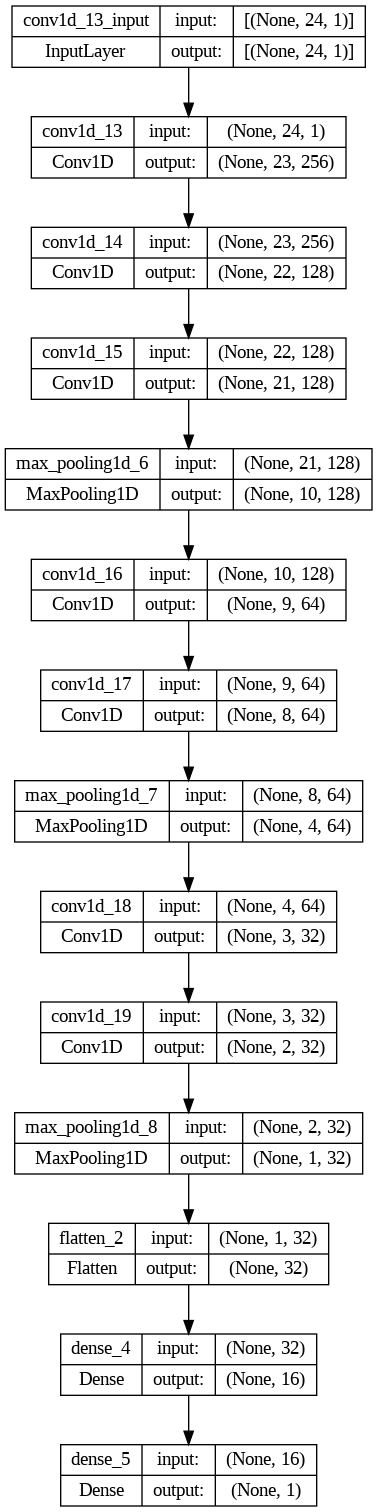

In [ ]:
# Model Architecture
plot_model(cnn_model_nong, to_file='cnn_model_nong.png', show_shapes=True, show_layer_names=True)

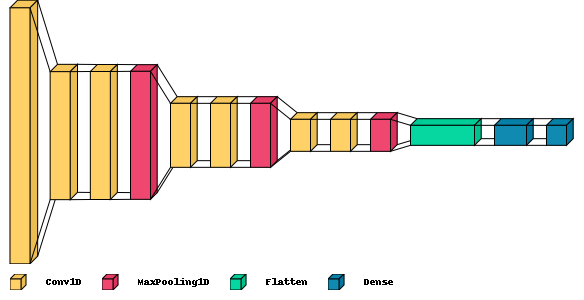

In [ ]:
# plt.figure(figsize=(12,4))
visualkeras.layered_view(
    cnn_model_nong, legend=True, 
    scale_xy=1,
    scale_z=2,
    spacing=20,
    background_fill='white',
    to_file=f'{RESULTS_PATH}/deep_cnn_pm25_Nongzhanguan_architecture.png')

In [ ]:
# callbacks (EarlyStopper to avoid overfitting)
early_stopper = EarlyStopping(
    monitor="loss",
    min_delta=0.05, # p-value
    patience=5,
    restore_best_weights=True,
)

# Fitting the model
history = cnn_model_nong.fit(
    deep_Xtrain_nong, deep_ytrain_nong, 
    batch_size=BATCH_SIZE,
    epochs=N_EPOCHS, 
    callbacks=[early_stopper],
    verbose=1)

Epoch 1/150
1402/1402 [==============================] - 8s 5ms/step - loss: 2101.9656 - mean_absolute_error: 27.8523 - mean_absolute_percentage_error: 73.3386 - mean_squared_error: 2101.9656 - root_mean_squared_error: 45.8472
Epoch 2/150
1402/1402 [==============================] - 9s 6ms/step - loss: 1391.3782 - mean_absolute_error: 22.8140 - mean_absolute_percentage_error: 59.6641 - mean_squared_error: 1391.3782 - root_mean_squared_error: 37.3012
Epoch 3/150
1402/1402 [==============================] - 7s 5ms/step - loss: 1389.6289 - mean_absolute_error: 22.3380 - mean_absolute_percentage_error: 58.5046 - mean_squared_error: 1389.6289 - root_mean_squared_error: 37.2777
Epoch 4/150
1402/1402 [==============================] - 10s 7ms/step - loss: 1300.8928 - mean_absolute_error: 21.7640 - mean_absolute_percentage_error: 57.2619 - mean_squared_error: 1300.8928 - root_mean_squared_error: 36.0679
Epoch 5/150
1402/1402 [==============================] - 8s 6ms/step - loss: 1261.8936 - me

In [ ]:
# history.history

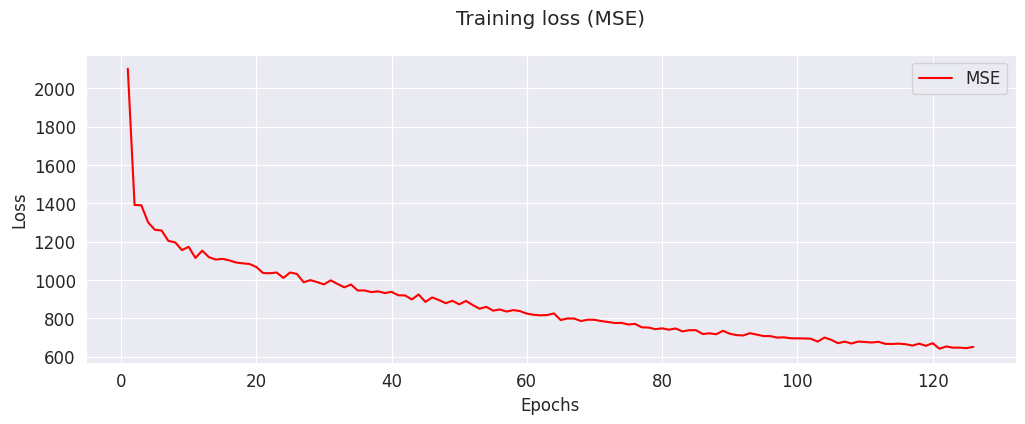

In [ ]:
# MSE (Loss)
plt.figure(figsize=(12,4))
plt.plot(range(1, len(history.history['loss']) + 1), history.history['loss'], label='MSE', color='r')
plt.title('Training loss (MSE)\n')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [ ]:
# Training Performances
fig, axs = plt.subplots(3, sharex=True, figsize=(12,5))
fig.suptitle('Training Results')

# MAE
axs[0].plot(range(1, len(history.history['loss']) + 1), history.history['mean_absolute_error'], 
            label='MAE', color='r')
axs[0].set_ylabel('MAE')
axs[0].legend()

# RMSE
axs[1].plot(range(1, len(history.history['loss']) + 1), history.history['root_mean_squared_error'], 
            label='RMSE', color='g')
axs[1].set_ylabel('RMSE')
axs[1].legend()

# MAPE
axs[2].plot(range(1, len(history.history['loss']) + 1), history.history['mean_absolute_percentage_error'], 
            label='MAPE', color='b')
axs[2].set_ylabel('MAPE')
axs[2].legend()
fig.tight_layout(pad=7.0)
plt.xlabel('Epochs')


Text(0.5, 21.722222222222214, 'Epochs')

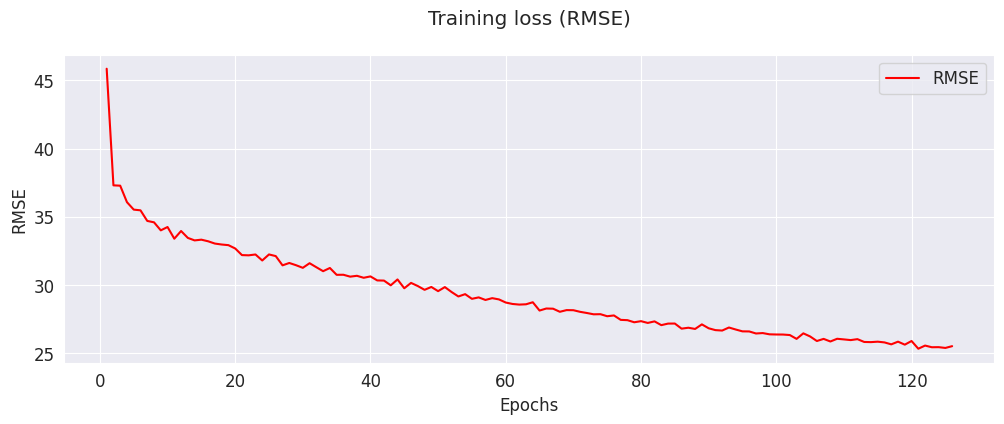

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(range(1, len(history.history['loss']) + 1), np.sqrt(history.history['loss']), label='RMSE', color='r')
plt.title('Training loss (RMSE)\n')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()

In [ ]:
# Saving the trained model
cnn_model_nong.save(f'{MODEL_PATH}/cnn_model_no_met_Nongzhanguan.h5')

#### Making Forecasts

In [ ]:
# Loading saved trained model
cnn_model_nong = load_model(f'{MODEL_PATH}/cnn_model_no_met_Nongzhanguan.h5')

##### 24 hrs (One day) Forecast
- 24-lags
- CNN

In [ ]:
steps = 24

In [ ]:
one_dayX =  deep_Xtest_nong[:steps]
one_dayy =  deep_ytest_nong[:steps]
predictions = cnn_model_nong.predict(one_dayX)
predictions[:5]

1/1 [==============================] - 7s 7s/step


array([[11.407351],
       [19.561842],
       [12.593401],
       [12.799086],
       [25.404957]], dtype=float32)

In [ ]:
preds_CNN = pd.Series(predictions.flatten(), index=Xtest_nong.index[:steps], name='PM2.5')
y_true = pd.Series(one_dayy, index=Xtest_nong.index[:steps], name='PM2.5')
preds_CNN.head()

datetime
2016-05-12 20:00:00    11.407351
2016-05-12 21:00:00    19.561842
2016-05-12 22:00:00    12.593401
2016-05-12 23:00:00    12.799086
2016-05-13 00:00:00    25.404957
Freq: H, Name: PM2.5, dtype: float32

In [ ]:
y_true.head()

datetime
2016-05-12 20:00:00     15.0
2016-05-12 21:00:00     23.0
2016-05-12 22:00:00     25.0
2016-05-12 23:00:00     45.0
2016-05-13 00:00:00    105.0
Freq: H, Name: PM2.5, dtype: float64

In [ ]:
plt.figure(figsize=(10,4))
pd.Series(deep_ytrain_nong[-steps*4:], index=Xtrain_nong.index[-steps*4:], name='PM2.5').plot(label='train', color='b')
y_true.plot(label='test', color='r')
preds_CNN.plot(label='predictions', color='black')
plt.title('CNN 24-hour (1-Day) Forecast of PM2.5 without Metereological Variables [Nongzhanguan]\n')
plt.legend

<function matplotlib.pyplot.legend(*args, **kwargs)>

In [ ]:
results_cnn_one_day = evaluate_model_performance(y_true, preds_CNN, label='cnn_one_day')
results_cnn_one_day

cnn_one_day
MAE             17.407
MSE            701.985
RMSE            26.495
R-Squared       -1.513
MAPE             0.452

##### One Week (168hrs) Forecast
- One week (24 * 7 = 168 hrs steps) into the future
- 24-lags
- CNN

In [ ]:
steps = 24 * 7

In [ ]:
one_weekX =  deep_Xtest_nong[:steps]
one_weeky =  deep_ytest_nong[:steps]
predictions = cnn_model_nong.predict(one_weekX)
predictions[:5]

6/6 [==============================] - 0s 29ms/step


array([[11.407351],
       [19.561842],
       [12.593401],
       [12.799086],
       [25.404957]], dtype=float32)

In [ ]:
preds_CNN = pd.Series(predictions.flatten(), index=Xtest_nong.index[:steps], name='PM2.5')
y_true = pd.Series(one_weeky, index=Xtest_nong.index[:steps], name='PM2.5')
preds_CNN.head()

datetime
2016-05-12 20:00:00    11.407351
2016-05-12 21:00:00    19.561842
2016-05-12 22:00:00    12.593401
2016-05-12 23:00:00    12.799086
2016-05-13 00:00:00    25.404957
Freq: H, Name: PM2.5, dtype: float32

In [ ]:
y_true.head()

datetime
2016-05-12 20:00:00     15.0
2016-05-12 21:00:00     23.0
2016-05-12 22:00:00     25.0
2016-05-12 23:00:00     45.0
2016-05-13 00:00:00    105.0
Freq: H, Name: PM2.5, dtype: float64

In [ ]:
plt.figure(figsize=(10,4))
pd.Series(deep_ytrain_nong[-steps*4:], index=Xtrain_nong.index[-steps*4:], name='PM2.5').plot(label='train', color='b')
y_true.plot(label='test', color='r')
preds_CNN.plot(label='predictions', color='black')
plt.title('CNN 1-Week Forecast of PM2.5 at 24-lags without \nMetereology Variables [Nongzhanguan]\n')
plt.legend()

In [ ]:
results_cnn_one_week = evaluate_model_performance(y_true, preds_CNN, label='cnn_one_week')
results_cnn_one_week

cnn_one_week
MAE              11.865
MSE             285.174
RMSE             16.887
R-Squared         0.550
MAPE              0.369

##### One Month (744 hrs) Forecast
- One month (24 * 31 = 744 hrs steps) into the future
- 24-lags
- CNN

In [ ]:
steps = 24 * 31

In [ ]:
one_monthX =  deep_Xtest_nong[:steps]
one_monthy =  deep_ytest_nong[:steps]
predictions = cnn_model_nong.predict(one_monthX)
predictions[:5]

24/24 [==============================] - 0s 3ms/step


array([[11.407351],
       [19.561842],
       [12.593401],
       [12.799086],
       [25.404957]], dtype=float32)

In [ ]:
preds_CNN = pd.Series(predictions.flatten(), index=Xtest_nong.index[:steps], name='PM2.5')
y_true = pd.Series(one_monthy, index=Xtest_nong.index[:steps], name='PM2.5')
preds_CNN.head()

datetime
2016-05-12 20:00:00    11.407351
2016-05-12 21:00:00    19.561842
2016-05-12 22:00:00    12.593401
2016-05-12 23:00:00    12.799086
2016-05-13 00:00:00    25.404957
Freq: H, Name: PM2.5, dtype: float32

In [ ]:
y_true.head()

datetime
2016-05-12 20:00:00     15.0
2016-05-12 21:00:00     23.0
2016-05-12 22:00:00     25.0
2016-05-12 23:00:00     45.0
2016-05-13 00:00:00    105.0
Freq: H, Name: PM2.5, dtype: float64

In [ ]:
plt.figure(figsize=(10,4))
pd.Series(deep_ytrain_nong[-steps:], index=Xtrain_nong.index[-steps:], name='PM2.5').plot(label='train', color='b')
y_true.plot(label='test', color='r')
preds_CNN.plot(label='predictions', color='black')
plt.title('CNN 1-Month Forecast of PM2.5 at 24-lags + No Metereology Variables [Nongzhanguan]\n')
plt.legend()

In [ ]:
results_cnn_one_month = evaluate_model_performance(y_true, preds_CNN, label='cnn_one_month')
results_cnn_one_month

cnn_one_month
MAE               13.807
MSE              380.111
RMSE              19.496
R-Squared          0.716
MAPE               0.411

In [ ]:
# Saving the trained model to disk
cnn_model_nong.save(f'{MODEL_PATH}/cnn_model_no_met_Nongzhanguan.h5')

##### Combined Results

In [ ]:
combined_results_cnn_no_met_24lags = pd.concat([
    results_cnn_one_day, 
    results_cnn_one_week, 
    results_cnn_one_month
], axis='columns')

combined_results_cnn_no_met_24lags

cnn_one_day  cnn_one_week  cnn_one_month
MAE             17.407        11.865         13.807
MSE            701.985       285.174        380.111
RMSE            26.495        16.887         19.496
R-Squared       -1.513         0.550          0.716
MAPE             0.452         0.369          0.411

In [ ]:
combined_results_cnn_no_met_24lags.iloc[[0,2],:].T.sort_values(by='MAE').T.plot.bar(
    title='Results of CNN Forecasts of PM2.5 trained without Metereological Variables [Nongzhanguan]\n', 
    figsize=(10,4), rot=0)

<Axes: title={'center': 'Results of CNN Forecasts of PM2.5 trained without Metereological Variables [Nongzhanguan]\n'}>

In [ ]:
combined_results_cnn_no_met_24lags.iloc[1,:].sort_values().plot.bar(
    title='MSE Results of CNN Forecasts of PM2.5 trained without Metereological Variables [Nongzhanguan]\n', 
    figsize=(10,4), rot=0)
plt.legend()

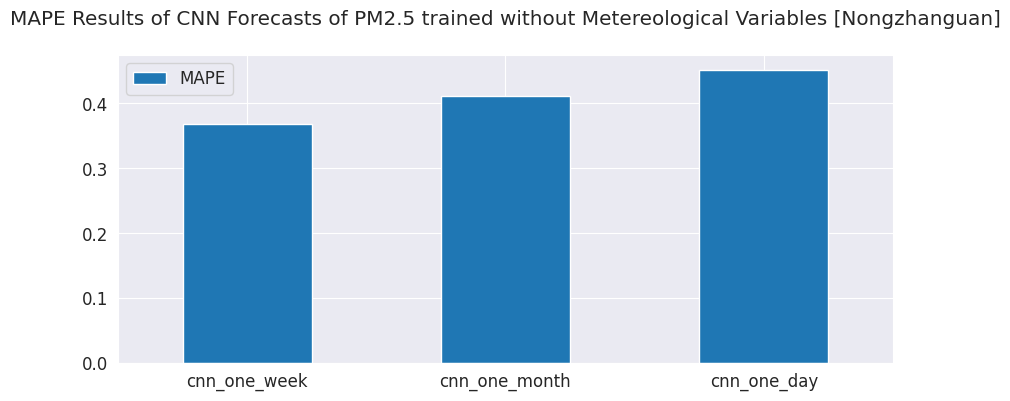

In [ ]:
combined_results_cnn_no_met_24lags.iloc[-1,:].sort_values().plot.bar(
    title='MAPE Results of CNN Forecasts of PM2.5 trained without Metereological Variables [Nongzhanguan]\n', 
    figsize=(10,4), rot=0)
plt.legend()

In [ ]:
combined_results_cnn_no_met_24lags.iloc[-2,:].sort_values().plot.bar(
    title='R-Squared Results of CNN Forecasts of PM2.5 trained without Metereological Variables [Nongzhanguan]\n', 
    figsize=(10,4), rot=0)
plt.legend()

In [ ]:
# Saving results
combined_results_cnn_no_met_24lags.to_csv(f'{RESULTS_PATH}/combined_results_cnn_no_met_24lags_Nongzhanguan.csv')

## CNN + All Exogenous Metereological Variables


- 1 day forecast (steps)
- 1 day (24 hrs) lag
- CNN
- Nongzhanguan station data

In [ ]:
TEST_SIZE = int((20 / 100) * len(y_pm25_nong)) # 20%
N_LAGS = 24
N_FEATURES = 6

#### Data Preparation and preprocessing

In [ ]:
# merged scaled data and target
data_pm25_exo = pd.concat([scaled_features_X_nong, y_pm25_nong], axis='columns')
data_pm25_exo.head()

TEMP      PRES      DEWP      RAIN        wd  \
datetime                                                                
2013-03-01 00:00:00 -1.236368  1.163818 -1.726439 -0.081398  1.598127   
2013-03-01 01:00:00 -1.253821  1.222261 -1.777120 -0.081398  1.384841   
2013-03-01 02:00:00 -1.297452  1.241742 -1.958126 -0.081398  1.598127   
2013-03-01 03:00:00 -1.314905  1.329407 -2.023288 -0.081398  1.811414   
2013-03-01 04:00:00 -1.358537  1.417073 -1.950885 -0.081398  1.598127   

                         WSPM  PM2.5  
datetime                              
2013-03-01 00:00:00  2.998406    5.0  
2013-03-01 01:00:00  1.592605    8.0  
2013-03-01 02:00:00  2.686006    3.0  
2013-03-01 03:00:00  2.373605    5.0  
2013-03-01 04:00:00  1.045905    5.0

In [ ]:
# Data Segmentation (80% training : 20% testing)

Xtrain_nong_exo, ytrain_nong_exo, Xtest_nong_exo, ytest_nong_exo = \
    split_train_test_series_multivariate_series(
        data_pm25_exo, test_size=TEST_SIZE)

In [ ]:
Xtrain_nong_exo.head(2)

TEMP      PRES      DEWP      RAIN        wd  \
datetime                                                                
2013-03-01 00:00:00 -1.236368  1.163818 -1.726439 -0.081398  1.598127   
2013-03-01 01:00:00 -1.253821  1.222261 -1.777120 -0.081398  1.384841   

                         WSPM  
datetime                       
2013-03-01 00:00:00  2.998406  
2013-03-01 01:00:00  1.592605

In [ ]:
ytrain_nong_exo.head(2)

datetime
2013-03-01 00:00:00    5.0
2013-03-01 01:00:00    8.0
Freq: H, Name: PM2.5, dtype: float64

In [ ]:
print(f'Shape of X: {features_X_nong.shape}')
print(f'Shape of Xtrain: {Xtrain_nong_exo.shape}')
print(f'Shape of Xtest: {Xtest_nong_exo.shape}')

Shape of X: (35064, 6)
Shape of Xtrain: (28052, 6)
Shape of Xtest: (7012, 6)


In [ ]:
deep_Xtrain_nong_exo, deep_ytrain_nong_exo = deep_prepare_X_y_for_CNN(
    X=Xtrain_nong_exo, y=ytrain_nong_exo, n_lags=N_LAGS, kind='multi_input')


deep_Xtest_nong_exo, deep_ytest_nong_exo = deep_prepare_X_y_for_CNN(
    X=Xtest_nong_exo, y=ytest_nong_exo, n_lags=N_LAGS, kind='multi_input')

In [ ]:
print(f'Shape of Xtrain: {Xtrain_nong_exo.shape}')
print(f'Shape of Deep-Xtrain: {deep_Xtrain_nong_exo.shape}')
print(f'Shape of Deep-Xtest: {deep_Xtest_nong_exo.shape}')
print(f'Shape of Deep-ytrain: {deep_ytrain_nong_exo.shape}')
print(f'Shape of Deep-ytest: {deep_ytest_nong_exo.shape}')

Shape of Xtrain: (28052, 6)
Shape of Deep-Xtrain: (28029, 24, 6)
Shape of Deep-Xtest: (6989, 24, 6)
Shape of Deep-ytrain: (28029,)
Shape of Deep-ytest: (6989,)


In [ ]:
for i in range(2):
    print(deep_Xtrain_nong_exo[i], deep_ytrain_nong_exo[i])

[[-1.23636817  1.16381753 -1.72643876 -0.08139834  1.59812742  2.99840581]
 [-1.25382083  1.22226104 -1.77712028 -0.08139834  1.38484101  1.5926049 ]
 [-1.29745248  1.2417422  -1.95812569 -0.08139834  1.59812742  2.68600561]
 [-1.31490514  1.32940746 -2.02328764 -0.08139834  1.81141384  2.37360541]
 [-1.35853679  1.41707272 -1.95088547 -0.08139834  1.59812742  1.04590454]
 [-1.40216844  1.45603505 -1.71919854 -0.08139834  1.38484101  0.42110414]
 [-1.41089477  1.52421914 -1.65403659 -0.08139834  1.38484101  0.26490404]
 [-1.31490514  1.65084673 -1.65403659 -0.08139834  1.59812742  0.88970444]
 [-1.21891551  1.73851199 -1.71195833 -0.08139834  1.38484101  2.13930525]
 [-1.1578312   1.74825257 -1.86400287 -0.08139834  1.81141384  2.84220571]
 [-1.07056791  1.71903082 -1.80608114 -0.08139834  1.81141384  2.60790556]
 [-0.93967296  1.68006849 -1.83504201 -0.08139834  1.59812742  2.68600561]
 [-0.84368333  1.56318148 -1.71195833 -0.08139834  0.95826818  2.13930525]
 [-0.75642004  1.4852568 

#### CNN Model Building

In [ ]:
N_EPOCHS = 150
BATCH_SIZE = 20
N_LAGS = 24
N_FEATURES = 6 # no of input variables

In [ ]:
# del cnn_model_nong_exo

In [ ]:
cnn_model_nong_exo = Sequential()

# input layer and hidden layer1
cnn_model_nong_exo.add(Conv1D(filters=256, kernel_size=2, activation='relu', 
                              input_shape=(N_LAGS, N_FEATURES)))
cnn_model_nong_exo.add(Conv1D(filters=128, kernel_size=2, activation='relu'))
cnn_model_nong_exo.add(Conv1D(filters=128, kernel_size=2, activation='relu'))
cnn_model_nong_exo.add(MaxPooling1D(pool_size=2))

cnn_model_nong_exo.add(Conv1D(filters=64, kernel_size=2, activation='relu'))
cnn_model_nong_exo.add(Conv1D(filters=64, kernel_size=2, activation='relu'))
cnn_model_nong_exo.add(MaxPooling1D(pool_size=2))

cnn_model_nong_exo.add(Conv1D(filters=32, kernel_size=2, activation='relu'))
cnn_model_nong_exo.add(Conv1D(filters=32, kernel_size=2, activation='relu'))
cnn_model_nong_exo.add(MaxPooling1D(pool_size=2))

cnn_model_nong_exo.add(Flatten())
cnn_model_nong_exo.add(Dense(units=16, activation='relu'))

# Output layer
cnn_model_nong_exo.add(Dense(units=1))

# optimizer (adam)
adam_optimizer = Adam(learning_rate=0.001)

cnn_model_nong_exo.compile(
    optimizer=adam_optimizer, 
    loss='mse', 
    metrics=[
        MeanAbsoluteError(),
        MeanAbsolutePercentageError(),
        MeanSquaredError(),
        RootMeanSquaredError()
    ]
  )


In [ ]:
cnn_model_nong_exo.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_33 (Conv1D)          (None, 23, 256)           3328      
                                                                 
 conv1d_34 (Conv1D)          (None, 22, 128)           65664     
                                                                 
 conv1d_35 (Conv1D)          (None, 21, 128)           32896     
                                                                 
 max_pooling1d_15 (MaxPoolin  (None, 10, 128)          0         
 g1D)                                                            
                                                                 
 conv1d_36 (Conv1D)          (None, 9, 64)             16448     
                                                                 
 conv1d_37 (Conv1D)          (None, 8, 64)             8256      
                                                      

In [ ]:
# Model Architecture
plot_model(cnn_model_nong_exo, to_file='cnn_model_nong_exo_met_vars_added_multi_input.png', show_shapes=True, show_layer_names=True)

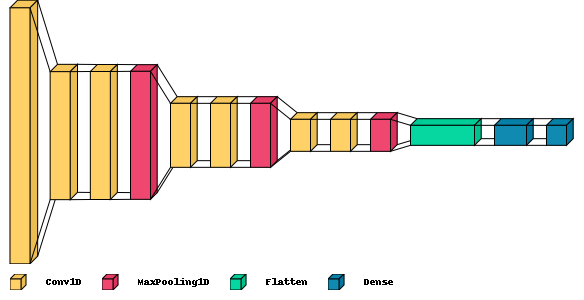

In [ ]:
# plt.figure(figsize=(12,4))
visualkeras.layered_view(
    cnn_model_nong_exo, legend=True, 
    scale_xy=1,
    scale_z=2,
    spacing=20,
    background_fill='white',
    to_file=f'{RESULTS_PATH}/deep_cnn_pm25_with_met_var_Nongzhanguan_architecture.png')

In [ ]:
# callbacks (EarlyStopper to avoid overfitting)
early_stopper = EarlyStopping(
    monitor="loss",
    min_delta=0.05,  # p-value (significance)
    patience=5,
    restore_best_weights=True,
)

# Fitting the model
history = cnn_model_nong_exo.fit(
    deep_Xtrain_nong_exo, deep_ytrain_nong_exo, 
    batch_size=BATCH_SIZE,
    epochs=N_EPOCHS, 
    callbacks=[early_stopper],
    verbose=1)

Epoch 1/150
1402/1402 [==============================] - 9s 6ms/step - loss: 4659.1206 - mean_absolute_error: 46.8336 - mean_absolute_percentage_error: 138.8483 - mean_squared_error: 4659.1201 - root_mean_squared_error: 68.2577
Epoch 2/150
1402/1402 [==============================] - 8s 6ms/step - loss: 3315.3748 - mean_absolute_error: 38.1471 - mean_absolute_percentage_error: 92.6727 - mean_squared_error: 3315.3745 - root_mean_squared_error: 57.5793
Epoch 3/150
1402/1402 [==============================] - 8s 6ms/step - loss: 3009.8196 - mean_absolute_error: 36.2818 - mean_absolute_percentage_error: 85.3904 - mean_squared_error: 3009.8196 - root_mean_squared_error: 54.8618
Epoch 4/150
1402/1402 [==============================] - 8s 6ms/step - loss: 2745.6196 - mean_absolute_error: 34.5084 - mean_absolute_percentage_error: 80.1390 - mean_squared_error: 2745.6196 - root_mean_squared_error: 52.3987
Epoch 5/150
1402/1402 [==============================] - 8s 6ms/step - loss: 2547.6055 - me

In [ ]:
# history.history
best_epoch = history.history['loss'].index(min(history.history['loss']))
print('TRAINING RESULT SUMMARY')
print('-----------------------\n')
print(f'Best Epoch: {best_epoch + 1}')
print(f'MAE: {history.history["mean_absolute_error"][best_epoch]}')
print(f'MSE: {history.history["mean_squared_error"][best_epoch]}')
print(f'RMSE: {history.history["root_mean_squared_error"][best_epoch]}')
print(f'MAPE: {history.history["mean_absolute_percentage_error"][best_epoch]}')


TRAINING RESULT SUMMARY
-----------------------

Best Epoch: 148
MAE: 6.766719341278076
MSE: 84.7916259765625
RMSE: 9.208236694335938
MAPE: 20.44727325439453


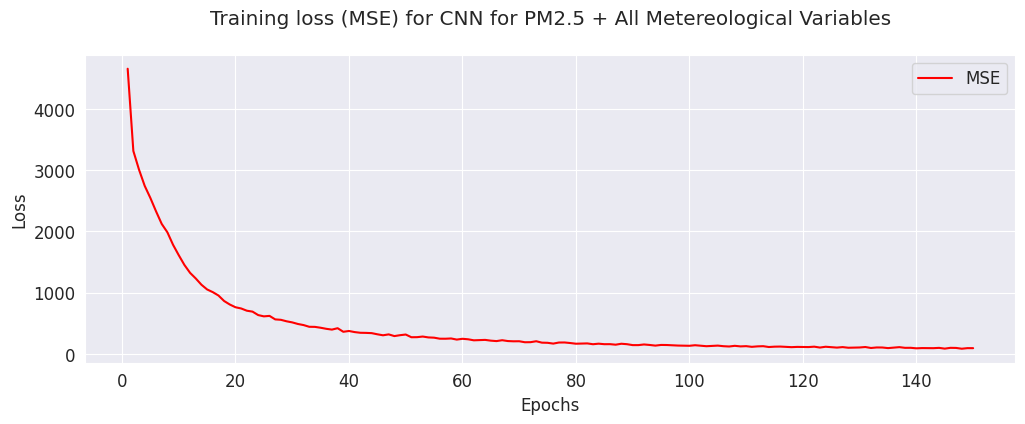

In [ ]:
# MSE (Loss)
plt.figure(figsize=(12,4))
plt.plot(range(1, len(history.history['loss']) + 1), history.history['loss'], 
         label='MSE', color='r')
plt.title('Training loss (MSE) for CNN for PM2.5 + All Metereological Variables\n')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [ ]:
# Training Performances
fig, axs = plt.subplots(3, sharex=True, figsize=(12,5))
fig.suptitle('Training Results (CNN for PM2.5 + All Met Variables) [Nongzhaguan]')

# MAE
axs[0].plot(range(1, len(history.history['loss']) + 1), history.history['mean_absolute_error'], 
            label='MAE', color='r')
axs[0].set_ylabel('MAE')
axs[0].legend()

# RMSE
axs[1].plot(range(1, len(history.history['loss']) + 1), history.history['root_mean_squared_error'], 
            label='RMSE', color='g')
axs[1].set_ylabel('RMSE')
axs[1].legend()

# MAPE
axs[2].plot(range(1, len(history.history['loss']) + 1), history.history['mean_absolute_percentage_error'], 
            label='MAPE', color='b')
axs[2].set_ylabel('MAPE')
axs[2].legend()
fig.tight_layout(pad=7.0)
plt.xlabel('Epochs')


Text(0.5, 21.722222222222214, 'Epochs')

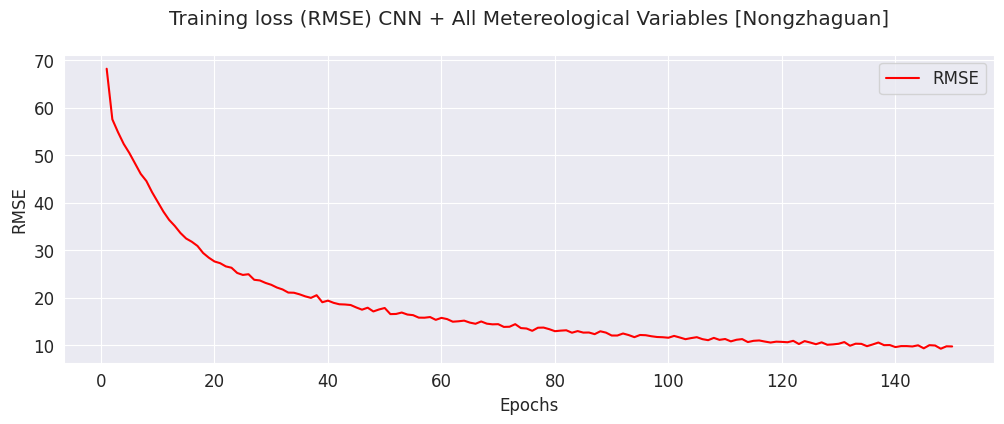

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(range(1, len(history.history['loss']) + 1), np.sqrt(history.history['loss']), label='RMSE', color='r')
plt.title('Training loss (RMSE) CNN + All Metereological Variables [Nongzhaguan]\n')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()

In [ ]:
# cnn_model_nong_exo.save(f'{MODEL_PATH}/cnn_model_pm25_with_met_vars_Nongzhanguan.h5')

#### Making Forecasts

In [ ]:
# Loading saved trained model
cnn_model_nong_exo = load_model(f'{MODEL_PATH}/cnn_model_pm25_with_met_vars_Nongzhanguan.h5')

##### 24 hrs (One day) Forecast
- 24-lags
- CNN

In [ ]:
steps = 24

In [ ]:
one_dayX =  deep_Xtest_nong_exo[:steps]
one_dayy =  deep_ytest_nong_exo[:steps]
predictions = cnn_model_nong_exo.predict(one_dayX)
predictions[:5]

1/1 [==============================] - 0s 175ms/step


array([[39.9145  ],
       [62.19547 ],
       [53.0082  ],
       [62.6903  ],
       [67.453545]], dtype=float32)

In [ ]:
preds_CNN = pd.Series(predictions.flatten(), index=Xtest_nong_exo.index[:steps], name='PM2.5')
y_true = pd.Series(one_dayy, index=Xtest_nong_exo.index[:steps], name='PM2.5')
preds_CNN.head()

datetime
2016-05-12 20:00:00    39.914501
2016-05-12 21:00:00    62.195469
2016-05-12 22:00:00    53.008202
2016-05-12 23:00:00    62.690300
2016-05-13 00:00:00    67.453545
Freq: H, Name: PM2.5, dtype: float32

In [ ]:
y_true.head()

datetime
2016-05-12 20:00:00    23.0
2016-05-12 21:00:00    29.0
2016-05-12 22:00:00    29.0
2016-05-12 23:00:00    36.0
2016-05-13 00:00:00    37.0
Freq: H, Name: PM2.5, dtype: float64

<function matplotlib.pyplot.legend(*args, **kwargs)>

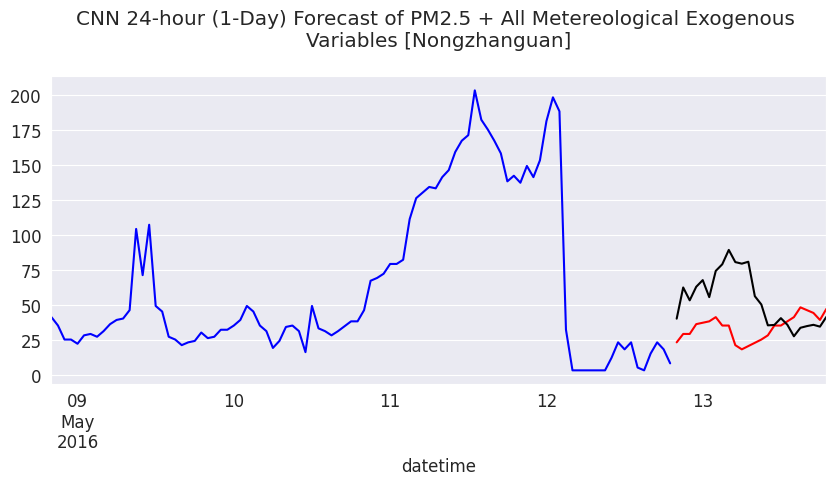

In [ ]:
plt.figure(figsize=(10,4))
pd.Series(deep_ytrain_nong_exo[-steps*4:], index=Xtrain_nong_exo.index[-steps*4:], name='PM2.5').plot(label='train', color='b')
y_true.plot(label='test', color='r')
preds_CNN.plot(label='predictions', color='black')
plt.title('CNN 24-hour (1-Day) Forecast of PM2.5 + All Metereological Exogenous \nVariables [Nongzhanguan]\n')
plt.legend

In [ ]:
results_cnn_1_day_forecast_all_met_24lags = evaluate_model_performance(y_true, preds_CNN, label='cnn_one_day')
results_cnn_1_day_forecast_all_met_24lags

cnn_one_day
MAE             24.688
MSE            966.668
RMSE            31.091
R-Squared      -11.831
MAPE             0.908

##### One Week (168hrs) Forecast
- One week (24 * 7 = 168 hrs steps) into the future
- 24-lags
- CNN

In [ ]:
steps = 24 * 7

In [ ]:
one_weekX =  deep_Xtest_nong_exo[:steps]
one_weeky =  deep_ytest_nong_exo[:steps]
predictions = cnn_model_nong_exo.predict(one_weekX)
predictions[:5]

6/6 [==============================] - 0s 2ms/step


array([[39.9145  ],
       [62.19547 ],
       [53.0082  ],
       [62.6903  ],
       [67.453545]], dtype=float32)

In [ ]:
preds_CNN = pd.Series(predictions.flatten(), index=Xtest_nong_exo.index[:steps], name='PM2.5')
y_true = pd.Series(one_weeky, index=Xtest_nong_exo.index[:steps], name='PM2.5')
preds_CNN.head()

datetime
2016-05-12 20:00:00    39.914501
2016-05-12 21:00:00    62.195469
2016-05-12 22:00:00    53.008202
2016-05-12 23:00:00    62.690300
2016-05-13 00:00:00    67.453545
Freq: H, Name: PM2.5, dtype: float32

In [ ]:
y_true.head()

datetime
2016-05-12 20:00:00    23.0
2016-05-12 21:00:00    29.0
2016-05-12 22:00:00    29.0
2016-05-12 23:00:00    36.0
2016-05-13 00:00:00    37.0
Freq: H, Name: PM2.5, dtype: float64

In [ ]:
plt.figure(figsize=(10,4))
pd.Series(deep_ytrain_nong_exo[-steps*4:], index=Xtrain_nong_exo.index[-steps*4:], 
          name='PM2.5').plot(label='train', color='b')
y_true.plot(label='test', color='r')
preds_CNN.plot(label='predictions', color='black')
plt.title('CNN 168 hours (1-Week) Forecast of PM2.5 at 24-lags trained on \nAll Metereology Variables [Nongzhanguan]\n')
plt.legend()

In [ ]:
results_cnn_1_week_forecast_all_met_24lags = evaluate_model_performance(
    y_true, preds_CNN, label='cnn_one_week')

results_cnn_1_week_forecast_all_met_24lags

cnn_one_week
MAE              22.595
MSE             831.210
RMSE             28.831
R-Squared         0.075
MAPE              0.741

##### One Month (744 hrs) Forecast
- One month (24 * 31 = 744 hrs steps) into the future
- 24-lags
- CNN

In [ ]:
steps = 24 * 31

In [ ]:
one_monthX =  deep_Xtest_nong_exo[:steps]
one_monthy =  deep_ytest_nong_exo[:steps]
predictions = cnn_model_nong_exo.predict(one_monthX)
predictions[:5]

24/24 [==============================] - 0s 3ms/step


array([[39.9145  ],
       [62.19547 ],
       [53.0082  ],
       [62.6903  ],
       [67.453545]], dtype=float32)

In [ ]:
preds_CNN = pd.Series(predictions.flatten(), index=Xtest_nong_exo.index[:steps], name='PM2.5')
y_true = pd.Series(one_monthy, index=Xtest_nong_exo.index[:steps], name='PM2.5')
preds_CNN.head()

datetime
2016-05-12 20:00:00    39.914501
2016-05-12 21:00:00    62.195469
2016-05-12 22:00:00    53.008202
2016-05-12 23:00:00    62.690300
2016-05-13 00:00:00    67.453545
Freq: H, Name: PM2.5, dtype: float32

In [ ]:
y_true.head()

datetime
2016-05-12 20:00:00    23.0
2016-05-12 21:00:00    29.0
2016-05-12 22:00:00    29.0
2016-05-12 23:00:00    36.0
2016-05-13 00:00:00    37.0
Freq: H, Name: PM2.5, dtype: float64

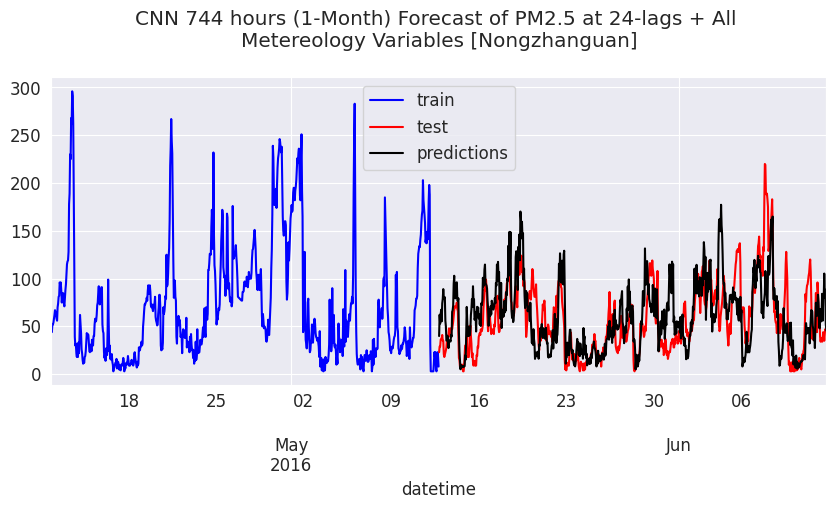

In [ ]:
plt.figure(figsize=(10,4))
pd.Series(deep_ytrain_nong_exo[-steps:], index=Xtrain_nong_exo.index[-steps:], name='PM2.5').plot(label='train', color='b')
y_true.plot(label='test', color='r')
preds_CNN.plot(label='predictions', color='black')
plt.title('CNN 744 hours (1-Month) Forecast of PM2.5 at 24-lags + All \nMetereology Variables [Nongzhanguan]\n')
plt.legend()

In [ ]:
results_cnn_1_month_forecast_all_met_24lags = evaluate_model_performance(y_true, preds_CNN, label='cnn_one_month')
results_cnn_1_month_forecast_all_met_24lags

cnn_one_month
MAE               23.857
MSE             1044.824
RMSE              32.324
R-Squared          0.213
MAPE               0.685

##### Combined Results

In [ ]:
cnn_results_pm25_with_all_met_vars = pd.concat([
    results_cnn_1_day_forecast_all_met_24lags, 
    results_cnn_1_week_forecast_all_met_24lags,
    results_cnn_1_month_forecast_all_met_24lags
    ], axis='columns')

cnn_results_pm25_with_all_met_vars

cnn_one_day  cnn_one_week  cnn_one_month
MAE             24.688        22.595         23.857
MSE            966.668       831.210       1044.824
RMSE            31.091        28.831         32.324
R-Squared      -11.831         0.075          0.213
MAPE             0.908         0.741          0.685

<Axes: title={'center': 'Results of CNN Forecasts of PM2.5 trained with All Metereological Variables [Nongzhanguan]\n'}>

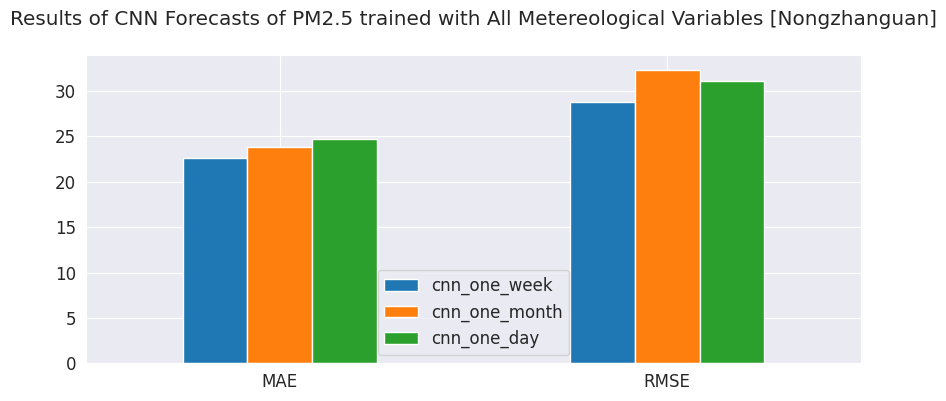

In [ ]:
cnn_results_pm25_with_all_met_vars.iloc[[0,2],:].T.sort_values(by='MAE').T.plot.bar(
    title='Results of CNN Forecasts of PM2.5 trained with All Metereological Variables [Nongzhanguan]\n', 
    figsize=(10,4), rot=0)

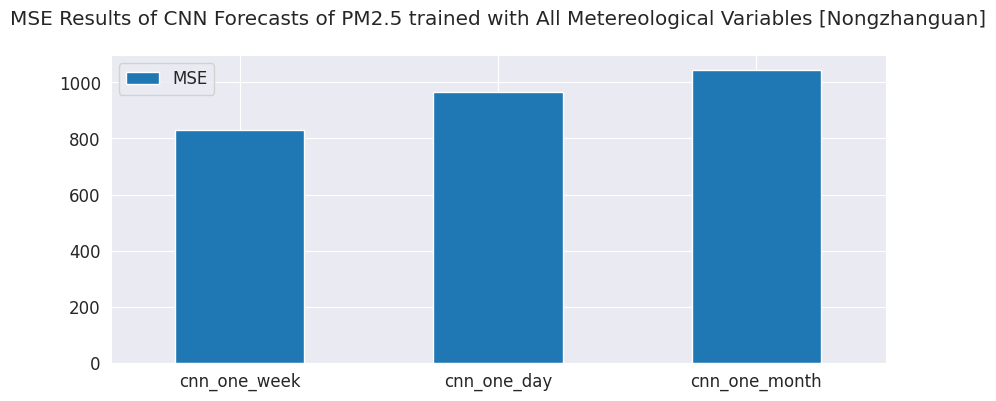

In [ ]:
cnn_results_pm25_with_all_met_vars.iloc[1,:].sort_values().plot.bar(
    title='MSE Results of CNN Forecasts of PM2.5 trained with All Metereological Variables [Nongzhanguan]\n', 
    figsize=(10,4), rot=0)
plt.legend()

In [ ]:
cnn_results_pm25_with_all_met_vars.iloc[-1,:].sort_values().plot.bar(
    title='MAPE Results of CNN Forecasts of PM2.5 trained with All Metereological Variables [Nongzhanguan]\n', 
    figsize=(10,4), rot=0)
plt.legend()

In [ ]:
cnn_results_pm25_with_all_met_vars.iloc[-2,:].sort_values().plot.bar(
    title='R-Squared Results of CNN Forecasts of PM2.5 trained with All Metereological Variables [Nongzhanguan]\n', 
    figsize=(10,4), rot=0)
plt.legend()

In [ ]:
# Saving results
cnn_results_pm25_with_all_met_vars.to_csv(f'{RESULTS_PATH}/cnn_results_pm25_with_all_met_vars_24lags_Nongzhanguan.csv')

## CNN + [Selected] Exogenous Metereological Variables

- 1 day (24 hrs) lag
- CNN
- Nongzhanguan station data

In [ ]:
TEST_SIZE = int((20 / 100) * len(y_pm25_nong)) # 20%
N_LAGS = 24
N_FEATURES = 3

#### Data Preparation and preprocessing

In [ ]:
features_X_nong.corrwith(y_pm25_nong).sort_values()

WSPM   -0.301098
wd     -0.240711
TEMP   -0.173362
RAIN   -0.022705
PRES    0.028121
DEWP    0.097226
dtype: float64

In [ ]:
# merged scaled data and target
data_pm25_exo_sel = pd.concat([scaled_features_X_nong[['WSPM', 'wd', 'TEMP']], y_pm25_nong], axis='columns')
data_pm25_exo_sel.head()

WSPM        wd      TEMP  PM2.5
datetime                                                
2013-03-01 00:00:00  2.998406  1.598127 -1.236368    5.0
2013-03-01 01:00:00  1.592605  1.384841 -1.253821    8.0
2013-03-01 02:00:00  2.686006  1.598127 -1.297452    3.0
2013-03-01 03:00:00  2.373605  1.811414 -1.314905    5.0
2013-03-01 04:00:00  1.045905  1.598127 -1.358537    5.0

In [ ]:
# Data Segmentation (80% training : 20% testing)

Xtrain_nong_exo_sel, ytrain_nong_exo_sel, Xtest_nong_exo_sel, ytest_nong_exo_sel = \
    split_train_test_series_multivariate_series(
        data_pm25_exo_sel, test_size=TEST_SIZE)

In [ ]:
Xtrain_nong_exo_sel.head(2)

WSPM        wd      TEMP
datetime                                         
2013-03-01 00:00:00  2.998406  1.598127 -1.236368
2013-03-01 01:00:00  1.592605  1.384841 -1.253821

In [ ]:
ytrain_nong_exo_sel.head(2)

datetime
2013-03-01 00:00:00    5.0
2013-03-01 01:00:00    8.0
Freq: H, Name: PM2.5, dtype: float64

In [ ]:
print(f'Shape of X: {scaled_features_X_nong.shape}')
print(f'Shape of Xtrain: {Xtrain_nong_exo_sel.shape}')
print(f'Shape of Xtest: {Xtest_nong_exo_sel.shape}')

Shape of X: (35064, 6)
Shape of Xtrain: (28052, 3)
Shape of Xtest: (7012, 3)


In [ ]:
deep_Xtrain_nong_exo_sel, deep_ytrain_nong_exo_sel = deep_prepare_X_y_for_CNN(
    X=Xtrain_nong_exo_sel, y=ytrain_nong_exo_sel, n_lags=N_LAGS, kind='multi_input')


deep_Xtest_nong_exo_sel, deep_ytest_nong_exo_sel = deep_prepare_X_y_for_CNN(
    X=Xtest_nong_exo_sel, y=ytest_nong_exo_sel, n_lags=N_LAGS, kind='multi_input')

In [ ]:
print(f'Shape of Xtrain: {Xtrain_nong_exo_sel.shape}')
print(f'Shape of Deep-Xtrain: {deep_Xtrain_nong_exo_sel.shape}')
print(f'Shape of Deep-Xtest: {deep_Xtest_nong_exo_sel.shape}')
print(f'Shape of Deep-ytrain: {deep_ytrain_nong_exo_sel.shape}')
print(f'Shape of Deep-ytest: {deep_ytest_nong_exo_sel.shape}')

Shape of Xtrain: (28052, 3)
Shape of Deep-Xtrain: (28029, 24, 3)
Shape of Deep-Xtest: (6989, 24, 3)
Shape of Deep-ytrain: (28029,)
Shape of Deep-ytest: (6989,)


In [ ]:
for i in range(2):
    print(deep_Xtrain_nong_exo_sel[i], deep_ytrain_nong_exo_sel[i])

[[ 2.99840581  1.59812742 -1.23636817]
 [ 1.5926049   1.38484101 -1.25382083]
 [ 2.68600561  1.59812742 -1.29745248]
 [ 2.37360541  1.81141384 -1.31490514]
 [ 1.04590454  1.59812742 -1.35853679]
 [ 0.42110414  1.38484101 -1.40216844]
 [ 0.26490404  1.38484101 -1.41089477]
 [ 0.88970444  1.59812742 -1.31490514]
 [ 2.13930525  1.38484101 -1.21891551]
 [ 2.84220571  1.81141384 -1.1578312 ]
 [ 2.60790556  1.81141384 -1.07056791]
 [ 2.68600561  1.59812742 -0.93967296]
 [ 2.13930525  0.95826818 -0.84368333]
 [ 2.0612052   1.38484101 -0.75642004]
 [ 1.67070495  1.38484101 -0.65170408]
 [ 0.18680399  1.59812742 -0.66915674]
 [-0.04749616  1.81141384 -0.70406206]
 [ 1.2802047   1.81141384 -0.80877801]
 [-1.06279682  1.59812742 -0.91349397]
 [-0.59419652  1.81141384 -0.93094663]
 [-0.51609647 -0.96130956 -1.05311525]
 [-0.67229657 -1.17459598 -1.12292588]
 [-0.04749616 -0.96130956 -1.18401019]
 [ 0.18680399 -1.17459598 -1.23636817]] 6.0
[[ 1.5926049   1.38484101 -1.25382083]
 [ 2.68600561  1.598

#### CNN Model Building

In [ ]:
N_EPOCHS = 150
BATCH_SIZE = 20

N_LAGS = 24
N_FEATURES = 3 # no of input variables

In [ ]:
# del cnn_model_nong_exo_sel

In [ ]:
cnn_model_nong_exo_sel = Sequential()

# input layer and hidden layer1
cnn_model_nong_exo_sel.add(Conv1D(filters=256, kernel_size=2, activation='relu', 
                              input_shape=(N_LAGS, N_FEATURES)))
cnn_model_nong_exo_sel.add(Conv1D(filters=128, kernel_size=2, activation='relu'))
cnn_model_nong_exo_sel.add(Conv1D(filters=128, kernel_size=2, activation='relu'))
cnn_model_nong_exo_sel.add(MaxPooling1D(pool_size=2))

cnn_model_nong_exo_sel.add(Conv1D(filters=64, kernel_size=2, activation='relu'))
cnn_model_nong_exo_sel.add(Conv1D(filters=64, kernel_size=2, activation='relu'))
cnn_model_nong_exo_sel.add(MaxPooling1D(pool_size=2))

cnn_model_nong_exo_sel.add(Conv1D(filters=32, kernel_size=2, activation='relu'))
cnn_model_nong_exo_sel.add(Conv1D(filters=32, kernel_size=2, activation='relu'))
cnn_model_nong_exo_sel.add(MaxPooling1D(pool_size=2))

cnn_model_nong_exo_sel.add(Flatten())
cnn_model_nong_exo_sel.add(Dense(units=16, activation='relu'))

# Output layer
cnn_model_nong_exo_sel.add(Dense(units=1))

# optimizer (adam)
adam_optimizer = Adam(learning_rate=0.001)

cnn_model_nong_exo_sel.compile(
    optimizer=adam_optimizer, 
    loss='mse', 
    metrics=[
        MeanAbsoluteError(),
        MeanAbsolutePercentageError(),
        MeanSquaredError(),
        RootMeanSquaredError()
    ]
  )


In [ ]:
cnn_model_nong_exo_sel.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_21 (Conv1D)          (None, 23, 256)           1792      
                                                                 
 conv1d_22 (Conv1D)          (None, 22, 128)           65664     
                                                                 
 conv1d_23 (Conv1D)          (None, 21, 128)           32896     
                                                                 
 max_pooling1d_9 (MaxPooling  (None, 10, 128)          0         
 1D)                                                             
                                                                 
 conv1d_24 (Conv1D)          (None, 9, 64)             16448     
                                                                 
 conv1d_25 (Conv1D)          (None, 8, 64)             8256      
                                                      

In [ ]:
# Model Architecture
plot_model(cnn_model_nong_exo_sel, to_file='cnn_model_nong_with_selected_exo_met_vars_added_multi_input.png', show_shapes=True, show_layer_names=True)

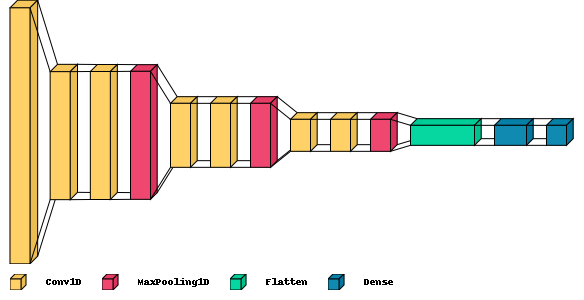

In [ ]:
# plt.figure(figsize=(12,4))
visualkeras.layered_view(
    cnn_model_nong_exo_sel, legend=True, 
    scale_xy=1,
    scale_z=2,
    spacing=20,
    background_fill='white',
    to_file=f'{RESULTS_PATH}/deep_cnn_pm25_with_selected_met_vars_Nongzhanguan_architecture.png')

In [ ]:
# callbacks (EarlyStopper to avoid overfitting)
early_stopper = EarlyStopping(
    monitor="loss",
    min_delta=0.05,  # p-value (significance)
    patience=5,
    restore_best_weights=True,
)

# Fitting the model
history = cnn_model_nong_exo_sel.fit(
    deep_Xtrain_nong_exo_sel, deep_ytrain_nong_exo_sel, 
    batch_size=BATCH_SIZE,
    epochs=N_EPOCHS, 
    callbacks=[early_stopper],
    verbose=1)

Epoch 1/150
1402/1402 [==============================] - 16s 5ms/step - loss: 5032.9248 - mean_absolute_error: 48.4021 - mean_absolute_percentage_error: 139.5984 - mean_squared_error: 5032.9248 - root_mean_squared_error: 70.9431
Epoch 2/150
1402/1402 [==============================] - 9s 6ms/step - loss: 4163.5796 - mean_absolute_error: 42.7228 - mean_absolute_percentage_error: 105.4833 - mean_squared_error: 4163.5796 - root_mean_squared_error: 64.5258
Epoch 3/150
1402/1402 [==============================] - 7s 5ms/step - loss: 3902.7136 - mean_absolute_error: 40.9545 - mean_absolute_percentage_error: 97.2744 - mean_squared_error: 3902.7136 - root_mean_squared_error: 62.4717
Epoch 4/150
1402/1402 [==============================] - 9s 6ms/step - loss: 3668.2620 - mean_absolute_error: 39.5143 - mean_absolute_percentage_error: 92.4246 - mean_squared_error: 3668.2620 - root_mean_squared_error: 60.5662
Epoch 5/150
1402/1402 [==============================] - 7s 5ms/step - loss: 3524.0054 - 

In [ ]:
# history.history
best_epoch = history.history['loss'].index(min(history.history['loss']))
print('TRAINING RESULT SUMMARY')
print('-----------------------\n')
print(f'Best Epoch: {best_epoch + 1}')
print(f'MAE: {history.history["mean_absolute_error"][best_epoch]}')
print(f'MSE: {history.history["mean_squared_error"][best_epoch]}')
print(f'RMSE: {history.history["root_mean_squared_error"][best_epoch]}')
print(f'MAPE: {history.history["mean_absolute_percentage_error"][best_epoch]}')


TRAINING RESULT SUMMARY
-----------------------

Best Epoch: 115
MAE: 7.878166198730469
MSE: 113.05329132080078
RMSE: 10.632652282714844
MAPE: 24.33820152282715


In [ ]:
# MSE (Loss)
plt.figure(figsize=(12,4))
plt.plot(range(1, len(history.history['loss']) + 1), history.history['loss'], 
         label='MSE', color='r')
plt.title('Training loss (MSE) for CNN for PM2.5 + [Selected] Metereological Variables\n')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

Text(0.5, 21.722222222222214, 'Epochs')

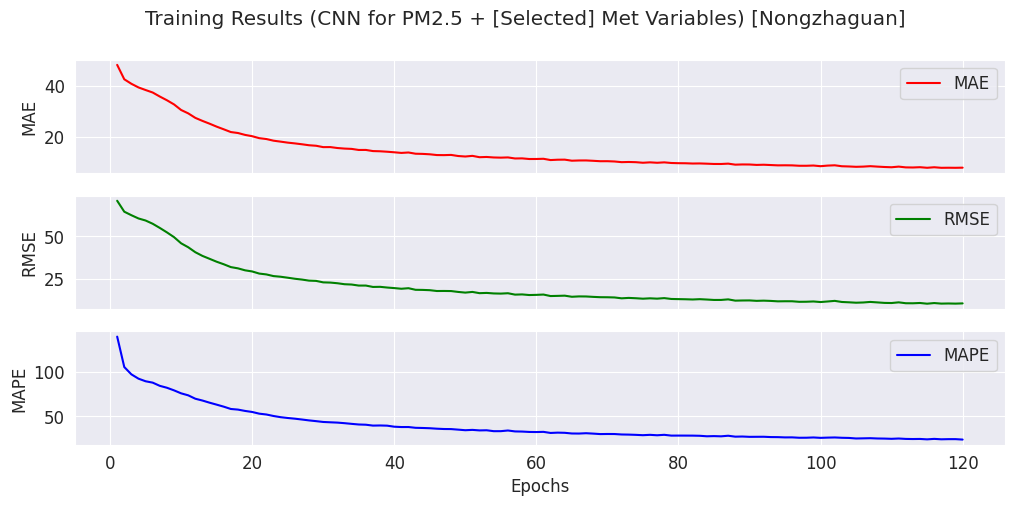

In [ ]:
# Training Performances
fig, axs = plt.subplots(3, sharex=True, figsize=(12,5))
fig.suptitle('Training Results (CNN for PM2.5 + [Selected] Met Variables) [Nongzhaguan]')

# MAE
axs[0].plot(range(1, len(history.history['loss']) + 1), history.history['mean_absolute_error'], 
            label='MAE', color='r')
axs[0].set_ylabel('MAE')
axs[0].legend()

# RMSE
axs[1].plot(range(1, len(history.history['loss']) + 1), history.history['root_mean_squared_error'], 
            label='RMSE', color='g')
axs[1].set_ylabel('RMSE')
axs[1].legend()

# MAPE
axs[2].plot(range(1, len(history.history['loss']) + 1), history.history['mean_absolute_percentage_error'], 
            label='MAPE', color='b')
axs[2].set_ylabel('MAPE')
axs[2].legend()
fig.tight_layout(pad=7.0)
plt.xlabel('Epochs')


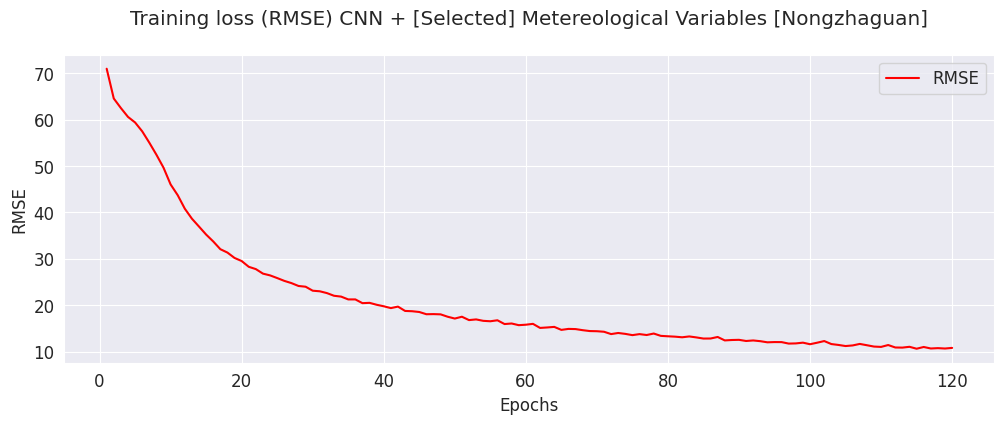

In [ ]:
# Training RMSE
plt.figure(figsize=(12,4))
plt.plot(range(1, len(history.history['loss']) + 1), np.sqrt(history.history['loss']), label='RMSE', color='r')
plt.title('Training loss (RMSE) CNN + [Selected] Metereological Variables [Nongzhaguan]\n')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()

In [ ]:
# saving the trained model
cnn_model_nong_exo_sel.save(f'{MODEL_PATH}/cnn_model_pm25_with_selected_met_vars_Nongzhanguan.h5')

#### Making Forecasts

In [ ]:
# Loading saved trained model
cnn_model_nong_exo_sel = load_model(f'{MODEL_PATH}/cnn_model_pm25_with_selected_met_vars_Nongzhanguan.h5')

##### 24 hrs (One day) Forecast
- 24-lags
- CNN

In [ ]:
steps = 24

In [ ]:
one_dayX =  deep_Xtest_nong_exo_sel[:steps]
one_dayy =  deep_ytest_nong_exo_sel[:steps]
predictions = cnn_model_nong_exo_sel.predict(one_dayX)
predictions[:5]

1/1 [==============================] - 0s 162ms/step


array([[ 82.41876 ],
       [104.25527 ],
       [ 80.538086],
       [ 83.124664],
       [ 69.31162 ]], dtype=float32)

In [ ]:
preds_CNN = pd.Series(predictions.flatten(), index=Xtest_nong_exo_sel.index[:steps], name='PM2.5')
y_true = pd.Series(one_dayy, index=Xtest_nong_exo_sel.index[:steps], name='PM2.5')
preds_CNN.head()

datetime
2016-05-12 20:00:00     82.418762
2016-05-12 21:00:00    104.255272
2016-05-12 22:00:00     80.538086
2016-05-12 23:00:00     83.124664
2016-05-13 00:00:00     69.311623
Freq: H, Name: PM2.5, dtype: float32

In [ ]:
y_true.head()

datetime
2016-05-12 20:00:00    23.0
2016-05-12 21:00:00    29.0
2016-05-12 22:00:00    29.0
2016-05-12 23:00:00    36.0
2016-05-13 00:00:00    37.0
Freq: H, Name: PM2.5, dtype: float64

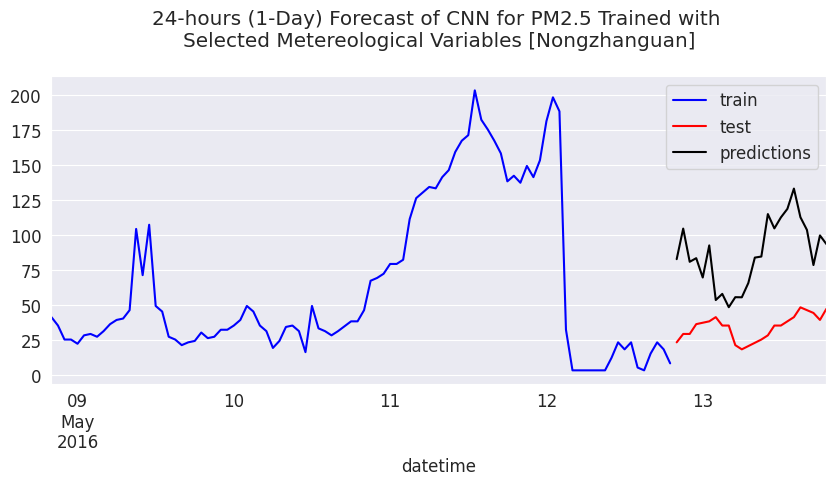

In [ ]:
plt.figure(figsize=(10,4))
pd.Series(deep_ytrain_nong_exo_sel[-steps*4:], index=Xtrain_nong_exo_sel.index[-steps*4:], name='PM2.5').plot(label='train', color='b')
y_true.plot(label='test', color='r')
preds_CNN.plot(label='predictions', color='black')
plt.title('24-hours (1-Day) Forecast of CNN for PM2.5 Trained with \nSelected Metereological Variables [Nongzhanguan]\n')
plt.legend()

In [ ]:
results_cnn_1_day_forecast_sel_met_24lags = evaluate_model_performance(y_true, preds_CNN, label='cnn_one_day_sel_met')
results_cnn_1_day_forecast_sel_met_24lags

cnn_one_day_sel_met
MAE                     53.008
MSE                   3259.513
RMSE                    57.092
R-Squared              -42.264
MAPE                     1.683

##### One Week (168hrs) Forecast
- One week (24 * 7 = 168 hrs steps) into the future
- 24-lags
- CNN

In [ ]:
steps = 24 * 7

In [ ]:
one_weekX =  deep_Xtest_nong_exo_sel[:steps]
one_weeky =  deep_ytest_nong_exo_sel[:steps]
predictions = cnn_model_nong_exo_sel.predict(one_weekX)
predictions[:5]

6/6 [==============================] - 0s 7ms/step


array([[ 82.41876 ],
       [104.25527 ],
       [ 80.538086],
       [ 83.124664],
       [ 69.31162 ]], dtype=float32)

In [ ]:
preds_CNN = pd.Series(predictions.flatten(), index=Xtest_nong_exo_sel.index[:steps], name='PM2.5')
y_true = pd.Series(one_weeky, index=Xtest_nong_exo_sel.index[:steps], name='PM2.5')
preds_CNN.head()

datetime
2016-05-12 20:00:00     82.418762
2016-05-12 21:00:00    104.255272
2016-05-12 22:00:00     80.538086
2016-05-12 23:00:00     83.124664
2016-05-13 00:00:00     69.311623
Freq: H, Name: PM2.5, dtype: float32

In [ ]:
y_true.head()

datetime
2016-05-12 20:00:00    23.0
2016-05-12 21:00:00    29.0
2016-05-12 22:00:00    29.0
2016-05-12 23:00:00    36.0
2016-05-13 00:00:00    37.0
Freq: H, Name: PM2.5, dtype: float64

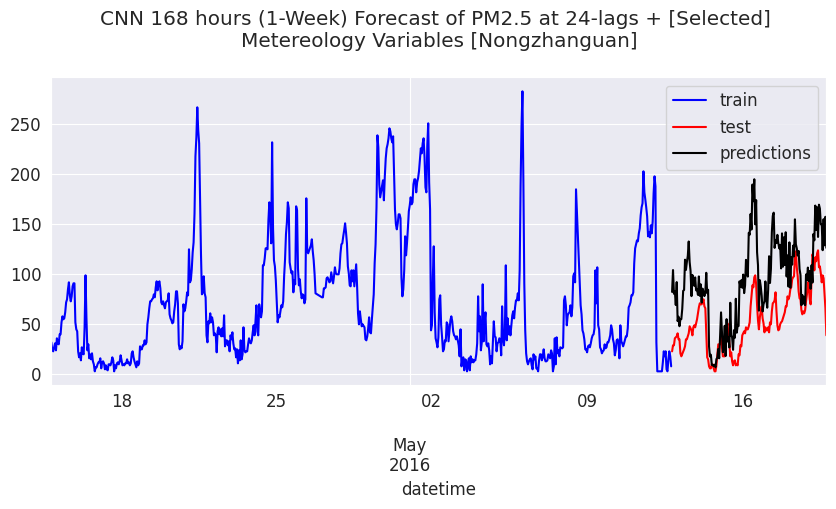

In [ ]:
plt.figure(figsize=(10,4))
pd.Series(deep_ytrain_nong_exo_sel[-steps*4:], index=Xtrain_nong_exo_sel.index[-steps*4:], name='PM2.5').plot(label='train', color='b')
y_true.plot(label='test', color='r')
preds_CNN.plot(label='predictions', color='black')
plt.title('CNN 168 hours (1-Week) Forecast of PM2.5 at 24-lags + [Selected] \nMetereology Variables [Nongzhanguan]\n')
plt.legend()

In [ ]:
results_cnn_1_week_forecast_sel_met_24lags = evaluate_model_performance(y_true, preds_CNN, label='cnn_one_week_sel')
results_cnn_1_week_forecast_sel_met_24lags

cnn_one_week_sel
MAE                  39.900
MSE                2316.078
RMSE                 48.126
R-Squared            -1.579
MAPE                  1.044

##### One Month (744 hrs) Forecast
- One month (24 * 31 = 744 hrs steps) into the future
- 24-lags
- CNN

In [ ]:
steps = 24 * 31

In [ ]:
one_monthX =  deep_Xtest_nong_exo_sel[:steps]
one_monthy =  deep_ytest_nong_exo_sel[:steps]
predictions = cnn_model_nong_exo_sel.predict(one_monthX)
predictions[:5]

24/24 [==============================] - 0s 2ms/step


array([[ 82.41876 ],
       [104.25527 ],
       [ 80.538086],
       [ 83.124664],
       [ 69.31162 ]], dtype=float32)

In [ ]:
preds_CNN = pd.Series(predictions.flatten(), index=Xtest_nong_exo_sel.index[:steps], name='PM2.5')
y_true = pd.Series(one_monthy, index=Xtest_nong_exo_sel.index[:steps], name='PM2.5')
preds_CNN.head()

datetime
2016-05-12 20:00:00     82.418762
2016-05-12 21:00:00    104.255272
2016-05-12 22:00:00     80.538086
2016-05-12 23:00:00     83.124664
2016-05-13 00:00:00     69.311623
Freq: H, Name: PM2.5, dtype: float32

In [ ]:
y_true.head()

datetime
2016-05-12 20:00:00    23.0
2016-05-12 21:00:00    29.0
2016-05-12 22:00:00    29.0
2016-05-12 23:00:00    36.0
2016-05-13 00:00:00    37.0
Freq: H, Name: PM2.5, dtype: float64

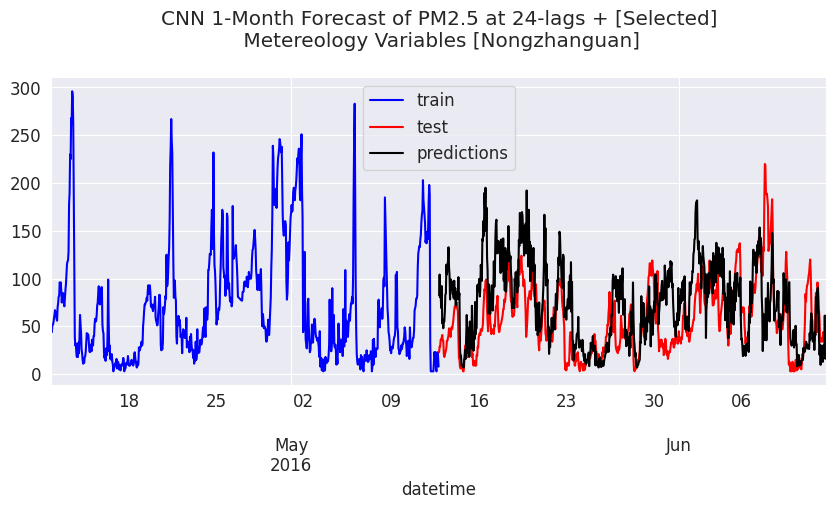

In [ ]:
plt.figure(figsize=(10,4))
pd.Series(deep_ytrain_nong_exo_sel[-steps:], index=Xtrain_nong_exo_sel.index[-steps:], name='PM2.5').plot(label='train', color='b')
y_true.plot(label='test', color='r')
preds_CNN.plot(label='predictions', color='black')
plt.title('CNN 1-Month Forecast of PM2.5 at 24-lags + [Selected]\n Metereology Variables [Nongzhanguan]\n')
plt.legend()

In [ ]:
results_cnn_1_month_forecast_sel_met_24lags = evaluate_model_performance(y_true, preds_CNN, label='cnn_one_month_sel_met')
results_cnn_1_month_forecast_sel_met_24lags

cnn_one_month_sel_met
MAE                       32.368
MSE                     1815.325
RMSE                      42.607
R-Squared                 -0.368
MAPE                       0.984

##### Combined Results

In [ ]:
cnn_results_pm25_with_sel_met_vars = pd.concat([
    results_cnn_1_day_forecast_sel_met_24lags, 
    results_cnn_1_week_forecast_sel_met_24lags,
    results_cnn_1_month_forecast_sel_met_24lags
    ], axis='columns')

cnn_results_pm25_with_sel_met_vars

cnn_one_day_sel_met  cnn_one_week_sel  cnn_one_month_sel_met
MAE                     53.008            39.900                 32.368
MSE                   3259.513          2316.078               1815.325
RMSE                    57.092            48.126                 42.607
R-Squared              -42.264            -1.579                 -0.368
MAPE                     1.683             1.044                  0.984

<Axes: title={'center': 'Results of CNN Forecasts of PM2.5 trained with [Selected] Metereological Variables [Nongzhanguan]\n'}>

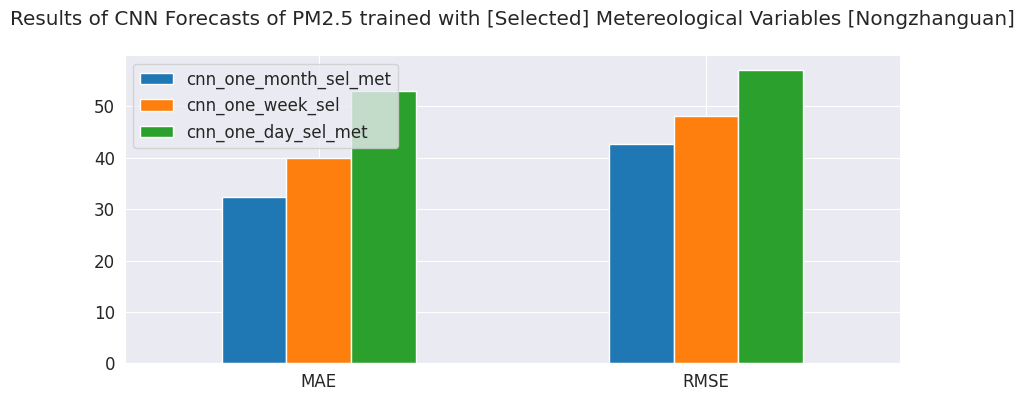

In [ ]:
cnn_results_pm25_with_sel_met_vars.iloc[[0,2],:].T.sort_values(by='MAE').T.plot.bar(
    title='Results of CNN Forecasts of PM2.5 trained with [Selected] Metereological Variables [Nongzhanguan]\n', 
    figsize=(10,4), rot=0)

In [ ]:
cnn_results_pm25_with_sel_met_vars.iloc[1,:].sort_values().plot.bar(
    title='MSE Results of CNN Forecasts of PM2.5 trained with Selected Metereological Variables [Nongzhanguan]\n', 
    figsize=(10,4), rot=0)
plt.legend()

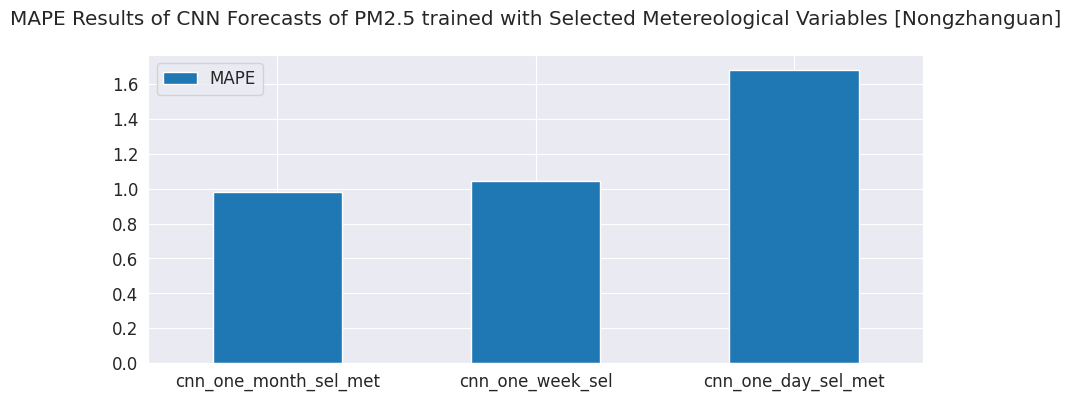

In [ ]:
cnn_results_pm25_with_sel_met_vars.iloc[-1,:].sort_values().plot.bar(
    title='MAPE Results of CNN Forecasts of PM2.5 trained with Selected Metereological Variables [Nongzhanguan]\n', 
    figsize=(10,4), rot=0)
plt.legend()

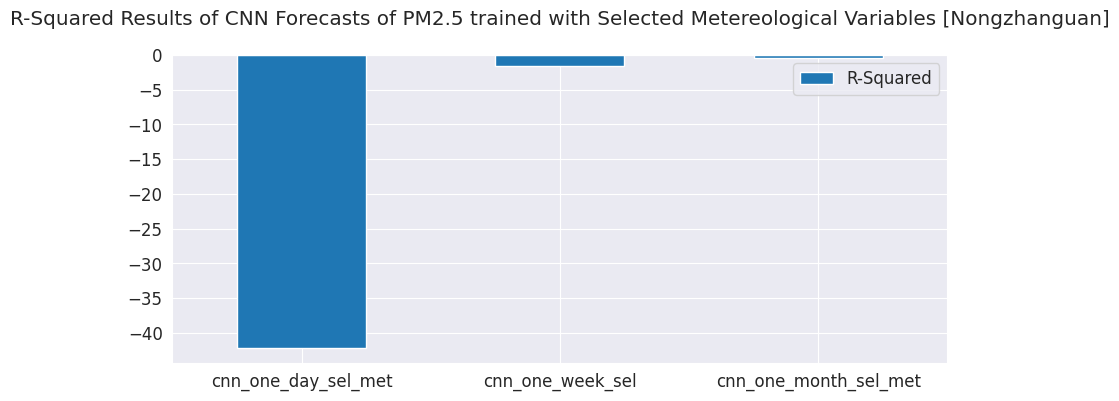

In [ ]:
cnn_results_pm25_with_sel_met_vars.iloc[-2,:].sort_values().plot.bar(
    title='R-Squared Results of CNN Forecasts of PM2.5 trained with Selected Metereological Variables [Nongzhanguan]\n', 
    figsize=(10,4), rot=0)
plt.legend()

In [ ]:
# Saving results
cnn_results_pm25_with_sel_met_vars.to_csv(f'{RESULTS_PATH}/cnn_results_pm25_with_selected_met_vars_24lags_Nongzhanguan.csv')

## Backtesting Cross-Validation (with refit) for CNN

- Timeseries Optimization and Validation with Backtesting
- lags: 24 hrs
- steps: 24 * 7
- n_backtesting: 5 (Backtesting_sample_size: step * 5 = (24 * 7) * 5 samples)


In [ ]:
# train:valid:test --- 80%:20%

TEST_SIZE = int(0.20 * len(y_pm25_nong)) # 20 %

N_FEATURES = 1
N_LAGS = 24
STEPS = 24 * 7   # 168 hrs (1 week)

BATCH_SIZE = 20
N_EPOCHS = 150

# 5 Fold cross validation (Walk-forward forecast)
N_FOLDS = 5
N_BACKTESTING = STEPS * N_FOLDS


##### Single-series [target only] data prep

In [ ]:
bt_pm25_data = series_to_supervised_dataset_single(series_data=y_pm25_nong, n_lags=N_LAGS)

for k in range(1, N_FOLDS + 1):
    train = bt_pm25_data.iloc[:-N_BACKTESTING], 
    test = bt_pm25_data.iloc[-N_BACKTESTING: - (N_BACKTESTING - STEPS)]

Xtrain, ytrain, Xtest, ytest = split

## LSTM


## LSTM (without Exogenous Metereological Variables)

In [ ]:
# train:valid:test --- 80%:20%

TEST_SIZE = int(0.20 * len(y_pm25_nong)) # 20 %

N_FEATURES = 1
N_LAGS = 24
STEPS = 24 * 7   # 168 hrs (1 week)

BATCH_SIZE = 20
N_EPOCHS = 150

#### Data Preparation for LSTM

##### Data Segmentation 

- Train: 80%
- Test: 20%

##### Single-series [target only] data prep

In [ ]:
lstm_pm25_data = series_to_supervised_dataset_single(series_data=y_pm25_nong, n_lags=N_LAGS)

In [ ]:
lstm_pm25_data.head()

PM25t-24  PM25t-23  PM25t-22  PM25t-21  PM25t-20  \
datetime                                                                
2013-03-02 00:00:00       5.0       8.0       3.0       5.0       5.0   
2013-03-02 01:00:00       8.0       3.0       5.0       5.0       3.0   
2013-03-02 02:00:00       3.0       5.0       5.0       3.0       4.0   
2013-03-02 03:00:00       5.0       5.0       3.0       4.0       3.0   
2013-03-02 04:00:00       5.0       3.0       4.0       3.0       3.0   

                     PM25t-19  PM25t-18  PM25t-17  PM25t-16  PM25t-15  ...  \
datetime                                                               ...   
2013-03-02 00:00:00       3.0       4.0       3.0       3.0      11.0  ...   
2013-03-02 01:00:00       4.0       3.0       3.0      11.0       3.0  ...   
2013-03-02 02:00:00       3.0       3.0      11.0       3.0       3.0  ...   
2013-03-02 03:00:00       3.0      11.0       3.0       3.0       3.0  ...   
2013-03-02 04:00:00      11.0       3.0       3.0       3.0       3.0  ...   

                     PM25t-9  PM25t-8  PM25t-7  PM25t-6  PM25t-5  PM25t-4  \
datetime                                                                    
2013-03-02 00:00:00      5.0      5.0     10.0     11.0     11.0     10.0   
2013-03-02 01:00:00      5.0     10.0     11.0     11.0     10.0     12.0   
2013-03-02 02:00:00     10.0     11.0     11.0     10.0     12.0     17.0   
2013-03-02 03:00:00     11.0     11.0     10.0     12.0     17.0      6.0   
2013-03-02 04:00:00     11.0     10.0     12.0     17.0      6.0     13.0   

                     PM25t-3  PM25t-2  PM25t-1  PM2.5  
datetime                                               
2013-03-02 00:00:00     12.0     17.0      6.0   13.0  
2013-03-02 01:00:00     17.0      6.0     13.0    3.0  
2013-03-02 02:00:00      6.0     13.0      3.0    3.0  
2013-03-02 03:00:00     13.0      3.0      3.0    3.0  
2013-03-02 04:00:00      3.0      3.0      3.0    3.0  

[5 rows x 25 columns]

In [ ]:
# Single target
train_set = lstm_pm25_data.iloc[:-TEST_SIZE]
test_set = lstm_pm25_data.iloc[-TEST_SIZE:]

Xtrain, ytrain = train_set.iloc[:, :-1], train_set.iloc[:, -1]
Xtest, ytest = test_set.iloc[:, :-1], test_set.iloc[:, -1]

In [ ]:
print(f'Shape of X: {lstm_pm25_data.shape}')
print(f'Shape of X-train: {Xtrain.shape}')
print(f'Shape of X-test: {Xtest.shape}')

Shape of X: (35040, 25)
Shape of X-train: (28028, 24)
Shape of X-test: (7012, 24)


In [ ]:
# Converting Series into Supervised learning format
deep_Xtrain, deep_ytrain = deep_prepare_X_y_for_CNN(
    X=Xtrain, y=ytrain, n_lags=N_LAGS, kind='single')

deep_Xtest, deep_ytest = deep_prepare_X_y_for_CNN(
    X=Xtest, y=ytest, n_lags=N_LAGS, kind='single')

In [ ]:
#  # MULTI-STEP FORECAST CASE
# deep_Xtrain, deep_ytrain = deep_prepare_X_y_for_CNN_multi_step(
#     X=Xtrain.values, y=ytrain.values, n_lags=N_LAGS, future_steps=24 * 7, start=0, end=None)
 
# deep_Xtest, deep_ytest = deep_prepare_X_y_for_CNN_multi_step(
#     X=Xtest.values, y=ytest.values, n_lags=N_LAGS, future_steps=24 * 7, start=0, end=None)

# print(deep_Xtrain[0][0,:],'\n\n\n', deep_ytrain.shape)

In [ ]:
print(f'Shape of X-train: {deep_Xtrain.shape}')
print(f'Shape of X-test: {deep_Xtest.shape}')

Shape of X-train: (28028, 24, 1)
Shape of X-test: (7012, 24, 1)


#### LSTM Model Buiding 

##### LSTM Configuration Variant 1 (Bi-directional LSTM Variant) 

In [ ]:
# del lstm_model

In [ ]:
lstm_model = Sequential([
    # Bi-directional input layer 1
    Bidirectional(LSTM(200, return_sequences=True), 
            input_shape=(N_LAGS, N_FEATURES)),
    # output of layer 1
    Dense(20, activation='tanh'),

    # Bi-directional input layer 2
    Bidirectional(LSTM(150)),
    # output of layer 1 and output of layer 2
    Dense(20, activation='tanh'), # layer 1 hidden-state
    Dense(20, activation='tanh'), # layer 2 hidden-state
    Dropout(0.25),

    # Output layer
    Dense(units=1),
 ])

lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=[
      MeanAbsoluteError(),
      RootMeanSquaredError(),
      MeanAbsolutePercentageError()
    ])

lstm_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_8 (Bidirectio  (None, 24, 400)          323200    
 nal)                                                            
                                                                 
 dense_15 (Dense)            (None, 24, 20)            8020      
                                                                 
 bidirectional_9 (Bidirectio  (None, 300)              205200    
 nal)                                                            
                                                                 
 dense_16 (Dense)            (None, 20)                6020      
                                                                 
 dense_17 (Dense)            (None, 20)                420       
                                                                 
 dropout_4 (Dropout)         (None, 20)               

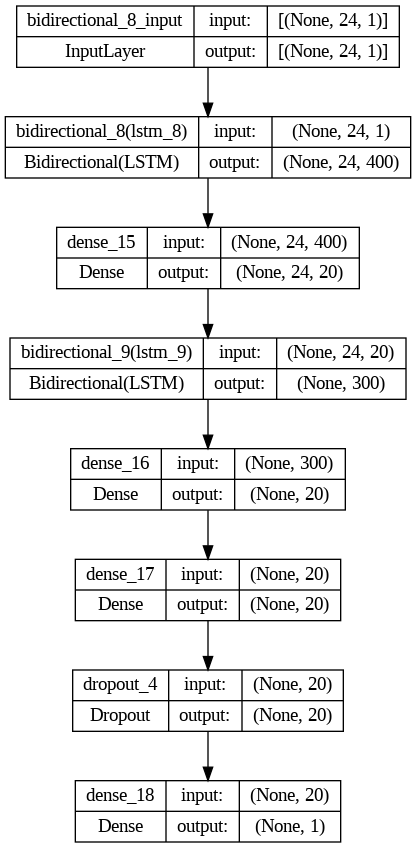

In [ ]:
# Model Architecture
plot_model(lstm_model, to_file='lstm_model_nong_with_all_exo_met_vars_added_multi_input.png', show_shapes=True, show_layer_names=True)

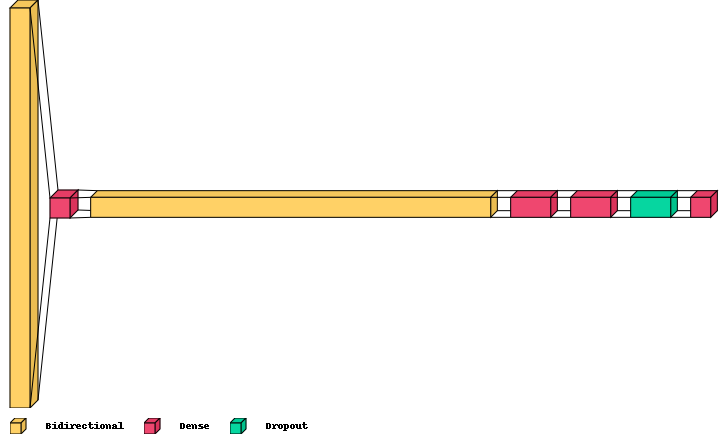

In [ ]:
# plt.figure(figsize=(12,4))
visualkeras.layered_view(
    lstm_model, legend=True, 
    scale_xy=1,
    scale_z=2,
    spacing=20,
    background_fill='white',
    to_file=f'{RESULTS_PATH}/deep_lstm_pm25_with_all_met_vars_Nongzhanguan_architecture.png')

In [ ]:
# Training the LSTM model

# callbacks (EarlyStopper to avoid overfitting)
early_stopper = EarlyStopping(
    monitor="loss",
    min_delta=0.05,  # p-value (significance)
    patience=5,
    restore_best_weights=True,
)

# For learning performance improvement
lr_reducer = LearningRateScheduler(lambda x: 1e-3 * 0.90 ** x)


# Fitting the model & applying callbacks
history = lstm_model.fit(
    deep_Xtrain, deep_ytrain, # validation_data=(deep_Xval, deep_yval), 
    batch_size=BATCH_SIZE, epochs = 150, verbose=1, callbacks=[lr_reducer, early_stopper])


Epoch 1/150
1402/1402 [==============================] - 21s 11ms/step - loss: 12162.4639 - mean_absolute_error: 72.0212 - root_mean_squared_error: 110.2836 - mean_absolute_percentage_error: 87.4999 - lr: 0.0010
Epoch 2/150
1402/1402 [==============================] - 17s 12ms/step - loss: 9559.4619 - mean_absolute_error: 62.4633 - root_mean_squared_error: 97.7725 - mean_absolute_percentage_error: 131.9590 - lr: 9.0000e-04
Epoch 3/150
1402/1402 [==============================] - 16s 12ms/step - loss: 8325.2227 - mean_absolute_error: 60.2284 - root_mean_squared_error: 91.2427 - mean_absolute_percentage_error: 180.7823 - lr: 8.1000e-04
Epoch 4/150
1402/1402 [==============================] - 16s 11ms/step - loss: 7779.7847 - mean_absolute_error: 60.6651 - root_mean_squared_error: 88.2031 - mean_absolute_percentage_error: 218.7170 - lr: 7.2900e-04
Epoch 5/150
1402/1402 [==============================] - 16s 11ms/step - loss: 7613.5762 - mean_absolute_error: 61.8769 - root_mean_squared_err

In [ ]:
# history.history
best_epoch = history.history['loss'].index(min(history.history['loss']))
print('TRAINING RESULT SUMMARY')
print('-----------------------\n')
print(f'Best Epoch: {best_epoch + 1}')
print(f'MAE: {history.history["mean_absolute_error"][best_epoch]}')
print(f'MSE: {history.history["loss"][best_epoch]}')
print(f'RMSE: {history.history["root_mean_squared_error"][best_epoch]}')
print(f'MAPE: {history.history["mean_absolute_percentage_error"][best_epoch]}')

TRAINING RESULT SUMMARY
-----------------------

Best Epoch: 46
MAE: 21.505245208740234
MSE: 2345.2001953125
RMSE: 48.42726516723633
MAPE: 30.31966781616211


In [ ]:
# MSE (Loss)
plt.figure(figsize=(12,4))
plt.plot(range(1, len(history.history['loss']) + 1), history.history['loss'], 
         label='MSE', color='r')
plt.title('Training loss (MSE) for LSTM for PM2.5 without Metereological Variables\n')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

Text(0.5, 21.722222222222214, 'Epochs')

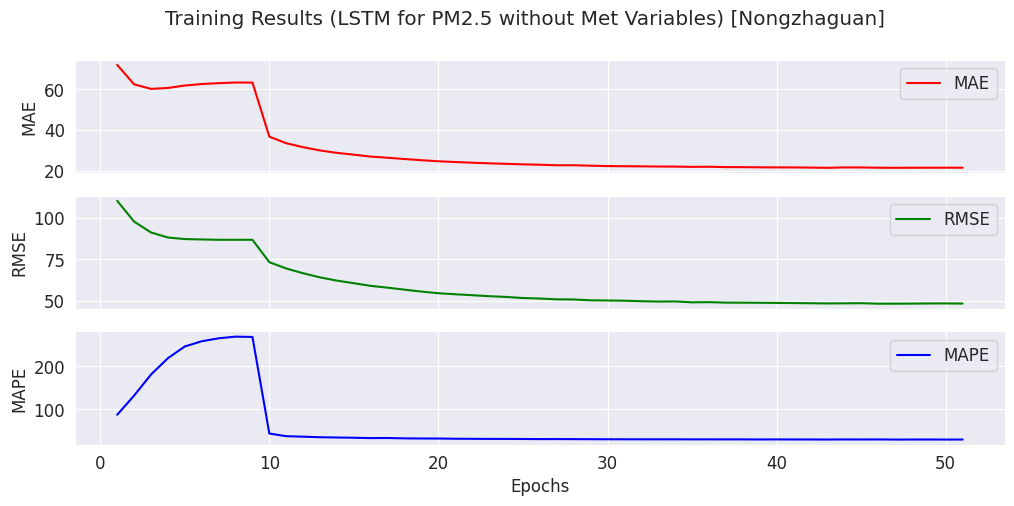

In [ ]:
# Training Performances
fig, axs = plt.subplots(3, sharex=True, figsize=(12,5))
fig.suptitle('Training Results (LSTM for PM2.5 without Met Variables) [Nongzhaguan]')

# MAE
axs[0].plot(range(1, len(history.history['loss']) + 1), history.history['mean_absolute_error'], 
            label='MAE', color='r')
axs[0].set_ylabel('MAE')
axs[0].legend()

# RMSE
axs[1].plot(range(1, len(history.history['loss']) + 1), history.history['root_mean_squared_error'], 
            label='RMSE', color='g')
axs[1].set_ylabel('RMSE')
axs[1].legend()

# MAPE
axs[2].plot(range(1, len(history.history['loss']) + 1), history.history['mean_absolute_percentage_error'], 
            label='MAPE', color='b')
axs[2].set_ylabel('MAPE')
axs[2].legend()
fig.tight_layout(pad=7.0)
plt.xlabel('Epochs')


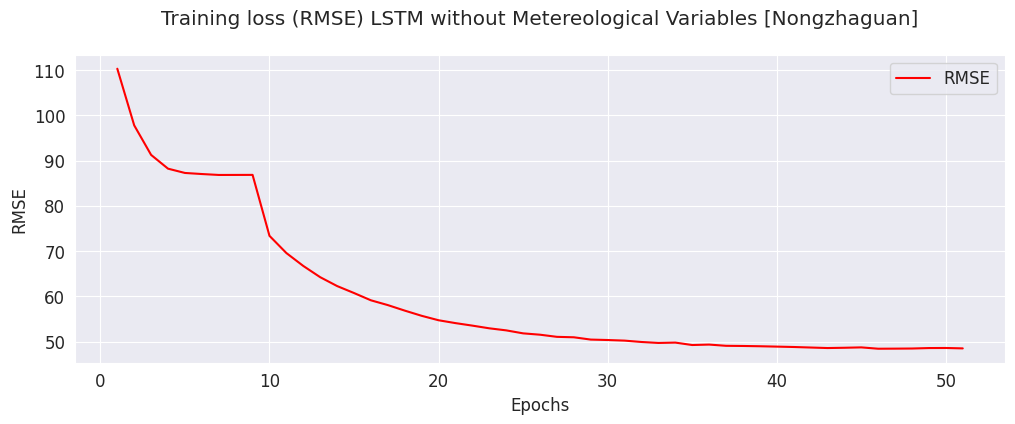

In [ ]:
# Training RMSE
plt.figure(figsize=(12,4))
plt.plot(range(1, len(history.history['loss']) + 1), np.sqrt(history.history['loss']), label='RMSE', color='r')
plt.title('Training loss (RMSE) LSTM without Metereological Variables [Nongzhaguan]\n')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()

In [ ]:
# Saving the trained model
lstm_model.save(f'{MODEL_PATH}/lstm_model1_pm25_without_met_vars_Nongzhanguan.h5')

---

##### LSTM Configuration Variant 2 (Sequential LSTM)

In [ ]:
# del lstm_model2

In [ ]:
lstm_model_2 = Sequential()

# ENCODER LAYER
# 1st LSTM layer and some Dropout regularisation
lstm_model_2.add(LSTM(units = 128, return_sequences = True, 
                    input_shape = (N_LAGS, N_FEATURES)))

# 2nd LSTM layer and some Dropout regularisation
lstm_model_2.add(LSTM(units = 128, return_sequences = True))

# 3rd LSTM layer and some Dropout regularisation
lstm_model_2.add(LSTM(units = 128, return_sequences = True))

# 4th LSTM layer and some Dropout regularisation
lstm_model_2.add(LSTM(units = 128, return_sequences = True))

# DECODER LAYER
# Adding the output layer
lstm_model_2.add(Dense(units = 1))

# Compiling the RNN
lstm_model_2.compile(optimizer = Adam(learning_rate=0.001), loss = 'mean_squared_error', metrics=[
    MeanAbsoluteError(),
    RootMeanSquaredError(),
    MeanAbsolutePercentageError()
])

In [ ]:
lstm_model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_45 (LSTM)              (None, 24, 128)           66560     
                                                                 
 lstm_46 (LSTM)              (None, 24, 128)           131584    
                                                                 
 lstm_47 (LSTM)              (None, 24, 128)           131584    
                                                                 
 lstm_48 (LSTM)              (None, 24, 128)           131584    
                                                                 
 dense_11 (Dense)            (None, 24, 1)             129       
                                                                 
Total params: 461,441
Trainable params: 461,441
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Model Architecture
plot_model(lstm_model, to_file='lstm_model_nong_with_all_exo_met_vars_added_multi_input.png', show_shapes=True, show_layer_names=True)

In [ ]:
# plt.figure(figsize=(12,4))
visualkeras.layered_view(
    lstm_model, legend=True, 
    scale_xy=1,
    scale_z=2,
    spacing=20,
    background_fill='white',
    to_file=f'{RESULTS_PATH}/deep_lstm_pm25_with_all_met_vars_Nongzhanguan_architecture.png')

##### LSTM Model Variant 3 (Seq2Seq Encoder-Decoder LSTM Variant)

In [ ]:
# ENCODER
#--------

# Input layer
encoder_inputs = Input(shape=(N_LAGS, N_FEATURES))

# Layer 1 - encoder
encoder_l1 = LSTM(100, return_sequences = True, return_state=True)
encoder_outputs1 = encoder_l1(encoder_inputs)
encoder_states1 = encoder_outputs1[1:]

# Layer2 - encoder
encoder_l2 = LSTM(100, return_state=True)
encoder_outputs2 = encoder_l2(encoder_outputs1[0])
encoder_states2 = encoder_outputs2[1:]


# DECODER
#---------

# decoder input
decoder_inputs = RepeatVector(STEPS)(encoder_outputs2[0])

# Layer 1 - decoder
decoder_l1 = LSTM(100, return_sequences=True)(decoder_inputs, initial_state = encoder_states1)

# layer 2- decoder
decoder_l2 = LSTM(100, return_sequences=True)(decoder_l1, initial_state = encoder_states2)
decoder_outputs2 = TimeDistributed(Dense(1))(decoder_l2)

# Output layer
lstm_model_3 = Model(encoder_inputs, decoder_outputs2)

# Compiling the RNN
lstm_model_3.compile(
    optimizer = Adam(learning_rate=0.001), 
    loss = 'mean_squared_error', 
    metrics = [
      MeanAbsoluteError(),
      MeanAbsolutePercentageError(),
      RootMeanSquaredError()
    ])

In [ ]:
lstm_model_3.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 24, 1)]      0           []                               
                                                                                                  
 lstm_18 (LSTM)                 [(None, 24, 100),    40800       ['input_5[0][0]']                
                                 (None, 100),                                                     
                                 (None, 100)]                                                     
                                                                                                  
 lstm_19 (LSTM)                 [(None, 100),        80400       ['lstm_18[0][0]']                
                                 (None, 100),                                               

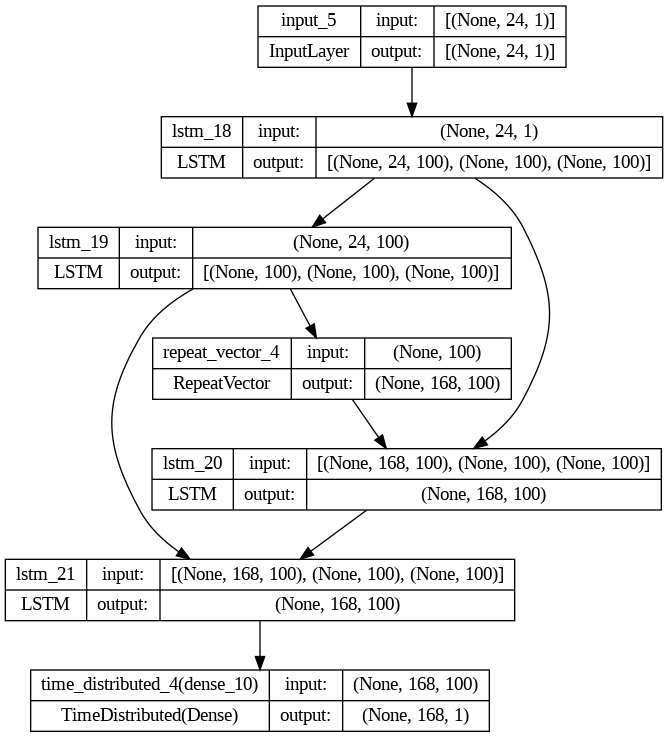

In [ ]:
# Model Architecture
plot_model(lstm_model_3, to_file='lstm_model_3_e2d2_nong_without_met_vars.png', show_shapes=True, show_layer_names=True)

In [ ]:
# # plt.figure(figsize=(12,4))
# visualkeras.layered_view(
#     model_e2d2, legend=True, 
#     scale_xy=1,
#     scale_z=2,
#     spacing=20,
#     background_fill='white',
#     to_file=f'{RESULTS_PATH}/deep_lstm_e2d2_pm25_with_all_met_vars_Nongzhanguan_architecture.png')

In [ ]:
# Training the RNN to the Training set

# callbacks (EarlyStopper to avoid overfitting)
early_stopper = EarlyStopping(
    monitor="loss",
    min_delta=0.05,  # p-value (significance)
    patience=5,
    restore_best_weights=True,
)

lr_reducer = LearningRateScheduler(lambda x: 1e-3 * 0.90 ** x)

# Fitting the model
history = lstm_model_3.fit(
    deep_Xtrain, deep_ytrain, # validation_data=(deep_Xval, deep_yval), 
    batch_size=BATCH_SIZE, epochs = 150, verbose=1, callbacks=[lr_reducer, early_stopper])

Epoch 1/150
1402/1402 [==============================] - 31s 18ms/step - loss: 8563.8496 - mean_absolute_error: 62.3710 - mean_absolute_percentage_error: 191.9737 - root_mean_squared_error: 92.5389 - lr: 0.0010
Epoch 2/150
1402/1402 [==============================] - 23s 17ms/step - loss: 7438.7314 - mean_absolute_error: 63.1823 - mean_absolute_percentage_error: 273.2458 - root_mean_squared_error: 86.2446 - lr: 9.0000e-04
Epoch 3/150
1402/1402 [==============================] - 25s 18ms/step - loss: 7438.4126 - mean_absolute_error: 63.3766 - mean_absolute_percentage_error: 275.8383 - root_mean_squared_error: 86.2295 - lr: 8.1000e-04
Epoch 4/150
1402/1402 [==============================] - 24s 17ms/step - loss: 7438.6221 - mean_absolute_error: 63.3043 - mean_absolute_percentage_error: 274.8808 - root_mean_squared_error: 86.2304 - lr: 7.2900e-04
Epoch 5/150
1402/1402 [==============================] - 25s 18ms/step - loss: 7438.4956 - mean_absolute_error: 63.3646 - mean_absolute_percenta

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-259-563abdd92055>", line 14, in <cell line: 14>
    history = lstm_model_3.fit(
  File "/usr/local/lib/python3.10/dist-packages/keras/utils/traceback_utils.py", line 65, in error_handler
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras/engine/training.py", line 1685, in fit
    tmp_logs = self.train_function(iterator)
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/traceback_utils.py", line 150, in error_handler
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/polymorphic_function/polymorphic_function.py", line 894, in __call__
    result = self._call(*args, **kwds)
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/polymorphic_function/pol

TypeError: ignored

In [ ]:
model_e2d2

In [ ]:
# history.history
best_epoch = history.history['loss'].index(min(history.history['loss']))
print('TRAINING RESULT SUMMARY')
print('-----------------------\n')
print(f'Best Epoch: {best_epoch + 1}')
print(f'MAE: {history.history["mean_absolute_error"][best_epoch]}')
print(f'MSE: {history.history["mean_squared_error"][best_epoch]}')
print(f'RMSE: {history.history["root_mean_squared_error"][best_epoch]}')
print(f'MAPE: {history.history["mean_absolute_percentage_error"][best_epoch]}')


# MSE (Loss)
plt.figure(figsize=(12,4))
plt.plot(range(1, len(history.history['loss']) + 1), history.history['loss'], 
         label='MSE', color='r')
plt.title('Training loss (MSE) for CNN for PM2.5 + [Selected] Metereological Variables\n')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Training Performances
fig, axs = plt.subplots(3, sharex=True, figsize=(12,5))
fig.suptitle('Training Results (CNN for PM2.5 + [Selected] Met Variables) [Nongzhaguan]')

# MAE
axs[0].plot(range(1, len(history.history['loss']) + 1), history.history['mean_absolute_error'], 
            label='MAE', color='r')
axs[0].set_ylabel('MAE')
axs[0].legend()

# RMSE
axs[1].plot(range(1, len(history.history['loss']) + 1), history.history['root_mean_squared_error'], 
            label='RMSE', color='g')
axs[1].set_ylabel('RMSE')
axs[1].legend()

# MAPE
axs[2].plot(range(1, len(history.history['loss']) + 1), history.history['mean_absolute_percentage_error'], 
            label='MAPE', color='b')
axs[2].set_ylabel('MAPE')
axs[2].legend()
fig.tight_layout(pad=7.0)
plt.xlabel('Epochs')

# Training RMSE
plt.figure(figsize=(12,4))
plt.plot(range(1, len(history.history['loss']) + 1), np.sqrt(history.history['loss']), label='RMSE', color='r')
plt.title('Training loss (RMSE) CNN + [Selected] Metereological Variables [Nongzhaguan]\n')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()

# saving the trained model
cnn_model_nong_exo_sel.save(f'{MODEL_PATH}/cnn_model_pm25_with_selected_met_vars_Nongzhanguan.h5')

---

---

In [ ]:
# del model_e2d2

In [ ]:
# # ENCODER
# #--------

# # Input layer
# encoder_inputs = Input(shape=(N_LAGS, N_FEATURES))

# # Layer 1 - encoder
# encoder_l1 = LSTM(100, return_sequences = True, return_state=True)
# encoder_outputs1 = encoder_l1(encoder_inputs)
# encoder_states1 = encoder_outputs1[1:]

# # Layer2 - encoder
# encoder_l2 = LSTM(100, return_state=True)
# encoder_outputs2 = encoder_l2(encoder_outputs1[0])
# encoder_states2 = encoder_outputs2[1:]



# # DECODER
# #---------

# # decoder input
# decoder_inputs = RepeatVector(STEPS)(encoder_outputs2[0])

# # Layer 1 - decoder
# decoder_l1 = LSTM(100, return_sequences=True)(decoder_inputs, initial_state = encoder_states1)

# # layer 2- decoder
# decoder_l2 = LSTM(100, return_sequences=True)(decoder_l1, initial_state = encoder_states2)
# decoder_outputs2 = TimeDistributed(Dense(1))(decoder_l2)

# # Output layer
# model_e2d2 = Model(encoder_inputs, decoder_outputs2)

# # Compiling the RNN
# model_e2d2.compile(
#     optimizer = Adam(learning_rate=0.001), 
#     loss = 'mean_squared_error', 
#     metrics = [
#       MeanAbsoluteError(),
#       MeanAbsolutePercentageError(),
#       RootMeanSquaredError()
#     ])

# model_e2d2.summary()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 24, 6)]      0           []                               
                                                                                                  
 lstm_56 (LSTM)                 [(None, 24, 100),    42800       ['input_11[0][0]']               
                                 (None, 100),                                                     
                                 (None, 100)]                                                     
                                                                                                  
 lstm_57 (LSTM)                 [(None, 100),        80400       ['lstm_56[0][0]']                
                                 (None, 100),                                              

In [ ]:
# hist = model_e2d2.fit(deep_Xtrain, deep_ytrain, validation_data=(deep_Xval, deep_yval), batch_size=BATCH_SIZE, epochs = 5, verbose=1)

Epoch 1/5
767/767 [==============================] - 44s 24ms/step - loss: 9308.6074 - mean_absolute_error: 63.0571 - mean_absolute_percentage_error: 139.4424 - root_mean_squared_error: 96.4907 - val_loss: 7111.2290 - val_mean_absolute_error: 55.5141 - val_mean_absolute_percentage_error: 222.3975 - val_root_mean_squared_error: 84.3785
Epoch 2/5
767/767 [==============================] - 16s 20ms/step - loss: 7203.0327 - mean_absolute_error: 60.5167 - mean_absolute_percentage_error: 239.3186 - root_mean_squared_error: 84.8132 - val_loss: 7140.2217 - val_mean_absolute_error: 60.8666 - val_mean_absolute_percentage_error: 288.7527 - val_root_mean_squared_error: 84.5502
Epoch 3/5
767/767 [==============================] - 19s 25ms/step - loss: 7122.9199 - mean_absolute_error: 62.1538 - mean_absolute_percentage_error: 266.3504 - root_mean_squared_error: 84.4044 - val_loss: 7161.5303 - val_mean_absolute_error: 61.2768 - val_mean_absolute_percentage_error: 292.8192 - val_root_mean_squared_erro

In [ ]:
train_set = lstm_pm25_data.iloc[:- TEST_SIZE]
test_set = lstm_pm25_data.iloc[-TEST_SIZE:]

Xtrain, ytrain = train_set.iloc[:, :-1], train_set.iloc[:, -1]
Xtest, ytest = test_set.iloc[:, :-1], test_set.iloc[:, -1]

In [ ]:
print(f'Shape of X: {lstm_pm25_data.shape}')
print(f'Shape of X-train: {Xtrain.shape}')
print(f'Shape of X-test: {Xtest.shape}')

In [ ]:
# Converting Series with Exogenous variables into Supervised learning format
deep_Xtrain, deep_ytrain = deep_prepare_X_y_for_CNN(
    X=Xtrain, y=ytrain, n_lags=N_LAGS, kind='multi_input')

deep_Xval, deep_yval = deep_prepare_X_y_for_CNN(
    X=Xval, y=yval, n_lags=N_LAGS, kind='multi_input')

deep_Xtest, deep_ytest = deep_prepare_X_y_for_CNN(
    X=Xtest, y=ytest, n_lags=N_LAGS, kind='multi_input')

---

#### Making Forecasts

In [ ]:
# loading the trained LSTM model
lstm_model = load_model(f'{MODEL_PATH}/lstm_model1_pm25_without_met_vars_Nongzhanguan.h5')

##### 24 hours (1-Day) Forecast

- 24 lags 
- 24 steps
- LSTM (Bi-directional)
- No metereological data

In [ ]:
steps = 24

In [ ]:
one_dayX =  deep_Xtest[:steps]
one_dayy =  deep_ytest[:steps]
predictions = lstm_model.predict(one_dayX)
predictions[:5]

1/1 [==============================] - 2s 2s/step


array([[11.2898  ],
       [13.737552],
       [22.998718],
       [25.957424],
       [51.362873]], dtype=float32)

In [ ]:
preds = pd.Series(predictions.flatten(), index=Xtest.index[:steps], name='PM2.5')
y_true = pd.Series(one_dayy, index=Xtest.index[:steps], name='PM2.5')
preds.head()

datetime
2016-05-12 20:00:00    11.289800
2016-05-12 21:00:00    13.737552
2016-05-12 22:00:00    22.998718
2016-05-12 23:00:00    25.957424
2016-05-13 00:00:00    51.362873
Freq: H, Name: PM2.5, dtype: float32

In [ ]:
y_true.head()

datetime
2016-05-12 20:00:00     15.0
2016-05-12 21:00:00     23.0
2016-05-12 22:00:00     25.0
2016-05-12 23:00:00     45.0
2016-05-13 00:00:00    105.0
Freq: H, Name: PM2.5, dtype: float64

<function matplotlib.pyplot.legend(*args, **kwargs)>

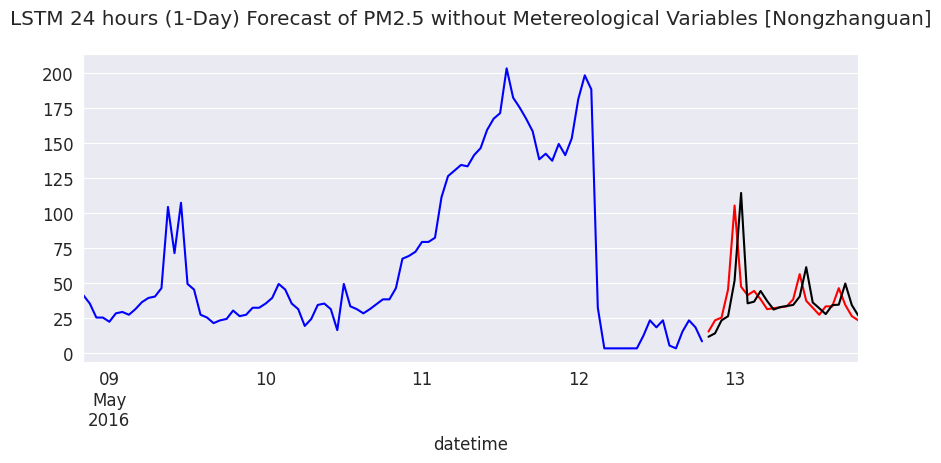

In [ ]:
plt.figure(figsize=(10,4))
pd.Series(deep_ytrain[-steps*4:], index=Xtrain.index[-steps*4:], name='PM2.5').plot(label='train', color='b')
y_true.plot(label='test', color='r')
plt.title('LSTM 24 hours (1-Day) Forecast of PM2.5 without Metereological Variables [Nongzhanguan]\n')
preds.plot(label='predictions', color='black')
plt.legend

In [ ]:
results_lstm_one_day = evaluate_model_performance(y_true, preds, label='lstm_one_day')
results_lstm_one_day

lstm_one_day
MAE              11.602
MSE             389.874
RMSE             19.745
R-Squared        -0.396
MAPE              0.270

##### One Week (168hrs) Forecast
- One week (24 * 7 = 168 hrs steps) into the future
- 24-lags
- LSTM

In [ ]:
steps = 24 * 7

In [ ]:
one_weekX =  deep_Xtest[:steps]
one_weeky =  deep_ytest[:steps]
predictions = lstm_model.predict(one_weekX)
predictions[:5]

6/6 [==============================] - 0s 6ms/step


array([[11.2898  ],
       [13.737552],
       [22.998718],
       [25.957424],
       [51.362873]], dtype=float32)

In [ ]:
preds = pd.Series(predictions.flatten(), index=Xtest.index[:steps], name='PM2.5')
y_true = pd.Series(one_weeky, index=Xtest.index[:steps], name='PM2.5')
preds.head()

datetime
2016-05-12 20:00:00    11.289800
2016-05-12 21:00:00    13.737552
2016-05-12 22:00:00    22.998718
2016-05-12 23:00:00    25.957424
2016-05-13 00:00:00    51.362873
Freq: H, Name: PM2.5, dtype: float32

In [ ]:
y_true.head()

datetime
2016-05-12 20:00:00     15.0
2016-05-12 21:00:00     23.0
2016-05-12 22:00:00     25.0
2016-05-12 23:00:00     45.0
2016-05-13 00:00:00    105.0
Freq: H, Name: PM2.5, dtype: float64

In [ ]:
plt.figure(figsize=(10,4))
pd.Series(deep_ytrain[-steps*4:], index=Xtrain.index[-steps*4:], name='PM2.5').plot(label='train', color='b')
y_true.plot(label='test', color='r')
preds.plot(label='predictions', color='black')
plt.title('LSTM 168 hours (1-Week) Forecast of PM2.5 at 24-lags without Metereological \nVariables [Nongzhanguan]\n')
plt.legend()

In [ ]:
results_lstm_one_week = evaluate_model_performance(y_true, preds, label='lstm_one_week')
results_lstm_one_week

lstm_one_week
MAE                6.062
MSE               99.877
RMSE               9.994
R-Squared          0.842
MAPE               0.195

##### One Month (744 hrs) Forecast
- One month (24 * 31 = 744 hrs steps) into the future
- 24-lags
- CNN

In [ ]:
steps = 24 * 31

In [ ]:
one_monthX =  deep_Xtest[:steps]
one_monthy =  deep_ytest[:steps]
predictions = lstm_model.predict(one_monthX)
predictions[:5]

24/24 [==============================] - 0s 6ms/step


array([[11.2898  ],
       [13.737552],
       [22.998718],
       [25.957424],
       [51.362873]], dtype=float32)

In [ ]:
preds = pd.Series(predictions.flatten(), index=Xtest.index[:steps], name='PM2.5')
y_true = pd.Series(one_monthy, index=Xtest.index[:steps], name='PM2.5')
preds.head()

datetime
2016-05-12 20:00:00    11.289800
2016-05-12 21:00:00    13.737552
2016-05-12 22:00:00    22.998718
2016-05-12 23:00:00    25.957424
2016-05-13 00:00:00    51.362873
Freq: H, Name: PM2.5, dtype: float32

In [ ]:
y_true.head()

datetime
2016-05-12 20:00:00     15.0
2016-05-12 21:00:00     23.0
2016-05-12 22:00:00     25.0
2016-05-12 23:00:00     45.0
2016-05-13 00:00:00    105.0
Freq: H, Name: PM2.5, dtype: float64

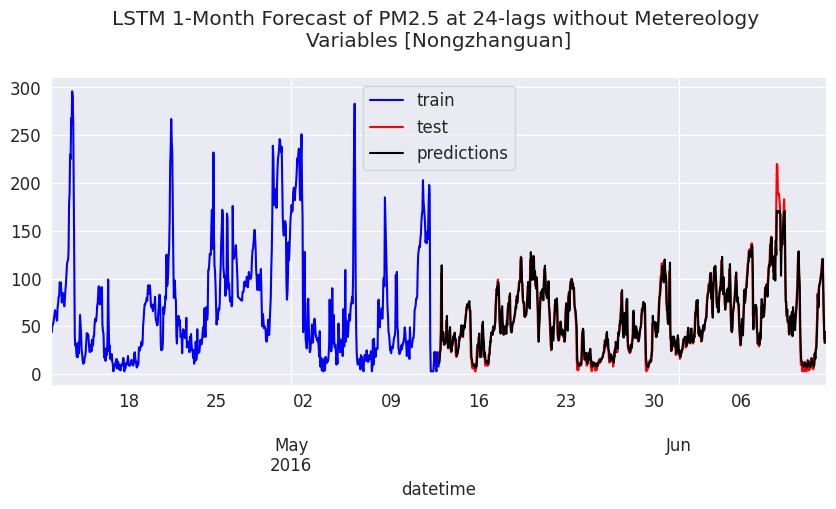

In [ ]:
plt.figure(figsize=(10,4))
pd.Series(deep_ytrain[-steps:], index=Xtrain.index[-steps:], name='PM2.5').plot(label='train', color='b')
y_true.plot(label='test', color='r')
preds.plot(label='predictions', color='black')
plt.title('LSTM 1-Month Forecast of PM2.5 at 24-lags without Metereology \nVariables [Nongzhanguan]\n')
plt.legend()

In [ ]:
results_lstm_one_month = evaluate_model_performance(y_true, preds, label='lstm_one_month')
results_lstm_one_month

lstm_one_month
MAE                 7.375
MSE               113.362
RMSE               10.647
R-Squared           0.915
MAPE                0.216

##### Combined Results

In [ ]:
combined_results_lstm_no_met_24lags = pd.concat([
    results_lstm_one_day, 
    results_lstm_one_week, 
    results_lstm_one_month
], axis='columns')

combined_results_lstm_no_met_24lags

lstm_one_day  lstm_one_week  lstm_one_month
MAE              11.602          6.062           7.375
MSE             389.874         99.877         113.362
RMSE             19.745          9.994          10.647
R-Squared        -0.396          0.842           0.915
MAPE              0.270          0.195           0.216

<Axes: title={'center': 'Results of LSTM Forecasts of PM2.5 trained without \nMetereological Variables [Nongzhanguan]\n'}>

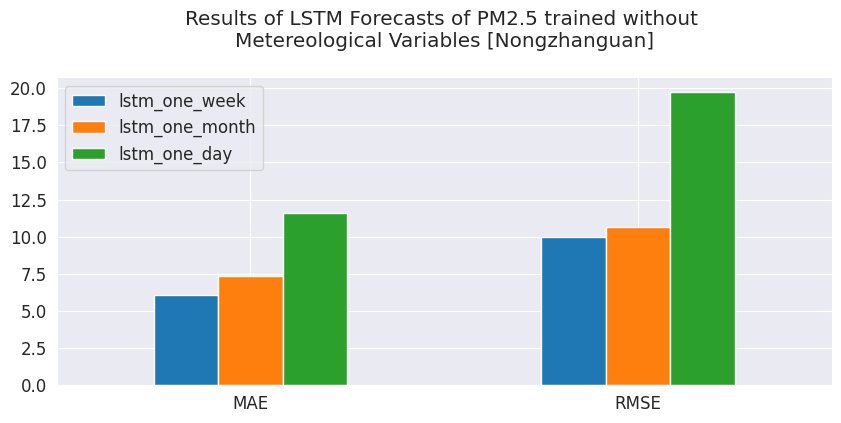

In [ ]:
combined_results_lstm_no_met_24lags.iloc[[0,2],:].T.sort_values(by='MAE').T.plot.bar(
    title='Results of LSTM Forecasts of PM2.5 trained without \nMetereological Variables [Nongzhanguan]\n', 
    figsize=(10,4), rot=0)

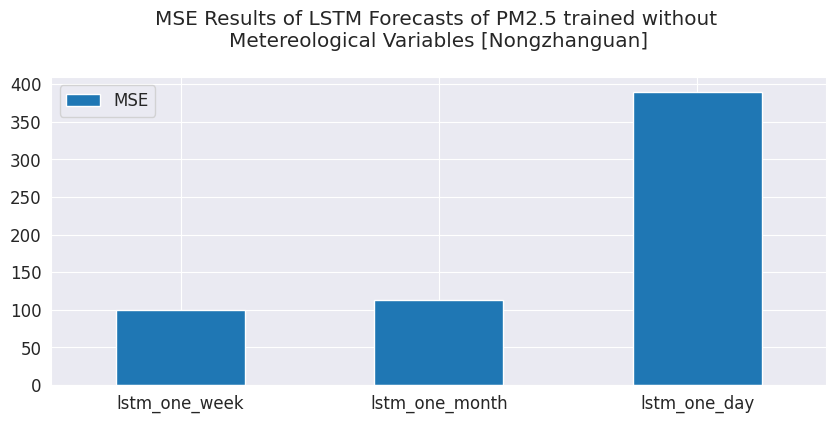

In [ ]:
combined_results_lstm_no_met_24lags.iloc[1,:].sort_values().plot.bar(
    title='MSE Results of LSTM Forecasts of PM2.5 trained without \nMetereological Variables [Nongzhanguan]\n', 
    figsize=(10,4), rot=0)
plt.legend()

In [ ]:
combined_results_lstm_no_met_24lags.iloc[-1,:].sort_values().plot.bar(
    title='MAPE Results of LSTM Forecasts of PM2.5 trained without \nMetereological Variables [Nongzhanguan]\n', 
    figsize=(10,4), rot=0)
plt.legend()

In [ ]:
combined_results_lstm_no_met_24lags.iloc[-2,:].sort_values().plot.bar(
    title='R-Squared Results of LSTM Forecasts of PM2.5 trained without \nMetereological Variables [Nongzhanguan]\n', 
    figsize=(10,4), rot=0)
plt.legend()

In [ ]:
# Saving results
combined_results_lstm_no_met_24lags.to_csv(f'{RESULTS_PATH}/combined_results_lstm_no_met_24lags_Nongzhanguan.csv')

## LSTM + All Exogenous Metereological Variables


- 1 day (24 hrs) lag
- LSTM (Bi-directional LSTM)
- Nongzhanguan station data

In [ ]:
TEST_SIZE = int((20 / 100) * len(y_pm25_nong)) # 20%
N_LAGS = 24
N_FEATURES = 6

#### Data Preparation and preprocessing

In [ ]:
# merged scaled data and target
data_pm25_exo = pd.concat([scaled_features_X_nong, y_pm25_nong], axis='columns')
data_pm25_exo.head()

TEMP      PRES      DEWP      RAIN        wd  \
datetime                                                                
2013-03-01 00:00:00 -1.236368  1.163818 -1.726439 -0.081398  1.598127   
2013-03-01 01:00:00 -1.253821  1.222261 -1.777120 -0.081398  1.384841   
2013-03-01 02:00:00 -1.297452  1.241742 -1.958126 -0.081398  1.598127   
2013-03-01 03:00:00 -1.314905  1.329407 -2.023288 -0.081398  1.811414   
2013-03-01 04:00:00 -1.358537  1.417073 -1.950885 -0.081398  1.598127   

                         WSPM  PM2.5  
datetime                              
2013-03-01 00:00:00  2.998406    5.0  
2013-03-01 01:00:00  1.592605    8.0  
2013-03-01 02:00:00  2.686006    3.0  
2013-03-01 03:00:00  2.373605    5.0  
2013-03-01 04:00:00  1.045905    5.0

In [ ]:
# Data Segmentation (80% training : 20% testing)

Xtrain_exo, ytrain_exo, Xtest_exo, ytest_exo = \
    split_train_test_series_multivariate_series(
        data_pm25_exo, test_size=TEST_SIZE)

In [ ]:
Xtrain_exo.head(2)

TEMP      PRES      DEWP      RAIN        wd  \
datetime                                                                
2013-03-01 00:00:00 -1.236368  1.163818 -1.726439 -0.081398  1.598127   
2013-03-01 01:00:00 -1.253821  1.222261 -1.777120 -0.081398  1.384841   

                         WSPM  
datetime                       
2013-03-01 00:00:00  2.998406  
2013-03-01 01:00:00  1.592605

In [ ]:
ytrain_exo.head(2)

datetime
2013-03-01 00:00:00    5.0
2013-03-01 01:00:00    8.0
Freq: H, Name: PM2.5, dtype: float64

In [ ]:
print(f'Shape of X: {features_X_nong.shape}')
print(f'Shape of Xtrain: {Xtrain_exo.shape}')
print(f'Shape of Xtest: {Xtest_exo.shape}')

Shape of X: (35064, 6)
Shape of Xtrain: (28052, 6)
Shape of Xtest: (7012, 6)


In [ ]:
deep_Xtrain_exo, deep_ytrain_exo = deep_prepare_X_y_for_CNN(
    X=Xtrain_exo, y=ytrain_exo, n_lags=N_LAGS, kind='multi_input')


deep_Xtest_exo, deep_ytest_exo = deep_prepare_X_y_for_CNN(
    X=Xtest_exo, y=ytest_exo, n_lags=N_LAGS, kind='multi_input')

In [ ]:
print(f'Shape of Xtrain: {Xtrain_exo.shape}')
print(f'Shape of Deep-Xtrain: {deep_Xtrain_exo.shape}')
print(f'Shape of Deep-Xtest: {deep_Xtest_exo.shape}')
print(f'Shape of Deep-ytrain: {deep_ytrain_exo.shape}')
print(f'Shape of Deep-ytest: {deep_ytest_exo.shape}')

Shape of Xtrain: (28052, 6)
Shape of Deep-Xtrain: (28029, 24, 6)
Shape of Deep-Xtest: (6989, 24, 6)
Shape of Deep-ytrain: (28029,)
Shape of Deep-ytest: (6989,)


In [ ]:
for i in range(2):
    print(deep_Xtrain_exo[i], deep_ytrain_exo[i])

[[-1.23636817  1.16381753 -1.72643876 -0.08139834  1.59812742  2.99840581]
 [-1.25382083  1.22226104 -1.77712028 -0.08139834  1.38484101  1.5926049 ]
 [-1.29745248  1.2417422  -1.95812569 -0.08139834  1.59812742  2.68600561]
 [-1.31490514  1.32940746 -2.02328764 -0.08139834  1.81141384  2.37360541]
 [-1.35853679  1.41707272 -1.95088547 -0.08139834  1.59812742  1.04590454]
 [-1.40216844  1.45603505 -1.71919854 -0.08139834  1.38484101  0.42110414]
 [-1.41089477  1.52421914 -1.65403659 -0.08139834  1.38484101  0.26490404]
 [-1.31490514  1.65084673 -1.65403659 -0.08139834  1.59812742  0.88970444]
 [-1.21891551  1.73851199 -1.71195833 -0.08139834  1.38484101  2.13930525]
 [-1.1578312   1.74825257 -1.86400287 -0.08139834  1.81141384  2.84220571]
 [-1.07056791  1.71903082 -1.80608114 -0.08139834  1.81141384  2.60790556]
 [-0.93967296  1.68006849 -1.83504201 -0.08139834  1.59812742  2.68600561]
 [-0.84368333  1.56318148 -1.71195833 -0.08139834  0.95826818  2.13930525]
 [-0.75642004  1.4852568 

#### LSTM Model Buiding 

##### LSTM Configuration Variant 1 (Bi-directional LSTM Variant) 

In [ ]:
# del lstm_model_exo

In [ ]:
lstm_model_exo = Sequential([
    # Bi-directional input layer 1
    Bidirectional(LSTM(200, return_sequences=True), 
            input_shape=(N_LAGS, N_FEATURES)),
    # output of layer 1
    Dense(20, activation='tanh'),

    # Bi-directional input layer 2
    Bidirectional(LSTM(150)),
    # output of layer 1 and output of layer 2
    Dense(20, activation='tanh'), # layer 1 hidden-state
    Dense(20, activation='tanh'), # layer 2 hidden-state
    Dropout(0.25),

    # Output layer
    Dense(units=1),
 ])

lstm_model_exo.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=[
      MeanAbsoluteError(),
      RootMeanSquaredError(),
      MeanAbsolutePercentageError()
    ])

lstm_model_exo.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 24, 400)          331200    
 l)                                                              
                                                                 
 dense_2 (Dense)             (None, 24, 20)            8020      
                                                                 
 bidirectional_1 (Bidirectio  (None, 300)              205200    
 nal)                                                            
                                                                 
 dense_3 (Dense)             (None, 20)                6020      
                                                                 
 dense_4 (Dense)             (None, 20)                420       
                                                                 
 dropout (Dropout)           (None, 20)               

In [ ]:
# Model Architecture
plot_model(lstm_model_exo, to_file='lstm_model_nong_with_all_exo_met_vars_added_multi_input.png', show_shapes=True, show_layer_names=True)

In [ ]:
# plt.figure(figsize=(12,4))
visualkeras.layered_view(
    lstm_model_exo, legend=True, 
    scale_xy=1,
    scale_z=1,
    spacing=20,
    background_fill='white',
    to_file=f'{RESULTS_PATH}/deep_lstm_pm25_with_all_met_vars_Nongzhanguan_architecture.png')

In [ ]:
# Training the LSTM model

# callbacks (EarlyStopper to avoid overfitting)
early_stopper = EarlyStopping(
    monitor="loss",
    min_delta=0.05,  # p-value (significance)
    patience=5,
    restore_best_weights=True,
)

# For learning performance improvement
lr_reducer = LearningRateScheduler(lambda x: 1e-3 * 0.90 ** x)


# Fitting the model & applying callbacks
history = lstm_model_exo.fit(
    deep_Xtrain_exo, deep_ytrain_exo, 
    # validation_data=(deep_Xval, deep_yval), 
    batch_size=BATCH_SIZE, epochs = 150, verbose=1, 
    callbacks=[lr_reducer, early_stopper])


Epoch 1/150
1402/1402 [==============================] - 22s 12ms/step - loss: 11751.8145 - mean_absolute_error: 70.1964 - root_mean_squared_error: 108.4058 - mean_absolute_percentage_error: 89.8894 - lr: 0.0010
Epoch 2/150
1402/1402 [==============================] - 16s 12ms/step - loss: 9316.0557 - mean_absolute_error: 61.8652 - root_mean_squared_error: 96.5197 - mean_absolute_percentage_error: 139.7264 - lr: 9.0000e-04
Epoch 3/150
1402/1402 [==============================] - 16s 11ms/step - loss: 8217.2549 - mean_absolute_error: 60.3473 - root_mean_squared_error: 90.6491 - mean_absolute_percentage_error: 188.9056 - lr: 8.1000e-04
Epoch 4/150
1402/1402 [==============================] - 16s 12ms/step - loss: 7745.9443 - mean_absolute_error: 60.8544 - root_mean_squared_error: 88.0110 - mean_absolute_percentage_error: 223.8730 - lr: 7.2900e-04
Epoch 5/150
1402/1402 [==============================] - 16s 12ms/step - loss: 7599.0381 - mean_absolute_error: 62.0168 - root_mean_squared_err

In [ ]:
# history.history

best_epoch = history.history['loss'].index(min(history.history['loss']))
print('TRAINING RESULT SUMMARY')
print('-----------------------\n')
print(f'Best Epoch: {best_epoch + 1}')
print(f'MAE: {history.history["mean_absolute_error"][best_epoch]}')
print(f'MSE: {history.history["loss"][best_epoch]}')
print(f'RMSE: {history.history["root_mean_squared_error"][best_epoch]}')
print(f'MAPE: {history.history["mean_absolute_percentage_error"][best_epoch]}')

TRAINING RESULT SUMMARY
-----------------------

Best Epoch: 63
MAE: 21.147329330444336
MSE: 2060.979248046875
RMSE: 45.398006439208984
MAPE: 36.5552864074707


In [ ]:
# MSE (Loss)
plt.figure(figsize=(12,4))
plt.plot(range(1, len(history.history['loss']) + 1), history.history['loss'], 
         label='MSE', color='r')
plt.title('Training loss (MSE) for LSTM for PM2.5 + All Metereological Variables [Nongzhanguan]\n')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [ ]:
# Training Performances
fig, axs = plt.subplots(3, sharex=True, figsize=(12,5))
fig.suptitle('Training Results (LSTM for PM2.5 + All Met Variables) [Nongzhaguan]')

# MAE
axs[0].plot(range(1, len(history.history['loss']) + 1), history.history['mean_absolute_error'], 
            label='MAE', color='r')
axs[0].set_ylabel('MAE')
axs[0].legend()

# RMSE
axs[1].plot(range(1, len(history.history['loss']) + 1), history.history['root_mean_squared_error'], 
            label='RMSE', color='g')
axs[1].set_ylabel('RMSE')
axs[1].legend()

# MAPE
axs[2].plot(range(1, len(history.history['loss']) + 1), history.history['mean_absolute_percentage_error'], 
            label='MAPE', color='b')
axs[2].set_ylabel('MAPE')
axs[2].legend()
fig.tight_layout(pad=7.0)
plt.xlabel('Epochs')


Text(0.5, 21.722222222222214, 'Epochs')

In [ ]:
# Training RMSE
plt.figure(figsize=(12,4))
plt.plot(range(1, len(history.history['loss']) + 1), np.sqrt(history.history['loss']), label='RMSE', color='r')
plt.title('Training loss (RMSE) LSTM + All Metereological Variables [Nongzhaguan]\n')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()

In [ ]:
# Saving the trained model
lstm_model_exo.save(f'{MODEL_PATH}/lstm_model_pm25_with_all_met_vars_added_Nongzhanguan.h5')

In [ ]:
# # loading the trained model
# lstm_model_exo = load_model(f'{MODEL_PATH}/lstm_model_pm25_with_all_met_vars_added_Nongzhanguan.h5')

---

#### Making Forecasts

In [ ]:
# Loading saved trained model
lstm_model_exo = load_model(f'{MODEL_PATH}/lstm_model_pm25_with_all_met_vars_added_Nongzhanguan.h5')

##### 24 hrs (One day) Forecast
- 24-lags
- 24 steps (hours) forecast
- LSTM (Bi-directional)

In [ ]:
steps = 24

In [ ]:
one_dayX =  deep_Xtest_exo[:steps]
one_dayy =  deep_ytest_exo[:steps]
predictions = lstm_model_exo.predict(one_dayX)
predictions[:5]

1/1 [==============================] - 0s 24ms/step


array([[126.47205],
       [144.00406],
       [150.40836],
       [150.95273],
       [146.54968]], dtype=float32)

In [ ]:
preds = pd.Series(predictions.flatten(), index=Xtest_exo.index[:steps], name='PM2.5')
y_true = pd.Series(one_dayy, index=Xtest_exo.index[:steps], name='PM2.5')
preds.head()

datetime
2016-05-12 20:00:00    126.472054
2016-05-12 21:00:00    144.004059
2016-05-12 22:00:00    150.408356
2016-05-12 23:00:00    150.952728
2016-05-13 00:00:00    146.549683
Freq: H, Name: PM2.5, dtype: float32

In [ ]:
y_true.head()

datetime
2016-05-12 20:00:00    23.0
2016-05-12 21:00:00    29.0
2016-05-12 22:00:00    29.0
2016-05-12 23:00:00    36.0
2016-05-13 00:00:00    37.0
Freq: H, Name: PM2.5, dtype: float64

In [ ]:
plt.figure(figsize=(10,4))
pd.Series(deep_ytrain_exo[-steps*4:], 
          index=Xtrain_exo.index[-steps*4:], name='PM2.5').plot(
              label='train', color='b')
          
y_true.plot(label='test', color='r')
preds.plot(label='predictions', color='black')
plt.title('LSTM 24 Hours (1-Day) Forecast of PM2.5 with [Selected] Metereological Variables [Nongzhanguan]\n')
plt.legend

<function matplotlib.pyplot.legend(*args, **kwargs)>

In [ ]:
results_lstm_one_day_forecast_sel_met_24lags = evaluate_model_performance(y_true, preds, label='lstm_one_day')
results_lstm_one_day_forecast_sel_met_24lags

lstm_one_day
MAE              58.576
MSE            4846.460
RMSE             69.617
R-Squared       -63.327
MAPE              1.992

##### One Week (168hrs) Forecast
- One week (24 * 7 = 168 hrs steps) into the future
- 24-lags
- LSTM

In [ ]:
steps = 24 * 7

In [ ]:
one_weekX =  deep_Xtest_exo[:steps]
one_weeky =  deep_ytest_exo[:steps]
predictions = lstm_model_exo.predict(one_weekX)
predictions[:5]

6/6 [==============================] - 0s 8ms/step


array([[126.47205],
       [144.00406],
       [150.40836],
       [150.95273],
       [146.54968]], dtype=float32)

In [ ]:
preds = pd.Series(predictions.flatten(), index=Xtest_exo.index[:steps], name='PM2.5')
y_true = pd.Series(one_weeky, index=Xtest_exo.index[:steps], name='PM2.5')
preds.head()

datetime
2016-05-12 20:00:00    126.472054
2016-05-12 21:00:00    144.004059
2016-05-12 22:00:00    150.408356
2016-05-12 23:00:00    150.952728
2016-05-13 00:00:00    146.549683
Freq: H, Name: PM2.5, dtype: float32

In [ ]:
y_true.head()

datetime
2016-05-12 20:00:00    23.0
2016-05-12 21:00:00    29.0
2016-05-12 22:00:00    29.0
2016-05-12 23:00:00    36.0
2016-05-13 00:00:00    37.0
Freq: H, Name: PM2.5, dtype: float64

In [ ]:
plt.figure(figsize=(10,4))
pd.Series(deep_ytrain_exo[-steps*4:], index=Xtrain_exo.index[-steps*4:], 
          name='PM2.5').plot(label='train', color='b')
y_true.plot(label='test', color='r')
preds.plot(label='predictions', color='black')
plt.title('LSTM 168 Hours (1-Week) Forecast of PM2.5 at 24-lags + All \nMetereology Variables [Nongzhanguan]\n')
plt.legend()

In [ ]:
results_lstm_one_week_forecast_sel_met_24lags = evaluate_model_performance(y_true, preds, label='lstm_one_week')
results_lstm_one_week_forecast_sel_met_24lags

lstm_one_week
MAE               25.193
MSE             1230.852
RMSE              35.083
R-Squared         -0.370
MAPE               0.791

##### One Month (744 hrs) Forecast
- One month (24 * 31 = 744 hrs steps) into the future
- 24-lags
- LSTM

In [ ]:
steps = 24 * 31

In [ ]:
one_monthX =  deep_Xtest_exo[:steps]
one_monthy =  deep_ytest_exo[:steps]
predictions = lstm_model_exo.predict(one_monthX)
predictions[:5]

24/24 [==============================] - 0s 6ms/step


array([[126.47205],
       [144.00406],
       [150.40836],
       [150.95273],
       [146.54968]], dtype=float32)

In [ ]:
preds = pd.Series(predictions.flatten(), index=Xtest_exo.index[:steps], name='PM2.5')
y_true = pd.Series(one_monthy, index=Xtest_exo.index[:steps], name='PM2.5')
preds.head()

datetime
2016-05-12 20:00:00    126.472054
2016-05-12 21:00:00    144.004059
2016-05-12 22:00:00    150.408356
2016-05-12 23:00:00    150.952728
2016-05-13 00:00:00    146.549683
Freq: H, Name: PM2.5, dtype: float32

In [ ]:
y_true.head()

datetime
2016-05-12 20:00:00    23.0
2016-05-12 21:00:00    29.0
2016-05-12 22:00:00    29.0
2016-05-12 23:00:00    36.0
2016-05-13 00:00:00    37.0
Freq: H, Name: PM2.5, dtype: float64

In [ ]:
plt.figure(figsize=(10,4))
pd.Series(deep_ytrain_exo[-steps:], index=Xtrain_exo.index[-steps:], 
          name='PM2.5').plot(label='train', color='b')
y_true.plot(label='test', color='r')
preds.plot(label='predictions', color='black')
plt.title('LSTM 1-Month Forecast of PM2.5 at 24-lags + [Selected] Metereology Variables [Nongzhanguan]\n')
plt.legend()

In [ ]:
results_lstm_one_month_forecast_sel_met_24lags = evaluate_model_performance(y_true, preds, label='lstm_one_month')
results_lstm_one_month_forecast_sel_met_24lags

lstm_one_month
MAE                23.868
MSE              1117.167
RMSE               33.424
R-Squared           0.158
MAPE                0.658

##### Combined Results

In [ ]:
lstm_results_pm25_with_sel_met_vars = pd.concat([
    results_lstm_one_day_forecast_sel_met_24lags, 
    results_lstm_one_week_forecast_sel_met_24lags,
    results_lstm_one_month_forecast_sel_met_24lags
    ], axis='columns')

lstm_results_pm25_with_sel_met_vars

lstm_one_day  lstm_one_week  lstm_one_month
MAE              58.576         25.193          23.868
MSE            4846.460       1230.852        1117.167
RMSE             69.617         35.083          33.424
R-Squared       -63.327         -0.370           0.158
MAPE              1.992          0.791           0.658

<Axes: title={'center': 'Results of LSTM Forecasts of PM2.5 trained + [Selected] Metereological\n Variables [Nongzhanguan]\n'}>

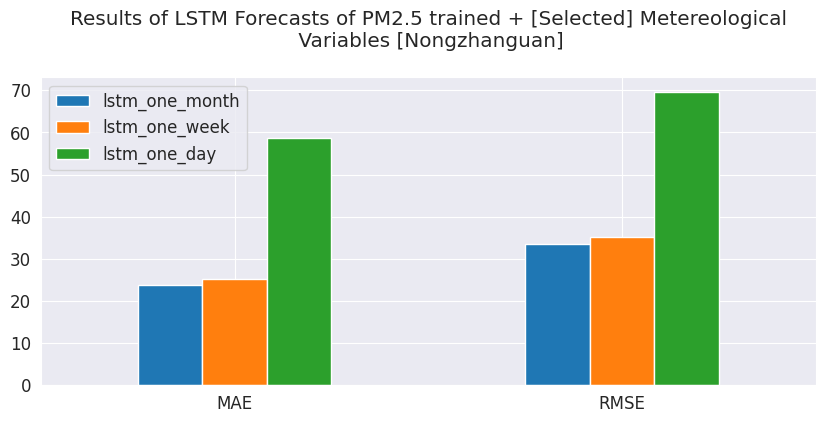

In [ ]:
lstm_results_pm25_with_sel_met_vars.iloc[[0,2],:].T.sort_values(by='MAE').T.plot.bar(
    title='Results of LSTM Forecasts of PM2.5 trained + [Selected] Metereological\n Variables [Nongzhanguan]\n', 
    figsize=(10,4), rot=0)

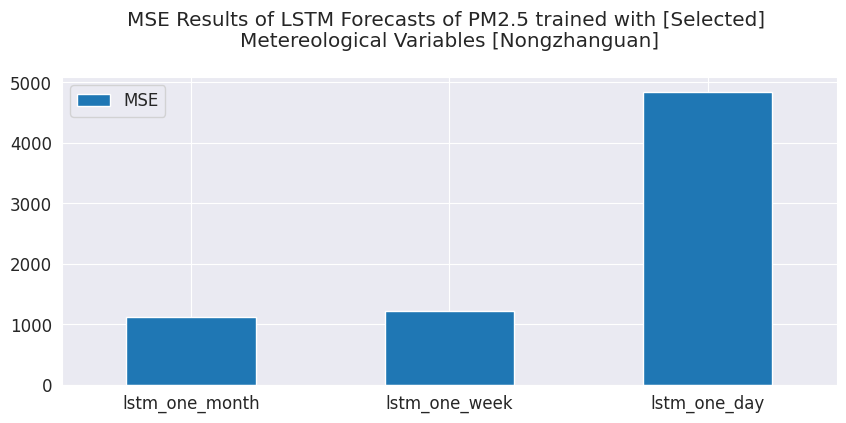

In [ ]:
lstm_results_pm25_with_sel_met_vars.iloc[1,:].sort_values().plot.bar(
    title='MSE Results of LSTM Forecasts of PM2.5 trained with [Selected] \nMetereological Variables [Nongzhanguan]\n', 
    figsize=(10,4), rot=0)
plt.legend()

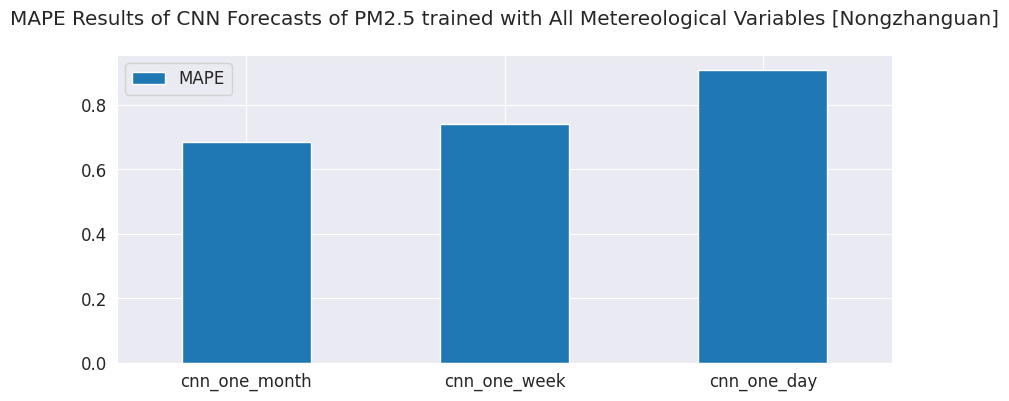

In [ ]:
lstm_results_pm25_with_sel_met_vars.iloc[-1,:].sort_values().plot.bar(
    title='MAPE Results of LSTM Forecasts of PM2.5 trained with [Selected] \nMetereological Variables [Nongzhanguan]\n', 
    figsize=(10,4), rot=0)
plt.legend()

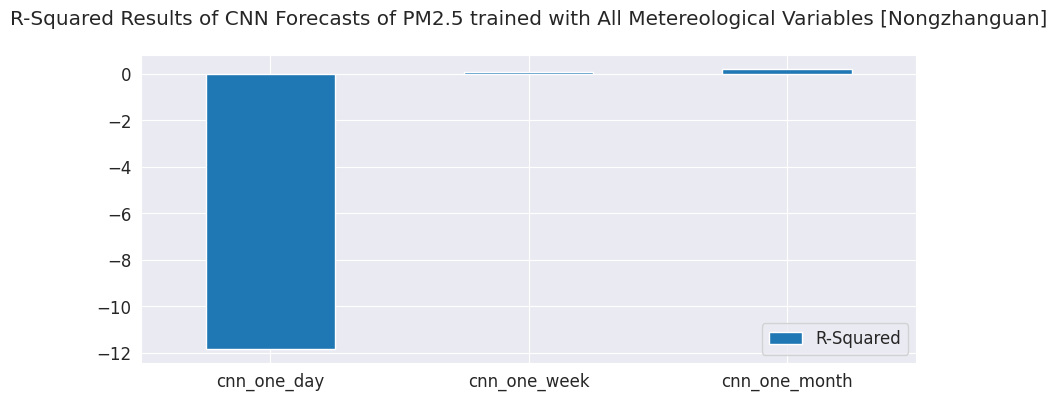

In [ ]:
lstm_results_pm25_with_sel_met_vars.iloc[-2,:].sort_values().plot.bar(
    title='R-Squared Results of LSTM Forecasts of PM2.5 trained with [Selected] \nMetereological Variables [Nongzhanguan]\n', 
    figsize=(10,4), rot=0)
plt.legend()

In [ ]:
# Saving results
lstm_results_pm25_with_sel_met_vars.to_csv(f'{RESULTS_PATH}/lstm_results_pm25_with_selected_met_vars_24lags_Nongzhanguan.csv')

## LSTM + [Selected] Exogenous Metereological Variables

- 1 day (24 hrs) lag
- LSTM
- Nongzhanguan station data

In [37]:
TEST_SIZE = int((20 / 100) * len(y_pm25_nong)) # 20%
N_LAGS = 24
N_FEATURES = 4

EPOCHS = 150
BATCH_SIZE = 20

#### Data Preparation and preprocessing

In [38]:
features_X_nong.corrwith(y_pm25_nong).sort_values()

WSPM   -0.301098
wd     -0.240711
TEMP   -0.173362
RAIN   -0.022705
PRES    0.028121
DEWP    0.097226
dtype: float64

In [39]:
# merged scaled data and target
data_pm25_sel = pd.concat([scaled_features_X_nong[['WSPM', 'wd', 'TEMP', 'DEWP']], y_pm25_nong], axis='columns')
data_pm25_sel.head()

WSPM        wd      TEMP      DEWP  PM2.5
datetime                                                          
2013-03-01 00:00:00  2.998406  1.598127 -1.236368 -1.726439    5.0
2013-03-01 01:00:00  1.592605  1.384841 -1.253821 -1.777120    8.0
2013-03-01 02:00:00  2.686006  1.598127 -1.297452 -1.958126    3.0
2013-03-01 03:00:00  2.373605  1.811414 -1.314905 -2.023288    5.0
2013-03-01 04:00:00  1.045905  1.598127 -1.358537 -1.950885    5.0

In [40]:
# Data Segmentation (80% training : 20% testing)

Xtrain_sel, ytrain_sel, Xtest_sel, ytest_sel = \
    split_train_test_series_multivariate_series(
        data_pm25_sel, test_size=TEST_SIZE)

In [41]:
Xtrain_sel.head(2)

WSPM        wd      TEMP      DEWP
datetime                                                   
2013-03-01 00:00:00  2.998406  1.598127 -1.236368 -1.726439
2013-03-01 01:00:00  1.592605  1.384841 -1.253821 -1.777120

In [42]:
ytrain_sel.head(2)

datetime
2013-03-01 00:00:00    5.0
2013-03-01 01:00:00    8.0
Freq: H, Name: PM2.5, dtype: float64

In [43]:
print(f'Shape of X: {scaled_features_X_nong.shape}')
print(f'Shape of Xtrain: {Xtrain_sel.shape}')
print(f'Shape of Xtest: {Xtest_sel.shape}')

Shape of X: (35064, 6)
Shape of Xtrain: (28052, 4)
Shape of Xtest: (7012, 4)


In [44]:
deep_Xtrain_sel, deep_ytrain_sel = deep_prepare_X_y_for_CNN(
    X=Xtrain_sel, y=ytrain_sel, n_lags=N_LAGS, kind='multi_input')


deep_Xtest_sel, deep_ytest_sel = deep_prepare_X_y_for_CNN(
    X=Xtest_sel, y=ytest_sel, n_lags=N_LAGS, kind='multi_input')

In [45]:
print(f'Shape of Xtrain: {Xtrain_sel.shape}')
print(f'Shape of Deep-Xtrain: {deep_Xtrain_sel.shape}')
print(f'Shape of Deep-Xtest: {deep_Xtest_sel.shape}')
print(f'Shape of Deep-ytrain: {deep_ytrain_sel.shape}')
print(f'Shape of Deep-ytest: {deep_ytest_sel.shape}')

Shape of Xtrain: (28052, 4)
Shape of Deep-Xtrain: (28029, 24, 4)
Shape of Deep-Xtest: (6989, 24, 4)
Shape of Deep-ytrain: (28029,)
Shape of Deep-ytest: (6989,)


In [46]:
for i in range(2):
    print(deep_Xtrain_sel[i], deep_ytrain_sel[i])

[[ 2.99840581  1.59812742 -1.23636817 -1.72643876]
 [ 1.5926049   1.38484101 -1.25382083 -1.77712028]
 [ 2.68600561  1.59812742 -1.29745248 -1.95812569]
 [ 2.37360541  1.81141384 -1.31490514 -2.02328764]
 [ 1.04590454  1.59812742 -1.35853679 -1.95088547]
 [ 0.42110414  1.38484101 -1.40216844 -1.71919854]
 [ 0.26490404  1.38484101 -1.41089477 -1.65403659]
 [ 0.88970444  1.59812742 -1.31490514 -1.65403659]
 [ 2.13930525  1.38484101 -1.21891551 -1.71195833]
 [ 2.84220571  1.81141384 -1.1578312  -1.86400287]
 [ 2.60790556  1.81141384 -1.07056791 -1.80608114]
 [ 2.68600561  1.59812742 -0.93967296 -1.83504201]
 [ 2.13930525  0.95826818 -0.84368333 -1.71195833]
 [ 2.0612052   1.38484101 -0.75642004 -1.71195833]
 [ 1.67070495  1.38484101 -0.65170408 -1.78436049]
 [ 0.18680399  1.59812742 -0.66915674 -1.71919854]
 [-0.04749616  1.81141384 -0.70406206 -1.67575724]
 [ 1.2802047   1.81141384 -0.80877801 -1.69023768]
 [-1.06279682  1.59812742 -0.91349397 -1.64679638]
 [-0.59419652  1.81141384 -0.93

#### LSTM Model Buiding 

##### LSTM Configuration Variant 1 (Bi-directional LSTM Variant) 

In [117]:
# del lstm_model_sel

In [118]:
lstm_model_sel = Sequential([
    # Bi-directional input layer 1
    Bidirectional(LSTM(256, return_sequences=True), 
            input_shape=(N_LAGS, N_FEATURES)),
    # output of layer 1
    Dense(50, activation='tanh'),

    # Bi-directional input layer 2
    Bidirectional(LSTM(200)),
    # output of layer 1 and output of layer 2
    Dense(50, activation='tanh'), # layer 1 hidden-state
    Dense(50, activation='tanh'), # layer 2 hidden-state
    Dropout(0.25),

    # Output layer
    Dense(units=1),
 ])

lstm_model_sel.compile(
    optimizer=Adam(learning_rate=0.001), 
    loss='mse', 
    metrics=[
      MeanAbsoluteError(),
      RootMeanSquaredError(),
      MeanAbsolutePercentageError()
    ])

lstm_model_sel.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_6 (Bidirectio  (None, 24, 512)          534528    
 nal)                                                            
                                                                 
 dense_12 (Dense)            (None, 24, 50)            25650     
                                                                 
 bidirectional_7 (Bidirectio  (None, 400)              401600    
 nal)                                                            
                                                                 
 dense_13 (Dense)            (None, 50)                20050     
                                                                 
 dense_14 (Dense)            (None, 50)                2550      
                                                                 
 dropout_3 (Dropout)         (None, 50)               

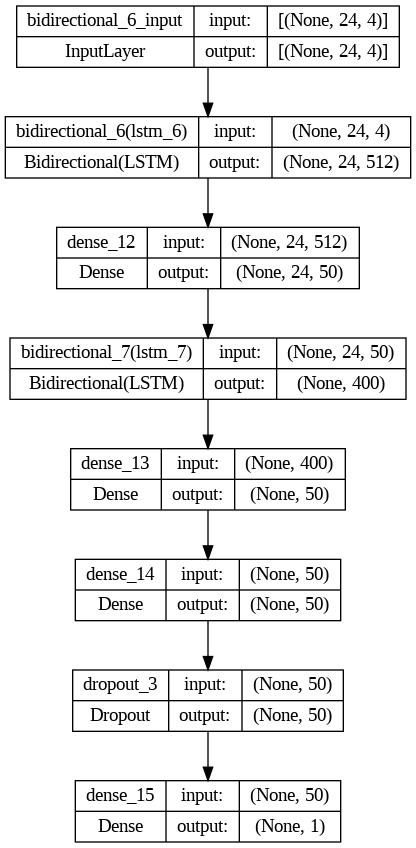

In [119]:
# Model Architecture
plot_model(lstm_model_sel, to_file='lstm_model_nong_with_selected_exo_met_vars_added_multi_input.png', show_shapes=True, show_layer_names=True)

In [120]:
# plt.figure(figsize=(12,4))
visualkeras.layered_view(
    lstm_model_sel, legend=True, 
    scale_xy=1,
    scale_z=1,
    spacing=20,
    background_fill='white',
    to_file=f'{RESULTS_PATH}/deep_lstm_pm25_with_sel_met_vars_Nongzhanguan_architecture.png')

In [121]:
# Training the LSTM model

# callbacks (EarlyStopper to avoid overfitting)
early_stopper = EarlyStopping(
    monitor="loss",
    min_delta=0.05,  # p-value (significance)
    patience=5,
    restore_best_weights=True,
)

# For learning performance improvement
lr_reducer = LearningRateScheduler(lambda x: 1e-3 * 0.90 ** x)


# Fitting the model & applying callbacks
history = lstm_model_sel.fit(
    deep_Xtrain_sel, deep_ytrain_sel, 
    # validation_data=(deep_Xval, deep_yval), 
    batch_size=BATCH_SIZE, epochs = EPOCHS, verbose=1, 
    callbacks=[lr_reducer, early_stopper])


Epoch 1/150
1402/1402 [==============================] - 25s 14ms/step - loss: 10051.0322 - mean_absolute_error: 64.6318 - root_mean_squared_error: 100.2548 - mean_absolute_percentage_error: 129.0818 - lr: 0.0010
Epoch 2/150
1402/1402 [==============================] - 19s 14ms/step - loss: 7677.7183 - mean_absolute_error: 61.0648 - root_mean_squared_error: 87.6226 - mean_absolute_percentage_error: 230.5674 - lr: 9.0000e-04
Epoch 3/150
1402/1402 [==============================] - 18s 13ms/step - loss: 7485.0127 - mean_absolute_error: 62.9419 - root_mean_squared_error: 86.5160 - mean_absolute_percentage_error: 267.1963 - lr: 8.1000e-04
Epoch 4/150
1402/1402 [==============================] - 18s 13ms/step - loss: 7502.4507 - mean_absolute_error: 63.3989 - root_mean_squared_error: 86.6167 - mean_absolute_percentage_error: 273.3788 - lr: 7.2900e-04
Epoch 5/150
1402/1402 [==============================] - 19s 14ms/step - loss: 7298.3262 - mean_absolute_error: 61.4099 - root_mean_squared_er

In [99]:
# history.history

best_epoch = history.history['loss'].index(min(history.history['loss']))
print('TRAINING RESULT SUMMARY')
print('-----------------------\n')
print(f'Best Epoch: {best_epoch + 1}')
print(f'MAE: {history.history["mean_absolute_error"][best_epoch]}')
print(f'MSE: {history.history["loss"][best_epoch]}')
print(f'RMSE: {history.history["root_mean_squared_error"][best_epoch]}')
print(f'MAPE: {history.history["mean_absolute_percentage_error"][best_epoch]}')

TRAINING RESULT SUMMARY
-----------------------

Best Epoch: 68
MAE: 20.052955627441406
MSE: 1782.8897705078125
RMSE: 42.22427749633789
MAPE: 37.73181915283203


In [100]:
# MSE (Loss)
plt.figure(figsize=(12,4))
plt.plot(range(1, len(history.history['loss']) + 1), history.history['loss'], 
         label='MSE', color='r')
plt.title('Training loss (MSE) for LSTM for PM2.5 + [Selected] Metereological Variables [Nongzhanguan]\n')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

Text(0.5, 21.722222222222214, 'Epochs')

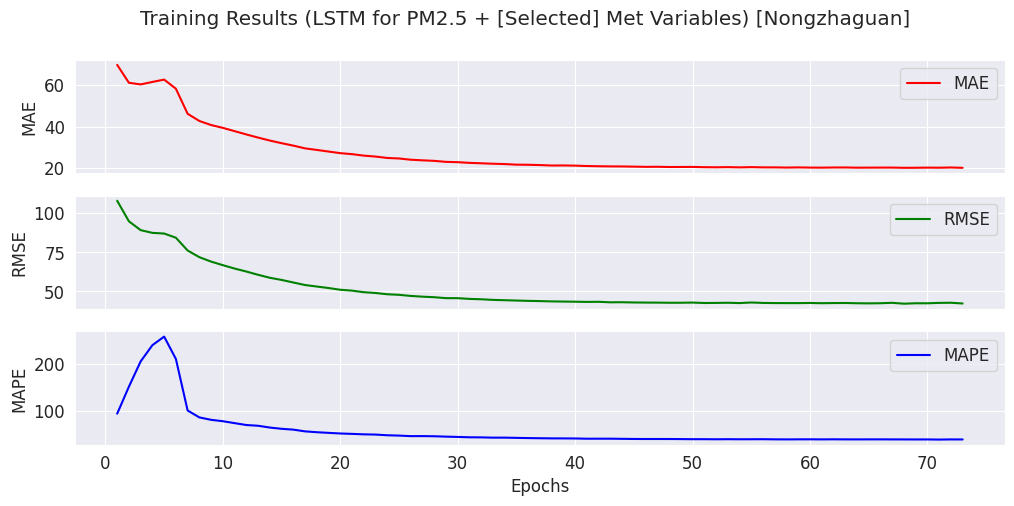

In [101]:
# Training Performances
fig, axs = plt.subplots(3, sharex=True, figsize=(12,5))
fig.suptitle('Training Results (LSTM for PM2.5 + [Selected] Met Variables) [Nongzhaguan]')

# MAE
axs[0].plot(range(1, len(history.history['loss']) + 1), history.history['mean_absolute_error'], 
            label='MAE', color='r')
axs[0].set_ylabel('MAE')
axs[0].legend()

# RMSE
axs[1].plot(range(1, len(history.history['loss']) + 1), history.history['root_mean_squared_error'], 
            label='RMSE', color='g')
axs[1].set_ylabel('RMSE')
axs[1].legend()

# MAPE
axs[2].plot(range(1, len(history.history['loss']) + 1), history.history['mean_absolute_percentage_error'], 
            label='MAPE', color='b')
axs[2].set_ylabel('MAPE')
axs[2].legend()
fig.tight_layout(pad=7.0)
plt.xlabel('Epochs')


In [102]:
# Training RMSE
plt.figure(figsize=(12,4))
plt.plot(range(1, len(history.history['loss']) + 1), np.sqrt(history.history['loss']), label='RMSE', color='r')
plt.title('Training loss (RMSE) LSTM + [Selected] Metereological Variables [Nongzhaguan]\n')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()

In [103]:
# Saving the trained model
lstm_model_sel.save(f'{MODEL_PATH}/lstm_model_pm25_with_selected2_met_vars_added_Nongzhanguan.h5')

---

#### Making Forecasts

In [104]:
# Loading saved trained model
lstm_model_sel = load_model(f'{MODEL_PATH}/lstm_model_pm25_with_selected2_met_vars_added_Nongzhanguan.h5')

##### 24 hrs (One day) Forecast
- 24-lags
- LSTM (Bi-directional)

In [105]:
steps = 24

In [106]:
one_dayX =  deep_Xtest_sel[:steps]
one_dayy =  deep_ytest_sel[:steps]
predictions = lstm_model_sel.predict(one_dayX)
predictions[:5]

1/1 [==============================] - 1s 1s/step


array([[48.377876],
       [46.836906],
       [42.548813],
       [42.966553],
       [66.96481 ]], dtype=float32)

In [107]:
preds = pd.Series(predictions.flatten(), index=Xtest_sel.index[:steps], name='PM2.5')
y_true = pd.Series(one_dayy, index=Xtest_sel.index[:steps], name='PM2.5')
preds.head()

datetime
2016-05-12 20:00:00    48.377876
2016-05-12 21:00:00    46.836906
2016-05-12 22:00:00    42.548813
2016-05-12 23:00:00    42.966553
2016-05-13 00:00:00    66.964813
Freq: H, Name: PM2.5, dtype: float32

In [108]:
y_true.head()

datetime
2016-05-12 20:00:00    23.0
2016-05-12 21:00:00    29.0
2016-05-12 22:00:00    29.0
2016-05-12 23:00:00    36.0
2016-05-13 00:00:00    37.0
Freq: H, Name: PM2.5, dtype: float64

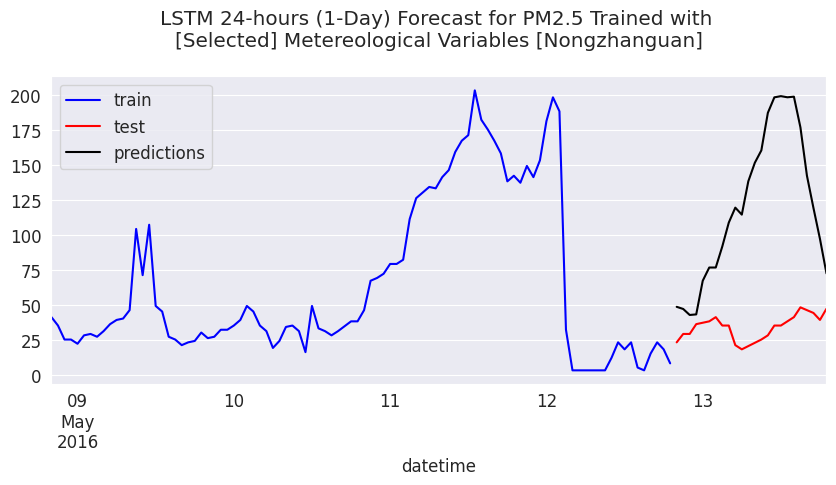

In [109]:
plt.figure(figsize=(10,4))
pd.Series(deep_ytrain_sel[-steps*4:], index=Xtrain_sel.index[-steps*4:], name='PM2.5').plot(label='train', color='b')
y_true.plot(label='test', color='r')
preds.plot(label='predictions', color='black')
plt.title('LSTM 24-hours (1-Day) Forecast for PM2.5 Trained with \n[Selected] Metereological Variables [Nongzhanguan]\n')
plt.legend()

In [110]:
results_lstm_1_day_forecast_sel_met_24lags = evaluate_model_performance(y_true, preds, label='lstm_one_day_sel')
results_lstm_1_day_forecast_sel_met_24lags

lstm_one_day_sel
MAE                  85.811
MSE               10226.248
RMSE                101.125
R-Squared          -134.733
MAPE                  2.801

##### One Week (168hrs) Forecast
- One week (24 * 7 = 168 hrs steps) into the future
- 24-lags
- CNN

In [111]:
steps = 24 * 7

In [112]:
one_weekX =  deep_Xtest_sel[:steps]
one_weeky =  deep_ytest_sel[:steps]
predictions = lstm_model_sel.predict(one_weekX)
predictions[:5]

6/6 [==============================] - 0s 8ms/step


array([[48.377876],
       [46.836906],
       [42.548813],
       [42.966553],
       [66.96481 ]], dtype=float32)

In [113]:
preds = pd.Series(predictions.flatten(), index=Xtest_sel.index[:steps], name='PM2.5')
y_true = pd.Series(one_weeky, index=Xtest_sel.index[:steps], name='PM2.5')
preds.head()

datetime
2016-05-12 20:00:00    48.377876
2016-05-12 21:00:00    46.836906
2016-05-12 22:00:00    42.548813
2016-05-12 23:00:00    42.966553
2016-05-13 00:00:00    66.964813
Freq: H, Name: PM2.5, dtype: float32

In [114]:
y_true.head()

datetime
2016-05-12 20:00:00    23.0
2016-05-12 21:00:00    29.0
2016-05-12 22:00:00    29.0
2016-05-12 23:00:00    36.0
2016-05-13 00:00:00    37.0
Freq: H, Name: PM2.5, dtype: float64

In [115]:
plt.figure(figsize=(10,4))
pd.Series(deep_ytrain_sel[-steps*4:], index=Xtrain_sel.index[-steps*4:], 
          name='PM2.5').plot(label='train', color='b')
y_true.plot(label='test', color='r')
preds.plot(label='predictions', color='black')
plt.title('LSTM 168 hours (1-Week) Forecast of PM2.5 at 24-lags + [Selected] \nMetereology Variables [Nongzhanguan]\n')
plt.legend()

In [116]:
results_lstm_1_week_forecast_sel_met_24lags = evaluate_model_performance(y_true, preds, label='lstm_one_week_sel')
results_lstm_1_week_forecast_sel_met_24lags

lstm_one_week_sel
MAE                   30.938
MSE                 2110.936
RMSE                  45.945
R-Squared             -1.350
MAPE                   0.916

##### One Month (744 hrs) Forecast
- One month (24 * 31 = 744 hrs steps) into the future
- 24-lags
- CNN

In [77]:
steps = 24 * 31

In [78]:
one_monthX =  deep_Xtest_sel[:steps]
one_monthy =  deep_ytest_sel[:steps]
predictions = lstm_model_sel.predict(one_monthX)
predictions[:5]

24/24 [==============================] - 0s 9ms/step


array([[ 76.072266],
       [ 83.6706  ],
       [ 87.6014  ],
       [ 94.517044],
       [106.03144 ]], dtype=float32)

In [79]:
preds = pd.Series(predictions.flatten(), index=Xtest_sel.index[:steps], name='PM2.5')
y_true = pd.Series(one_monthy, index=Xtest_sel.index[:steps], name='PM2.5')
preds.head()

datetime
2016-05-12 20:00:00     76.072266
2016-05-12 21:00:00     83.670601
2016-05-12 22:00:00     87.601402
2016-05-12 23:00:00     94.517044
2016-05-13 00:00:00    106.031441
Freq: H, Name: PM2.5, dtype: float32

In [80]:
y_true.head()

datetime
2016-05-12 20:00:00    23.0
2016-05-12 21:00:00    29.0
2016-05-12 22:00:00    29.0
2016-05-12 23:00:00    36.0
2016-05-13 00:00:00    37.0
Freq: H, Name: PM2.5, dtype: float64

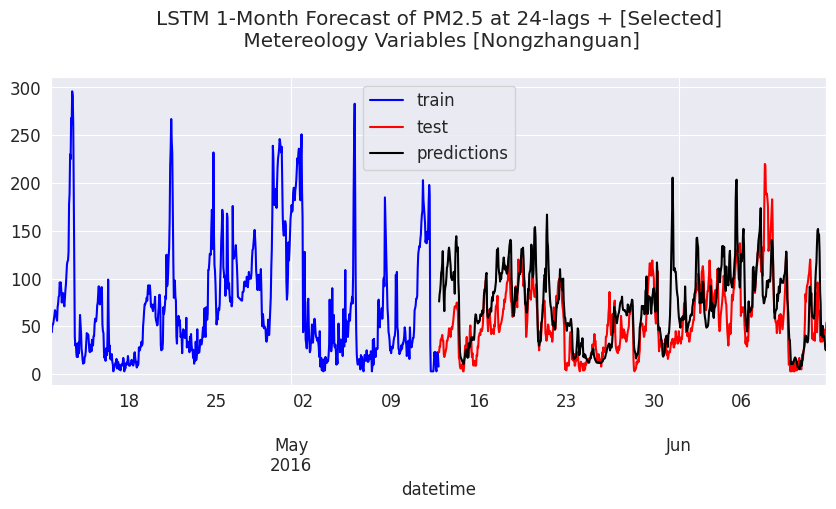

In [81]:
plt.figure(figsize=(10,4))
pd.Series(deep_ytrain_sel[-steps:], index=Xtrain_sel.index[-steps:], name='PM2.5').plot(label='train', color='b')
y_true.plot(label='test', color='r')
preds.plot(label='predictions', color='black')
plt.title('LSTM 1-Month Forecast of PM2.5 at 24-lags + [Selected]\n Metereology Variables [Nongzhanguan]\n')
plt.legend()

In [82]:
results_lstm_1_month_forecast_sel_met_24lags = evaluate_model_performance(y_true, preds, label='lstm_one_month_sel_met')
results_lstm_1_month_forecast_sel_met_24lags

lstm_one_month_sel_met
MAE                        26.367
MSE                      1289.722
RMSE                       35.913
R-Squared                   0.028
MAPE                        0.759

##### Combined Results

In [83]:
lstm_results_pm25_with_sel_met_vars = pd.concat([
    results_lstm_1_day_forecast_sel_met_24lags, 
    results_lstm_1_week_forecast_sel_met_24lags,
    results_lstm_1_month_forecast_sel_met_24lags
    ], axis='columns')

lstm_results_pm25_with_sel_met_vars

lstm_one_day_sel  lstm_one_week_sel  lstm_one_month_sel_met
MAE                  69.951             30.928                  26.367
MSE                5027.158           1563.633                1289.722
RMSE                 70.902             39.543                  35.913
R-Squared           -65.726             -0.741                   0.028
MAPE                  2.173              0.921                   0.759

In [88]:
lstm_results_pm25_with_sel_met_vars.iloc[[0,2],:].T.sort_values(by='MAE').T.plot.bar(
    title='Results of LSTM Forecasts of PM2.5 trained with \n[Selected] Metereological Variables [Nongzhanguan]\n', 
    figsize=(10,4), rot=0)

<Axes: title={'center': 'Results of LSTM Forecasts of PM2.5 trained with \n[Selected] Metereological Variables [Nongzhanguan]\n'}>

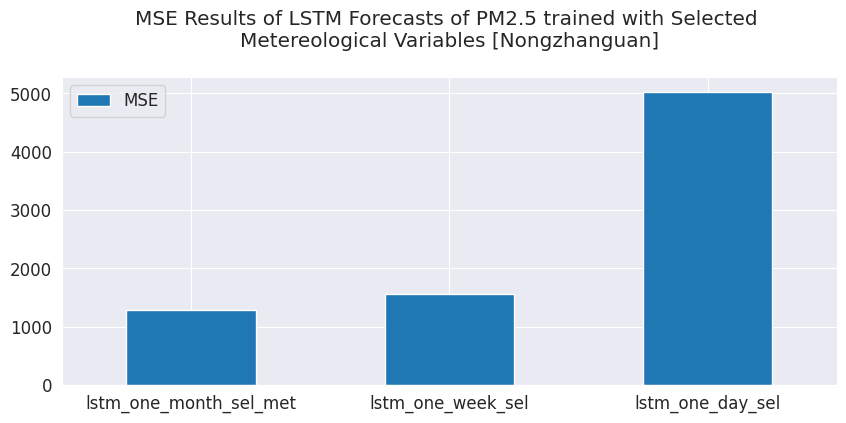

In [86]:
lstm_results_pm25_with_sel_met_vars.iloc[1,:].sort_values().plot.bar(
    title='MSE Results of LSTM Forecasts of PM2.5 trained with Selected \nMetereological Variables [Nongzhanguan]\n', 
    figsize=(10,4), rot=0)
plt.legend()

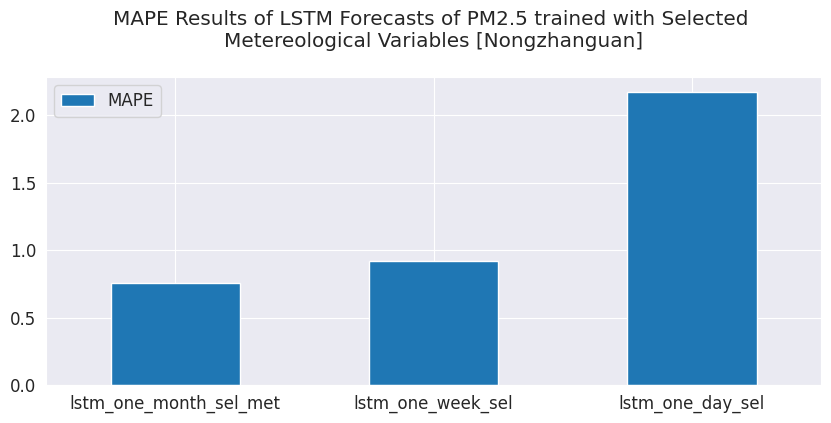

In [90]:
lstm_results_pm25_with_sel_met_vars.iloc[-1,:].sort_values().plot.bar(
    title='MAPE Results of LSTM Forecasts of PM2.5 trained with Selected \nMetereological Variables [Nongzhanguan]\n', 
    figsize=(10,4), rot=0)
plt.legend()

In [92]:
lstm_results_pm25_with_sel_met_vars.iloc[-2,:].sort_values().plot.bar(
    title='R-Squared Results of LSTM Forecasts of PM2.5 trained with \nSelected Metereological Variables [Nongzhanguan]\n', 
    figsize=(10,4), rot=0)
plt.legend()

In [93]:
# Saving results
lstm_results_pm25_with_sel_met_vars.to_csv(f'{RESULTS_PATH}/lstm_results_pm25_with_selected_met_vars_24lags_Nongzhanguan.csv')

## OPTIMIZATION with Parameter Tunning (using ray-tune random_search strategy)

## OPTIMIZATION

### Hyper-parameter Tunning

- Ray Tune

In [ ]:
# train = lstm_pm25_data.iloc[:-TEST_SIZE]
# test = lstm_pm25_data.iloc[-TEST_SIZE:]

# print(f'Train set Date Range: {train.index.min()} --- {train.index.max()}')
# print(f'Test Set Date Range: {test.index.min()} --- {test.index.max()}')




# lstm_auto_models = [
#     AutoLSTM(h=STEPS, num_samples=N_SAMPLES, loss=LOSS)
# ]

# lstm_model = NeuralForecast(models=lstm_auto_models, freq='H')

# # Fitting the model
# lstm_model.fit(train)
# predictions = lstm_model.predict().reset_index()
# predictions.head()

Train set Date Range: 2013-03-01 00:00:00 --- 2016-05-12 19:00:00
Test Set Date Range: 2016-05-12 20:00:00 --- 2017-02-28 23:00:00


In [ ]:
class LSTM_BiDi_Trainer:
    def __init__(self, Xtrain, ytrain, Xval=None, yval=None, 
               loss='mean_squared_error', n_lags=24, 
               n_features=6, n_outputs=1, epochs=150):
      
        self.Xtrain = Xtrain
        self.ytrain = ytrain
        self.Xval = Xval
        self.yval = yval
        self.loss = loss
        self.n_lags = n_lags
        self.n_features = n_features
        self.n_outputs = n_outputs
        self.epochs = epochs

    # functional encoder_decoder LSTM implementation
    def train(self, config):

        lstm_model = Sequential([
            # Bi-directional input layer 1
            Bidirectional(LSTM(config['n_encoder_decoder_h_filters'], return_sequences=True), 
                    input_shape=(N_LAGS, N_FEATURES)),
            # output of layer 1
            Dense(20, activation='tanh'),

            # Bi-directional input layer 2
            Bidirectional(LSTM(int(config['n_encoder_decoder_h_filters'] / 4 * 3))),
            # output of layer 1 and output of layer 2
            Dense(20, activation='tanh'), # layer 1 hidden-state
            Dense(20, activation='tanh'), # layer 2 hidden-state
            Dropout(0.25),

            # Output layer
            Dense(units=self.n_outputs),
        ])

        # optimizer
        optimizer = Adam(learning_rate= config['lr'])
        if config['optimizer'] != 'adam':
            optimizer = SGD(learning_rate= config['lr'])

        lstm_model.compile(
            optimizer=optimizer, 
            loss=self.loss, 
            metrics=[
              MeanAbsoluteError(),
              RootMeanSquaredError(),
              MeanAbsolutePercentageError()
            ])

        lstm_model.summary()

        # callbacks (EarlyStopper to avoid overfitting)
        early_stopper = EarlyStopping(
            monitor="loss",
            min_delta=0.05,  # p-value (significance)
            patience=5,
            restore_best_weights=True,
        )

        lr_reducer = LearningRateScheduler(lambda lr: 1e-3 * 0.90 ** lr)

        # Fitting the model
        lstm_model.fit(
            self.Xtrain, self.ytrain, # validation_data=(deep_Xval, deep_yval), 
            batch_size=config['batch_size'], 
            epochs = self.epochs, verbose=0, 
            callbacks=[
                    lr_reducer, early_stopper, 
                    TuneReportCallback({"mean_squared_error": "mean_squared_error"})
                ])


        return {"mean_squared_error": 'mean_squared_error'}


In [ ]:
class LSTM_Trainer:
    def __init__(self, Xtrain, ytrain, Xval=None, yval=None, 
               loss='mean_squared_error', n_lags=24, 
               n_features=6, n_outputs=1, epochs=150):
      
        self.Xtrain = Xtrain
        self.ytrain = ytrain
        self.Xval = Xval
        self.yval = yval
        self.n_lags = n_lags
        self.n_features = n_features
        self.n_outputs = n_outputs
        self.epochs = epochs

    # functional encoder_decoder LSTM implementation
    def train(self, config):
      
        # ENCODER
        #--------

        # Input layer
        encoder_inputs = Input(shape=(self.n_lags, self.n_features))

        # Layer 1 - encoder
        encoder_l1 = LSTM(config['n_encoder_decoder_h_filters'], return_sequences = True, return_state=True)
        encoder_outputs1 = encoder_l1(encoder_inputs)
        encoder_states1 = encoder_outputs1[1:]

        # Layer2 - encoder
        encoder_l2 = LSTM(config['n_encoder_decoder_h_filters'], return_state=True)
        encoder_outputs2 = encoder_l2(encoder_outputs1[0])
        encoder_states2 = encoder_outputs2[1:]


        # DECODER
        #---------

        # decoder input
        decoder_inputs = RepeatVector(STEPS)(encoder_outputs2[0])

        # Layer 1 - decoder
        decoder_l1 = LSTM(
            config['n_encoder_decoder_h_filters'], 
            return_sequences=True)(
                decoder_inputs, initial_state = encoder_states1)

        # layer 2- decoder
        decoder_l2 = LSTM(
            config['n_encoder_decoder_h_filters'],
            return_sequences=True)(
                decoder_l1, initial_state = encoder_states2)
        decoder_outputs2 = TimeDistributed(Dense(self.n_outputs))(decoder_l2)

        # Output layer
        model_e2d2 = Model(encoder_inputs, decoder_outputs2)


        # optimizer
        optimizer = Adam(learning_rate= config['lr'])
        if config['optimizer'] != 'adam':
            optimizer = SGD(learning_rate= config['lr'])

        # Compiling the RNN
        model_e2d2.compile(
            optimizer = optimizer, 
            loss = self.loss, 
            metrics = [
              MeanAbsoluteError(),
              MeanAbsolutePercentageError(),
              RootMeanSquaredError()
            ])

        lr_reducer = LearningRateScheduler(lambda lr: 1e-3 * 0.90 ** lr)

        # Fitting the model
        model_e2d2.fit(
            self.Xtrain,
            self.ytrain,
            batch_size=config['batch_size'],
            epochs=self.epochs,
            verbose=0,
            #validation_data=(self.Xval, self. yval),
            callbacks=[lr_reducer, TuneReportCallback({"mean_squared_error": "mean_squared_error"})],
        )

        return {"mean_squared_error": 'mean_squared_error'}


In [ ]:
class CNN_Trainer:
    def __init__(self, Xtrain, ytrain, Xval=None, yval=None, 
               n_lags=24, loss='mse', n_steps=24*7, 
               n_features=6, n_outputs=1, epochs=150):
      
        self.Xtrain = Xtrain
        self.ytrain = ytrain
        self.Xval = Xval
        self.yval = yval
        self.n_lags = n_lags
        self.loss = loss
        self.n_steps = n_steps
        self.n_features = n_features
        self.n_outputs = n_outputs
        self.epochs = epochs

    def train(self, config):

        cnn_model_exo = Sequential()

        # input layer and hidden layer1
        cnn_model_exo.add(Conv1D(filters=256, kernel_size=2, activation='relu', 
                                      input_shape=(self.n_lags, self.n_features)))
        
        cnn_model_exo.add(Conv1D(filters=128, kernel_size=2, activation='relu'))
        cnn_model_exo.add(Conv1D(filters=128, kernel_size=2, activation='relu'))
        cnn_model_exo.add(Dropout(config['dropouts']))
        cnn_model_exo.add(MaxPooling1D(pool_size=2))

        cnn_model_exo.add(Conv1D(filters=64, kernel_size=2, activation='relu'))
        cnn_model_exo.add(Conv1D(filters=64, kernel_size=2, activation='relu'))
        cnn_model_exo.add(Dropout(config['dropouts']))
        cnn_model_exo.add(MaxPooling1D(pool_size=2))

        cnn_model_exo.add(Conv1D(filters=32, kernel_size=2, activation='relu'))
        cnn_model_exo.add(Conv1D(filters=32, kernel_size=2, activation='relu'))
        cnn_model_exo.add(Dropout(config['dropouts']))
        cnn_model_exo.add(MaxPooling1D(pool_size=2))

        cnn_model_exo.add(Flatten())
        cnn_model_exo.add(Dense(units=16, activation='relu'))

        # Output layer
        cnn_model_exo.add(Dense(units=self.n_outputs))

        # optimizer
        optimizer = Adam(learning_rate= config['lr'])
        if config['optimizer'] != 'adam':
            optimizer = SGD(learning_rate= config['lr'])

        # Compiling
        cnn_model_exo.compile(
            optimizer=optimizer, 
            loss=self.loss, 
            metrics=[
                MeanAbsoluteError(),
                MeanAbsolutePercentageError(),
                MeanSquaredError(),
                RootMeanSquaredError()
            ]
          )

        # Fitting
        cnn_model_exo.fit(
            self.Xtrain,
            self.ytrain,
            batch_size=config['batch_size'],
            epochs=self.epochs,
            verbose=0,
            # validation_data=(self.Xval, self.yval),
            callbacks=[TuneReportCallback({"mean_squared_error": "mean_squared_error"})],
        )


        return {"mean_squared_error": 'mean_squared_error'}


In [ ]:
def tune_DeepLearningModel(model_trainer_fn, search_space, n_samples=30, 
                           num_training_iterations=150, 
                           metric='mean_squared_error', obj='min'):
    
    # using HyperBand Scheduler Strategy
    sched = AsyncHyperBandScheduler(
        time_attr="training_iteration", max_t=400, grace_period=20
    )
    

    # Tunning
    tuner = tune.Tuner(
        tune.with_resources(model_trainer_fn, resources={"cpu": 2, "gpu": 0}),
        tune_config=tune.TuneConfig(
            metric=metric,
            mode=obj,
            scheduler=sched,
            num_samples=n_samples,
            time_budget_s=60*45, # 45 mins max
        ),
        run_config=air.RunConfig(
            name="exp",
            stop={"mean_squared_error": 4, "training_iteration": num_training_iterations},
        ),
        param_space=search_space,
    )

    # getting results
    results = tuner.fit()
    print("Best hyperparameters found were: ", results.get_best_result().config)

In [ ]:
# # RUN this cell if trainer failed at any point

# tuner = Tuner.restore(results.experiment_path, trainable=trainer)
# tuner.fit()

##### Tunning LSTM Hyperparameters

In [ ]:
lstm_search_space = {
    'n_encoder_decoder_h_filters': tune.choice([128, 256]),
    'n_enc_dec_layers': tune.choice([4, 6]),
    'dropouts': tune.choice([0.2, 0.3]),
    'optimizer': tune.choice(['adam', 'sgd']),
    'lr': tune.choice([0.0001, 0.001, 0.01]),
    'batch_size': tune.choice([20, 32]),
    # 'momentum': tune.uniform(0.1, 0.9)
}

In [ ]:
lstm_trainer = LSTM_Trainer(Xtrain=deep_Xtrain, ytrain=deep_ytrain, 
               loss='mean_squared_error', n_lags=24, 
               n_features=1, n_outputs=1, epochs=150)

tune_DeepLearningModel(
    model_trainer_fn = lstm_trainer.train, 
    search_space=lstm_search_space, 
    n_samples=30, 
    num_training_iterations=15, 
    metric='mean_squared_error', 
    obj='min')

2023-05-18 15:46:00,213	WARNING tune.py:184 -- Stop signal received (e.g. via SIGINT/Ctrl+C), ending Ray Tune run. This will try to checkpoint the experiment state one last time. Press CTRL+C (or send SIGINT/SIGKILL/SIGTERM) to skip. 
2023-05-18 15:46:02,253	ERROR tune.py:941 -- Trials did not complete: [_trainable_7ed8d_00000, _trainable_7ed8d_00001, _trainable_7ed8d_00002, _trainable_7ed8d_00003, _trainable_7ed8d_00004, _trainable_7ed8d_00005, _trainable_7ed8d_00006, _trainable_7ed8d_00007, _trainable_7ed8d_00008, _trainable_7ed8d_00009, _trainable_7ed8d_00010, _trainable_7ed8d_00011, _trainable_7ed8d_00012, _trainable_7ed8d_00013, _trainable_7ed8d_00014, _trainable_7ed8d_00015]
2023-05-18 15:46:02,254	INFO tune.py:945 -- Total run time: 256.25 seconds (256.15 seconds for the tuning loop).
2023-05-18 15:46:02,257	WARNING tune.py:954 -- Experiment has been interrupted, but the most recent state was saved.
Continue running this experiment with: Tuner.restore(path="/root/ray_results/exp

RuntimeError: ignored

##### Tunning CNN Hyperparameters

In [ ]:
cnn_search_space = {
    'dropouts': tune.choice([0.2, 0.3]),
    'optimizer': tune.choice(['adam', 'sgd']),
    'lr': tune.choice([0.0001, 0.001, 0.01]),
    'batch_size': tune.choice([20, 32]),
    # 'momentum': tune.uniform(0.1, 0.9),

}

In [ ]:
cnn_trainer = CNN_Trainer(Xtrain=deep_Xtrain, ytrain=deep_ytrain, 
               loss='mean_squared_error', n_lags=24, 
               n_features=1, n_outputs=1, epochs=150)

tune_DeepLearningModel(
    model_trainer_fn = cnn_trainer.train, 
    search_space=cnn_search_space, 
    n_samples=30, 
    num_training_iterations=15, 
    metric='mean_squared_error', 
    obj='min')

NameError: ignored

# Gucheng Station